<a href="https://colab.research.google.com/github/meluxis/Analysis_Transformer_ComputationalCost_Optimization/blob/main/BaselineModelT5_Optimized_Pruned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model T5 Baseline Optimized

#### Connect to drive and authentification

In [ ]:
#Connect google colab and Google Cloud bucket for storage----------------------

#Link google account
from google.colab import auth
import os
auth.authenticate_user()

# Set up manual GCS access
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/adc.json"

In [ ]:
#Link bucket content
BUCKET_NAME = "data_bucket_experimental_analysis"
# Validate bucket
!gsutil ls -b gs://$BUCKET_NAME || gsutil mb -l us-central1 gs://$BUCKET_NAME

gs://data_bucket_experimental_analysis/


#### Installing dependencies

In [ ]:
#install required dependencies ------------------------------------------------
!pip install transformers datasets torch torchvision
!pip install tf-keras~=2.16
!pip install datasets
!pip install Rouge
!pip install sentence-transformers
!pip install codecarbon
!pip install fvcore
!pip install datasets
!pip install tensorflow

#### Importing libraries

In [ ]:
#import libraries--------------------------------------------------------------
import torch
import time
import psutil  # For memory usage
import sys
import tensorflow as tf

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler, autocast

from codecarbon import EmissionsTracker
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import T5Tokenizer,
                          T5ForConditionalGeneration,
                          TrainingArguments,
                          Trainer,
                          T5Model,
                          get_scheduler
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import argparse

from sklearn.metrics import accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score
from rouge import Rouge

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


#### Importing dataset

In [ ]:
#import dataset ----------------------------------------------------------------
dataset = load_dataset("google/Synthetic-Persona-Chat")

train_data = dataset["train"]
test_data = dataset["test"]

# Afficher quelques exemples
print(train_data["user 1 personas"][0:5])  # Afficher 5 exemples
print(train_data["user 2 personas"][0:5])
print(train_data["Best Generated Conversation"][0:5])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


['I am 32.\nI do not want a job.\nI play video games all day.\nI still live at home with my parents.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.\nI eat all take out.', 'I write.\nI work at mcdonald s.\nI watch youtube videos.\nI have brown hair.', 'I am bald.\nI like to swim.\nMy favorite drink is chocolate milk.\nI don t work.']
['My favorite drink is iced coffee.\nI have a black belt in karate.\nI m in a jazz band and play the saxophone.\nI vacation along lake michigan every summer.', 'I have a ford f150.\nI like ford cars.\nMy truck is black.\nI also like ford trucks.\nI own a ford truck.', 'I can recite the movie young frankenstein word for word.\nI like to make my own clothes.\nI am partially blind.\nI do volunteer work for human rights organizations.\nI can do convincing bird calls.', 'I want to move.\nI don t like feeling

#### Tokenize inputs

In [ ]:
#Tokenize inputs (text)--------------------------------------------------------
TOKENIZER = T5Tokenizer.from_pretrained("t5-base")

def preprocess_function(examples):  #Tokenize inputs and targets

  #Combine both personas
  inputs = [p1 + p2 for p1,
            p2 in zip(
                examples["user 1 personas"],
                examples["user 2 personas"])
            ]

  #tokensize inputs (persona 1, persona 2)
  model_inputs = TOKENIZER(inputs,
                           max_length=512,
                           truncation=True,
                           padding="max_length"
                           )

  #tokenize targets (best generated conversations)
  with TOKENIZER.as_target_tokenizer():
      # Ensure 'Best Generated Conversation' is a list of strings
    conversations = [str(conv) for conv in examples["Best Generated Conversation"]]
    labels = TOKENIZER(conversations,
                       max_length=512,
                       truncation=True,
                       padding="max_length"
                       )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# Preprocess the dataset
tokenized_train_dataset = train_data.map(preprocess_function,
                                         batched=True,
                                         batch_size=8
                                         )
tokenized_test_dataset = test_data.map(preprocess_function,
                                       batched=True,
                                         batch_size=8)

# Example usage (accessing tokenized data):
print(tokenized_train_dataset[0]["input_ids"])
print(tokenized_train_dataset[0]["labels"])


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[27, 183, 3538, 5, 27, 103, 59, 241, 3, 9, 613, 5, 27, 577, 671, 1031, 66, 239, 5, 27, 341, 619, 44, 234, 28, 82, 1362, 5, 7008, 1305, 3281, 19, 3, 867, 26, 1975, 5, 27, 43, 3, 9, 1001, 6782, 16, 3, 4031, 342, 5, 27, 3, 51, 16, 3, 9, 9948, 1928, 11, 577, 8, 3, 7, 9, 226, 32, 6399, 5, 27, 4257, 590, 6957, 2278, 12588, 334, 1248, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

#### Create DataLoaders

In [ ]:
# Create Data Loaders--------------------------------------------------------
#Transform Data for compatibility with pytorch

from torch.utils.data import DataLoader

# Create a custom Dataset class
class PersonaChatDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['labels'])
        }

# Initiliasing DataLoaders
train_dataset = PersonaChatDataset(tokenized_train_dataset)
test_dataset = PersonaChatDataset(tokenized_test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5) # Adjust batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=5) # Adjust batch size as needed



#### Importing and defining model

In [ ]:
#Importing and defining model--------------------------------------------------
#Define model from https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/main/notebooks/t5-trivia.ipynb#scrollTo=DZhAd0U_4B_o
# Required to fix Colab flag parsing issue.

sys.argv = sys.argv[:1]

BASE_DIR = "gs://data_bucket_experimental_analysis" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True

MODEL_SIZE = "base" #@param["small", "base", "large", "3B", "11B"]
PRETRAINED_DIR = "t5-base"
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)


# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

# The models from our paper are based on the Mesh Tensorflow Transformer.
#Change to T5ForConditionalGeneration for finetuning task
model = T5ForConditionalGeneration.from_pretrained(PRETRAINED_DIR)


#### Fine Tuning model

[codecarbon INFO @ 19:33:15] [setup] RAM Tracking...
[codecarbon INFO @ 19:33:15] [setup] CPU Tracking...
[codecarbon WARNING @ 19:33:15] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



cpu


[codecarbon WARNING @ 19:33:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:33:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:33:16] [setup] GPU Tracking...
[codecarbon INFO @ 19:33:16] No GPU found.
[codecarbon INFO @ 19:33:16] >>> Tracker's metadata:
[codecarbon INFO @ 19:33:16]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:33:16]   Python version: 3.11.11
[codecarbon INFO @ 19:33:16]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 19:33:16]   Available RAM : 334.562 GB
[codecarbon INFO @ 19:33:16]   CPU count: 96
[codecarbon INFO @ 19:33:16]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 19:33:16]   GPU count: None
[codecarbon INFO @ 19:33:16]   GPU model: None
[codecarbon INFO @ 19:33:16] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-11-e69b251b5964>:56: F

Batch 1/559 - Loss: 15.030086517333984


[codecarbon INFO @ 19:33:46] Energy consumed for RAM : 0.001043 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:33:46] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:46] 0.001397 kWh of electricity used since the beginning.
  0%|          | 2/559 [00:34<2:35:10, 16.72s/it]

Batch 2/559 - Loss: 15.245197296142578


[codecarbon INFO @ 19:34:01] Energy consumed for RAM : 0.001565 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:01] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:01] 0.002097 kWh of electricity used since the beginning.
  1%|          | 3/559 [00:47<2:22:55, 15.42s/it]

Batch 3/559 - Loss: 15.09817886352539


[codecarbon INFO @ 19:34:16] Energy consumed for RAM : 0.002088 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:16] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:16] 0.002796 kWh of electricity used since the beginning.
  1%|          | 4/559 [01:09<2:44:46, 17.81s/it]

Batch 4/559 - Loss: 14.54913330078125


[codecarbon INFO @ 19:34:31] Energy consumed for RAM : 0.002610 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:31] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:31] 0.003496 kWh of electricity used since the beginning.
  1%|          | 5/559 [01:23<2:31:14, 16.38s/it]

Batch 5/559 - Loss: 15.09109878540039


[codecarbon INFO @ 19:34:46] Energy consumed for RAM : 0.003133 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:34:46] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:46] 0.004196 kWh of electricity used since the beginning.
  1%|          | 6/559 [01:37<2:22:42, 15.48s/it]

Batch 6/559 - Loss: 15.10562515258789


[codecarbon INFO @ 19:35:01] Energy consumed for RAM : 0.003656 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:01] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:01] 0.004895 kWh of electricity used since the beginning.
  1%|▏         | 7/559 [01:50<2:17:27, 14.94s/it]

Batch 7/559 - Loss: 14.676247596740723


[codecarbon INFO @ 19:35:16] Energy consumed for RAM : 0.004178 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:16] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:16] 0.005595 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:16] 0.021095 g.CO2eq/s mean an estimation of 665.2441350816042 kg.CO2eq/year
  1%|▏         | 8/559 [02:04<2:13:59, 14.59s/it]

Batch 8/559 - Loss: 15.000741004943848


[codecarbon INFO @ 19:35:31] Energy consumed for RAM : 0.004700 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:31] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:31] 0.006294 kWh of electricity used since the beginning.
  2%|▏         | 9/559 [02:18<2:11:41, 14.37s/it]

Batch 9/559 - Loss: 15.119112968444824


[codecarbon INFO @ 19:35:46] Energy consumed for RAM : 0.005223 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:35:46] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:46] 0.006994 kWh of electricity used since the beginning.
  2%|▏         | 10/559 [02:32<2:10:08, 14.22s/it]

Batch 10/559 - Loss: 14.904559135437012


[codecarbon INFO @ 19:36:01] Energy consumed for RAM : 0.005746 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:01] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:01] 0.007694 kWh of electricity used since the beginning.
  2%|▏         | 11/559 [02:45<2:07:27, 13.96s/it]

Batch 11/559 - Loss: 15.04036808013916


  2%|▏         | 12/559 [02:59<2:06:34, 13.88s/it]

Batch 12/559 - Loss: 15.183121681213379


[codecarbon INFO @ 19:36:16] Energy consumed for RAM : 0.006268 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:16] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:16] 0.008393 kWh of electricity used since the beginning.
  2%|▏         | 13/559 [03:13<2:05:14, 13.76s/it]

Batch 13/559 - Loss: 15.131063461303711


[codecarbon INFO @ 19:36:31] Energy consumed for RAM : 0.006791 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:31] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:31] 0.009093 kWh of electricity used since the beginning.
  3%|▎         | 14/559 [03:26<2:04:31, 13.71s/it]

Batch 14/559 - Loss: 14.875478744506836


[codecarbon INFO @ 19:36:46] Energy consumed for RAM : 0.007313 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:36:46] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:46] 0.009793 kWh of electricity used since the beginning.
  3%|▎         | 15/559 [03:41<2:07:53, 14.11s/it]

Batch 15/559 - Loss: 15.000104904174805


[codecarbon INFO @ 19:37:01] Energy consumed for RAM : 0.007836 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:01] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:01] 0.010492 kWh of electricity used since the beginning.
  3%|▎         | 16/559 [03:57<2:13:14, 14.72s/it]

Batch 16/559 - Loss: 15.309304237365723


[codecarbon INFO @ 19:37:16] Energy consumed for RAM : 0.008358 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:16] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:16] 0.011192 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:16] 0.021110 g.CO2eq/s mean an estimation of 665.7232954658164 kg.CO2eq/year
  3%|▎         | 17/559 [04:11<2:10:45, 14.47s/it]

Batch 17/559 - Loss: 15.088223457336426


[codecarbon INFO @ 19:37:31] Energy consumed for RAM : 0.008881 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:31] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:31] 0.011892 kWh of electricity used since the beginning.
  3%|▎         | 18/559 [04:25<2:08:37, 14.26s/it]

Batch 18/559 - Loss: 14.882133483886719


[codecarbon INFO @ 19:37:46] Energy consumed for RAM : 0.009404 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:37:46] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:37:46] 0.012592 kWh of electricity used since the beginning.
  3%|▎         | 19/559 [04:39<2:08:29, 14.28s/it]

Batch 19/559 - Loss: 14.546517372131348


[codecarbon INFO @ 19:38:01] Energy consumed for RAM : 0.009927 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:01] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:01] 0.013291 kWh of electricity used since the beginning.
  4%|▎         | 20/559 [04:53<2:06:51, 14.12s/it]

Batch 20/559 - Loss: 14.991547584533691


[codecarbon INFO @ 19:38:16] Energy consumed for RAM : 0.010452 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:16] Energy consumed for all CPUs : 0.003543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:16] 0.013995 kWh of electricity used since the beginning.
  4%|▍         | 21/559 [05:06<2:03:20, 13.76s/it]

Batch 21/559 - Loss: 15.16333293914795


[codecarbon INFO @ 19:38:31] Energy consumed for RAM : 0.010975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:31] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:31] 0.014695 kWh of electricity used since the beginning.
  4%|▍         | 22/559 [05:20<2:04:11, 13.88s/it]

Batch 22/559 - Loss: 15.100672721862793


[codecarbon INFO @ 19:38:46] Energy consumed for RAM : 0.011497 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:38:46] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:38:46] 0.015394 kWh of electricity used since the beginning.
  4%|▍         | 23/559 [05:33<2:01:37, 13.62s/it]

Batch 23/559 - Loss: 14.957634925842285


[codecarbon INFO @ 19:39:01] Energy consumed for RAM : 0.012020 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:01] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:01] 0.016094 kWh of electricity used since the beginning.
  4%|▍         | 24/559 [05:47<2:01:21, 13.61s/it]

Batch 24/559 - Loss: 14.971464157104492


[codecarbon INFO @ 19:39:16] Energy consumed for RAM : 0.012542 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:16] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:16] 0.016794 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:16] 0.021109 g.CO2eq/s mean an estimation of 665.7091065017881 kg.CO2eq/year
  4%|▍         | 25/559 [06:00<2:00:14, 13.51s/it]

Batch 25/559 - Loss: 14.865890502929688


  5%|▍         | 26/559 [06:14<2:02:21, 13.77s/it]

Batch 26/559 - Loss: 14.830558776855469


[codecarbon INFO @ 19:39:31] Energy consumed for RAM : 0.013065 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:31] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:31] 0.017493 kWh of electricity used since the beginning.
  5%|▍         | 27/559 [06:27<1:59:48, 13.51s/it]

Batch 27/559 - Loss: 14.89156723022461


[codecarbon INFO @ 19:39:46] Energy consumed for RAM : 0.013587 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:39:46] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:46] 0.018193 kWh of electricity used since the beginning.
  5%|▌         | 28/559 [06:42<2:01:51, 13.77s/it]

Batch 28/559 - Loss: 15.314726829528809


[codecarbon INFO @ 19:40:01] Energy consumed for RAM : 0.014110 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:01] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:01] 0.018892 kWh of electricity used since the beginning.
  5%|▌         | 29/559 [06:55<2:00:34, 13.65s/it]

Batch 29/559 - Loss: 14.749853134155273


[codecarbon INFO @ 19:40:16] Energy consumed for RAM : 0.014633 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:16] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:16] 0.019592 kWh of electricity used since the beginning.
  5%|▌         | 30/559 [07:10<2:02:49, 13.93s/it]

Batch 30/559 - Loss: 15.055336952209473


[codecarbon INFO @ 19:40:31] Energy consumed for RAM : 0.015155 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:31] Energy consumed for all CPUs : 0.005137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:31] 0.020292 kWh of electricity used since the beginning.
  6%|▌         | 31/559 [07:25<2:05:44, 14.29s/it]

Batch 31/559 - Loss: 14.49449348449707


[codecarbon INFO @ 19:40:46] Energy consumed for RAM : 0.015678 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:40:46] Energy consumed for all CPUs : 0.005314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:40:46] 0.020992 kWh of electricity used since the beginning.
  6%|▌         | 32/559 [07:39<2:06:33, 14.41s/it]

Batch 32/559 - Loss: 14.81900691986084


[codecarbon INFO @ 19:41:01] Energy consumed for RAM : 0.016201 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:01] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:01] 0.021692 kWh of electricity used since the beginning.
  6%|▌         | 33/559 [07:54<2:07:18, 14.52s/it]

Batch 33/559 - Loss: 14.848233222961426


[codecarbon INFO @ 19:41:16] Energy consumed for RAM : 0.016724 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:16] Energy consumed for all CPUs : 0.005668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:16] 0.022391 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:41:16] 0.021111 g.CO2eq/s mean an estimation of 665.7495529544642 kg.CO2eq/year
  6%|▌         | 34/559 [08:08<2:03:55, 14.16s/it]

Batch 34/559 - Loss: 14.974175453186035


[codecarbon INFO @ 19:41:31] Energy consumed for RAM : 0.017246 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:31] Energy consumed for all CPUs : 0.005845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:31] 0.023091 kWh of electricity used since the beginning.
  6%|▋         | 35/559 [08:21<2:00:57, 13.85s/it]

Batch 35/559 - Loss: 14.625730514526367


[codecarbon INFO @ 19:41:46] Energy consumed for RAM : 0.017769 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:41:46] Energy consumed for all CPUs : 0.006022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:41:46] 0.023791 kWh of electricity used since the beginning.
  6%|▋         | 36/559 [08:34<1:59:56, 13.76s/it]

Batch 36/559 - Loss: 14.728170394897461


[codecarbon INFO @ 19:42:01] Energy consumed for RAM : 0.018292 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:01] Energy consumed for all CPUs : 0.006199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:01] 0.024491 kWh of electricity used since the beginning.
  7%|▋         | 37/559 [08:48<1:58:34, 13.63s/it]

Batch 37/559 - Loss: 15.005613327026367


[codecarbon INFO @ 19:42:16] Energy consumed for RAM : 0.018814 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:16] Energy consumed for all CPUs : 0.006376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:16] 0.025191 kWh of electricity used since the beginning.
  7%|▋         | 38/559 [09:02<2:00:57, 13.93s/it]

Batch 38/559 - Loss: 15.133601188659668


[codecarbon INFO @ 19:42:31] Energy consumed for RAM : 0.019337 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:31] Energy consumed for all CPUs : 0.006553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:31] 0.025890 kWh of electricity used since the beginning.
  7%|▋         | 39/559 [09:15<1:59:07, 13.75s/it]

Batch 39/559 - Loss: 14.8444185256958


[codecarbon INFO @ 19:42:46] Energy consumed for RAM : 0.019859 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:42:46] Energy consumed for all CPUs : 0.006730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:46] 0.026590 kWh of electricity used since the beginning.
  7%|▋         | 40/559 [09:30<2:01:41, 14.07s/it]

Batch 40/559 - Loss: 15.073148727416992


  7%|▋         | 41/559 [09:45<2:02:00, 14.13s/it][codecarbon INFO @ 19:43:01] Energy consumed for RAM : 0.020382 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:01] Energy consumed for all CPUs : 0.006907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:01] 0.027289 kWh of electricity used since the beginning.


Batch 41/559 - Loss: 14.895812034606934


  8%|▊         | 42/559 [09:59<2:01:47, 14.13s/it]

Batch 42/559 - Loss: 14.88196086883545


[codecarbon INFO @ 19:43:16] Energy consumed for RAM : 0.020905 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:16] Energy consumed for all CPUs : 0.007084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:16] 0.027989 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:43:16] 0.021111 g.CO2eq/s mean an estimation of 665.7426826896276 kg.CO2eq/year
  8%|▊         | 43/559 [10:12<1:58:58, 13.83s/it]

Batch 43/559 - Loss: 14.781815528869629


[codecarbon INFO @ 19:43:31] Energy consumed for RAM : 0.021427 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:31] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:31] 0.028689 kWh of electricity used since the beginning.
  8%|▊         | 44/559 [10:26<1:59:22, 13.91s/it]

Batch 44/559 - Loss: 14.498653411865234


[codecarbon INFO @ 19:43:46] Energy consumed for RAM : 0.021950 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:43:46] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:46] 0.029388 kWh of electricity used since the beginning.
  8%|▊         | 45/559 [10:40<1:59:43, 13.98s/it]

Batch 45/559 - Loss: 14.902191162109375


[codecarbon INFO @ 19:44:01] Energy consumed for RAM : 0.022472 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:01] Energy consumed for all CPUs : 0.007616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:01] 0.030088 kWh of electricity used since the beginning.
  8%|▊         | 46/559 [10:56<2:03:22, 14.43s/it]

Batch 46/559 - Loss: 15.197748184204102


[codecarbon INFO @ 19:44:16] Energy consumed for RAM : 0.022995 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:16] Energy consumed for all CPUs : 0.007793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:16] 0.030788 kWh of electricity used since the beginning.
  8%|▊         | 47/559 [11:09<2:01:51, 14.28s/it]

Batch 47/559 - Loss: 15.087041854858398


[codecarbon INFO @ 19:44:31] Energy consumed for RAM : 0.023518 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:31] Energy consumed for all CPUs : 0.007970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:31] 0.031488 kWh of electricity used since the beginning.
  9%|▊         | 48/559 [11:23<1:59:55, 14.08s/it]

Batch 48/559 - Loss: 14.468402862548828


[codecarbon INFO @ 19:44:46] Energy consumed for RAM : 0.024040 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:44:46] Energy consumed for all CPUs : 0.008147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:46] 0.032187 kWh of electricity used since the beginning.
  9%|▉         | 49/559 [11:36<1:56:35, 13.72s/it]

Batch 49/559 - Loss: 15.02536678314209


[codecarbon INFO @ 19:45:01] Energy consumed for RAM : 0.024563 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:01] Energy consumed for all CPUs : 0.008324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:01] 0.032887 kWh of electricity used since the beginning.
  9%|▉         | 50/559 [11:51<2:00:33, 14.21s/it]

Batch 50/559 - Loss: 14.61783504486084


[codecarbon INFO @ 19:45:16] Energy consumed for RAM : 0.025085 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:16] Energy consumed for all CPUs : 0.008501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:16] 0.033587 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:45:16] 0.021110 g.CO2eq/s mean an estimation of 665.723084957122 kg.CO2eq/year
  9%|▉         | 51/559 [12:05<2:00:10, 14.19s/it]

Batch 51/559 - Loss: 14.72872257232666


[codecarbon INFO @ 19:45:31] Energy consumed for RAM : 0.025608 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:31] Energy consumed for all CPUs : 0.008678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:31] 0.034286 kWh of electricity used since the beginning.
  9%|▉         | 52/559 [12:20<2:00:37, 14.28s/it]

Batch 52/559 - Loss: 14.899313926696777


[codecarbon INFO @ 19:45:46] Energy consumed for RAM : 0.026131 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:45:46] Energy consumed for all CPUs : 0.008855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:46] 0.034986 kWh of electricity used since the beginning.
  9%|▉         | 53/559 [12:34<1:59:08, 14.13s/it]

Batch 53/559 - Loss: 14.949934959411621


[codecarbon INFO @ 19:46:01] Energy consumed for RAM : 0.026654 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:01] Energy consumed for all CPUs : 0.009032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:01] 0.035686 kWh of electricity used since the beginning.
 10%|▉         | 54/559 [12:47<1:56:50, 13.88s/it]

Batch 54/559 - Loss: 15.313129425048828


[codecarbon INFO @ 19:46:16] Energy consumed for RAM : 0.027176 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:16] Energy consumed for all CPUs : 0.009209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:16] 0.036386 kWh of electricity used since the beginning.
 10%|▉         | 55/559 [13:01<1:57:19, 13.97s/it]

Batch 55/559 - Loss: 14.933103561401367


[codecarbon INFO @ 19:46:31] Energy consumed for RAM : 0.027699 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:31] Energy consumed for all CPUs : 0.009387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:31] 0.037085 kWh of electricity used since the beginning.
 10%|█         | 56/559 [13:15<1:57:10, 13.98s/it]

Batch 56/559 - Loss: 14.911415100097656


 10%|█         | 57/559 [13:29<1:56:20, 13.91s/it]

Batch 57/559 - Loss: 14.846409797668457


[codecarbon INFO @ 19:46:46] Energy consumed for RAM : 0.028221 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:46:46] Energy consumed for all CPUs : 0.009564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:46] 0.037785 kWh of electricity used since the beginning.
 10%|█         | 58/559 [13:43<1:56:18, 13.93s/it]

Batch 58/559 - Loss: 14.625000953674316


[codecarbon INFO @ 19:47:01] Energy consumed for RAM : 0.028744 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:01] Energy consumed for all CPUs : 0.009741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:01] 0.038484 kWh of electricity used since the beginning.
 11%|█         | 59/559 [13:58<1:58:10, 14.18s/it]

Batch 59/559 - Loss: 14.912700653076172


[codecarbon INFO @ 19:47:16] Energy consumed for RAM : 0.029266 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:16] Energy consumed for all CPUs : 0.009918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:16] 0.039184 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:47:16] 0.021110 g.CO2eq/s mean an estimation of 665.732565253748 kg.CO2eq/year
 11%|█         | 60/559 [14:13<2:01:43, 14.64s/it]

Batch 60/559 - Loss: 14.829544067382812


[codecarbon INFO @ 19:47:31] Energy consumed for RAM : 0.029789 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:31] Energy consumed for all CPUs : 0.010095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:31] 0.039884 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:47:46] Energy consumed for RAM : 0.030312 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:47:46] Energy consumed for all CPUs : 0.010272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:46] 0.040584 kWh of electricity used since the beginning.
 11%|█         | 61/559 [14:30<2:06:06, 15.19s/it]

Batch 61/559 - Loss: 14.561055183410645


 11%|█         | 62/559 [14:44<2:02:54, 14.84s/it]

Batch 62/559 - Loss: 14.55569076538086


[codecarbon INFO @ 19:48:01] Energy consumed for RAM : 0.030834 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:01] Energy consumed for all CPUs : 0.010449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:01] 0.041283 kWh of electricity used since the beginning.
 11%|█▏        | 63/559 [14:58<2:00:41, 14.60s/it]

Batch 63/559 - Loss: 14.536693572998047


[codecarbon INFO @ 19:48:16] Energy consumed for RAM : 0.031357 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:16] Energy consumed for all CPUs : 0.010626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:16] 0.041983 kWh of electricity used since the beginning.
 11%|█▏        | 64/559 [15:13<2:01:57, 14.78s/it]

Batch 64/559 - Loss: 14.64766788482666


[codecarbon INFO @ 19:48:31] Energy consumed for RAM : 0.031879 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:31] Energy consumed for all CPUs : 0.010803 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:31] 0.042683 kWh of electricity used since the beginning.
 12%|█▏        | 65/559 [15:28<2:01:13, 14.72s/it]

Batch 65/559 - Loss: 14.640690803527832


[codecarbon INFO @ 19:48:46] Energy consumed for RAM : 0.032403 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:48:46] Energy consumed for all CPUs : 0.010980 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:46] 0.043383 kWh of electricity used since the beginning.
 12%|█▏        | 66/559 [15:42<1:58:49, 14.46s/it]

Batch 66/559 - Loss: 14.943777084350586


[codecarbon INFO @ 19:49:01] Energy consumed for RAM : 0.032925 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:01] Energy consumed for all CPUs : 0.011157 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:01] 0.044082 kWh of electricity used since the beginning.
 12%|█▏        | 67/559 [15:55<1:56:20, 14.19s/it]

Batch 67/559 - Loss: 15.226604461669922


[codecarbon INFO @ 19:49:16] Energy consumed for RAM : 0.033448 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:16] Energy consumed for all CPUs : 0.011334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:16] 0.044782 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:49:16] 0.021110 g.CO2eq/s mean an estimation of 665.7341305988507 kg.CO2eq/year
 12%|█▏        | 68/559 [16:10<1:57:38, 14.38s/it]

Batch 68/559 - Loss: 14.75023078918457


[codecarbon INFO @ 19:49:31] Energy consumed for RAM : 0.033970 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:31] Energy consumed for all CPUs : 0.011512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:31] 0.045482 kWh of electricity used since the beginning.
 12%|█▏        | 69/559 [16:26<2:01:37, 14.89s/it]

Batch 69/559 - Loss: 14.529172897338867


[codecarbon INFO @ 19:49:46] Energy consumed for RAM : 0.034493 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:49:46] Energy consumed for all CPUs : 0.011689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:46] 0.046182 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [16:41<2:02:36, 15.04s/it]

Batch 70/559 - Loss: 14.85192584991455


[codecarbon INFO @ 19:50:01] Energy consumed for RAM : 0.035016 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:01] Energy consumed for all CPUs : 0.011866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:01] 0.046881 kWh of electricity used since the beginning.
 13%|█▎        | 71/559 [16:56<2:01:27, 14.93s/it]

Batch 71/559 - Loss: 15.225479125976562


[codecarbon INFO @ 19:50:16] Energy consumed for RAM : 0.035538 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:16] Energy consumed for all CPUs : 0.012043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:16] 0.047581 kWh of electricity used since the beginning.
 13%|█▎        | 72/559 [17:10<1:59:20, 14.70s/it]

Batch 72/559 - Loss: 14.72707748413086


[codecarbon INFO @ 19:50:31] Energy consumed for RAM : 0.036061 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:31] Energy consumed for all CPUs : 0.012220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:31] 0.048281 kWh of electricity used since the beginning.
 13%|█▎        | 73/559 [17:24<1:55:43, 14.29s/it]

Batch 73/559 - Loss: 14.742813110351562


[codecarbon INFO @ 19:50:46] Energy consumed for RAM : 0.036584 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:50:46] Energy consumed for all CPUs : 0.012397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:46] 0.048980 kWh of electricity used since the beginning.
 13%|█▎        | 74/559 [17:38<1:55:12, 14.25s/it]

Batch 74/559 - Loss: 14.499847412109375


[codecarbon INFO @ 19:51:01] Energy consumed for RAM : 0.037106 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:01] Energy consumed for all CPUs : 0.012574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:01] 0.049680 kWh of electricity used since the beginning.
 13%|█▎        | 75/559 [17:52<1:55:53, 14.37s/it]

Batch 75/559 - Loss: 15.10861587524414


[codecarbon INFO @ 19:51:16] Energy consumed for RAM : 0.037629 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:16] Energy consumed for all CPUs : 0.012751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:16] 0.050380 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:51:16] 0.021111 g.CO2eq/s mean an estimation of 665.7619669953701 kg.CO2eq/year
 14%|█▎        | 76/559 [18:06<1:53:56, 14.15s/it]

Batch 76/559 - Loss: 15.1178560256958


[codecarbon INFO @ 19:51:31] Energy consumed for RAM : 0.038151 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:31] Energy consumed for all CPUs : 0.012928 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:31] 0.051079 kWh of electricity used since the beginning.
 14%|█▍        | 77/559 [18:19<1:51:54, 13.93s/it]

Batch 77/559 - Loss: 14.483110427856445


[codecarbon INFO @ 19:51:46] Energy consumed for RAM : 0.038674 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:51:46] Energy consumed for all CPUs : 0.013105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:46] 0.051779 kWh of electricity used since the beginning.
 14%|█▍        | 78/559 [18:35<1:55:37, 14.42s/it]

Batch 78/559 - Loss: 14.598055839538574


[codecarbon INFO @ 19:52:01] Energy consumed for RAM : 0.039197 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:01] Energy consumed for all CPUs : 0.013282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:01] 0.052479 kWh of electricity used since the beginning.
 14%|█▍        | 79/559 [18:49<1:54:08, 14.27s/it]

Batch 79/559 - Loss: 14.80213451385498


[codecarbon INFO @ 19:52:16] Energy consumed for RAM : 0.039719 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:16] Energy consumed for all CPUs : 0.013459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:16] 0.053179 kWh of electricity used since the beginning.
 14%|█▍        | 80/559 [19:04<1:55:18, 14.44s/it]

Batch 80/559 - Loss: 14.756206512451172


[codecarbon INFO @ 19:52:31] Energy consumed for RAM : 0.040242 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:31] Energy consumed for all CPUs : 0.013636 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:31] 0.053878 kWh of electricity used since the beginning.
 14%|█▍        | 81/559 [19:17<1:52:36, 14.13s/it]

Batch 81/559 - Loss: 14.351447105407715


[codecarbon INFO @ 19:52:46] Energy consumed for RAM : 0.040765 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:52:46] Energy consumed for all CPUs : 0.013814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:46] 0.054578 kWh of electricity used since the beginning.
 15%|█▍        | 82/559 [19:32<1:53:56, 14.33s/it]

Batch 82/559 - Loss: 14.886061668395996


[codecarbon INFO @ 19:53:01] Energy consumed for RAM : 0.041288 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:01] Energy consumed for all CPUs : 0.013991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:01] 0.055278 kWh of electricity used since the beginning.
 15%|█▍        | 83/559 [19:47<1:55:00, 14.50s/it]

Batch 83/559 - Loss: 15.306958198547363


[codecarbon INFO @ 19:53:16] Energy consumed for RAM : 0.041810 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:16] Energy consumed for all CPUs : 0.014168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:16] 0.055978 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:53:16] 0.021112 g.CO2eq/s mean an estimation of 665.7879335533449 kg.CO2eq/year
 15%|█▌        | 84/559 [20:01<1:53:59, 14.40s/it]

Batch 84/559 - Loss: 14.606613159179688


 15%|█▌        | 85/559 [20:13<1:49:01, 13.80s/it]

Batch 85/559 - Loss: 14.717598915100098


[codecarbon INFO @ 19:53:31] Energy consumed for RAM : 0.042333 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:31] Energy consumed for all CPUs : 0.014345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:31] 0.056678 kWh of electricity used since the beginning.
 15%|█▌        | 86/559 [20:28<1:50:28, 14.01s/it]

Batch 86/559 - Loss: 14.8927640914917


[codecarbon INFO @ 19:53:46] Energy consumed for RAM : 0.042856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:53:46] Energy consumed for all CPUs : 0.014522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:46] 0.057378 kWh of electricity used since the beginning.
 16%|█▌        | 87/559 [20:44<1:53:57, 14.49s/it]

Batch 87/559 - Loss: 15.004223823547363


[codecarbon INFO @ 19:54:02] Energy consumed for RAM : 0.043379 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:02] Energy consumed for all CPUs : 0.014699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:02] 0.058078 kWh of electricity used since the beginning.
 16%|█▌        | 88/559 [20:58<1:52:38, 14.35s/it]

Batch 88/559 - Loss: 14.77815055847168


[codecarbon INFO @ 19:54:17] Energy consumed for RAM : 0.043901 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:17] Energy consumed for all CPUs : 0.014876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:17] 0.058778 kWh of electricity used since the beginning.
 16%|█▌        | 89/559 [21:11<1:49:43, 14.01s/it]

Batch 89/559 - Loss: 14.556324005126953


[codecarbon INFO @ 19:54:32] Energy consumed for RAM : 0.044424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:32] Energy consumed for all CPUs : 0.015053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:32] 0.059477 kWh of electricity used since the beginning.
 16%|█▌        | 90/559 [21:24<1:47:51, 13.80s/it]

Batch 90/559 - Loss: 14.476191520690918


[codecarbon INFO @ 19:54:47] Energy consumed for RAM : 0.044946 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:54:47] Energy consumed for all CPUs : 0.015231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:47] 0.060177 kWh of electricity used since the beginning.
 16%|█▋        | 91/559 [21:39<1:49:32, 14.04s/it]

Batch 91/559 - Loss: 14.393961906433105


[codecarbon INFO @ 19:55:02] Energy consumed for RAM : 0.045469 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:02] Energy consumed for all CPUs : 0.015408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:02] 0.060877 kWh of electricity used since the beginning.
 16%|█▋        | 92/559 [21:53<1:50:08, 14.15s/it]

Batch 92/559 - Loss: 14.370016098022461


[codecarbon INFO @ 19:55:17] Energy consumed for RAM : 0.045992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:17] Energy consumed for all CPUs : 0.015585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:17] 0.061576 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:55:17] 0.021112 g.CO2eq/s mean an estimation of 665.774090901628 kg.CO2eq/year
 17%|█▋        | 93/559 [22:07<1:48:10, 13.93s/it]

Batch 93/559 - Loss: 14.698354721069336


[codecarbon INFO @ 19:55:32] Energy consumed for RAM : 0.046514 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:32] Energy consumed for all CPUs : 0.015762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:32] 0.062276 kWh of electricity used since the beginning.
 17%|█▋        | 94/559 [22:21<1:49:20, 14.11s/it]

Batch 94/559 - Loss: 14.708868980407715


[codecarbon INFO @ 19:55:47] Energy consumed for RAM : 0.047037 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:55:47] Energy consumed for all CPUs : 0.015939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:47] 0.062976 kWh of electricity used since the beginning.
 17%|█▋        | 95/559 [22:35<1:48:02, 13.97s/it]

Batch 95/559 - Loss: 14.762115478515625


[codecarbon INFO @ 19:56:02] Energy consumed for RAM : 0.047560 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:02] Energy consumed for all CPUs : 0.016116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:02] 0.063675 kWh of electricity used since the beginning.
 17%|█▋        | 96/559 [22:50<1:50:38, 14.34s/it]

Batch 96/559 - Loss: 14.285042762756348


[codecarbon INFO @ 19:56:17] Energy consumed for RAM : 0.048083 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:17] Energy consumed for all CPUs : 0.016293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:17] 0.064376 kWh of electricity used since the beginning.
 17%|█▋        | 97/559 [23:04<1:49:08, 14.17s/it]

Batch 97/559 - Loss: 14.788402557373047


[codecarbon INFO @ 19:56:32] Energy consumed for RAM : 0.048605 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:32] Energy consumed for all CPUs : 0.016470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:32] 0.065075 kWh of electricity used since the beginning.
 18%|█▊        | 98/559 [23:19<1:50:26, 14.38s/it]

Batch 98/559 - Loss: 14.818011283874512


[codecarbon INFO @ 19:56:47] Energy consumed for RAM : 0.049128 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:56:47] Energy consumed for all CPUs : 0.016647 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:47] 0.065775 kWh of electricity used since the beginning.
 18%|█▊        | 99/559 [23:32<1:48:12, 14.11s/it]

Batch 99/559 - Loss: 14.339682579040527


[codecarbon INFO @ 19:57:02] Energy consumed for RAM : 0.049651 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:02] Energy consumed for all CPUs : 0.016825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:02] 0.066475 kWh of electricity used since the beginning.
 18%|█▊        | 100/559 [23:47<1:49:35, 14.32s/it]

Batch 100/559 - Loss: 14.7717924118042


 18%|█▊        | 101/559 [24:00<1:46:05, 13.90s/it][codecarbon INFO @ 19:57:17] Energy consumed for RAM : 0.050174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:17] Energy consumed for all CPUs : 0.017002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:17] 0.067175 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:57:17] 0.021110 g.CO2eq/s mean an estimation of 665.7351455875971 kg.CO2eq/year


Batch 101/559 - Loss: 14.485816955566406


 18%|█▊        | 102/559 [24:14<1:45:41, 13.88s/it]

Batch 102/559 - Loss: 14.414663314819336


[codecarbon INFO @ 19:57:32] Energy consumed for RAM : 0.050696 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:32] Energy consumed for all CPUs : 0.017179 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:32] 0.067875 kWh of electricity used since the beginning.
 18%|█▊        | 103/559 [24:28<1:46:09, 13.97s/it]

Batch 103/559 - Loss: 14.883776664733887


[codecarbon INFO @ 19:57:47] Energy consumed for RAM : 0.051219 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:57:47] Energy consumed for all CPUs : 0.017356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:47] 0.068574 kWh of electricity used since the beginning.
 19%|█▊        | 104/559 [24:42<1:45:25, 13.90s/it]

Batch 104/559 - Loss: 14.575042724609375


[codecarbon INFO @ 19:58:02] Energy consumed for RAM : 0.051741 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:02] Energy consumed for all CPUs : 0.017533 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:02] 0.069274 kWh of electricity used since the beginning.
 19%|█▉        | 105/559 [24:55<1:43:32, 13.68s/it]

Batch 105/559 - Loss: 14.381815910339355


[codecarbon INFO @ 19:58:17] Energy consumed for RAM : 0.052264 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:17] Energy consumed for all CPUs : 0.017710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:17] 0.069974 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [25:09<1:45:17, 13.95s/it]

Batch 106/559 - Loss: 14.674696922302246


[codecarbon INFO @ 19:58:32] Energy consumed for RAM : 0.052787 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:32] Energy consumed for all CPUs : 0.017887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:32] 0.070673 kWh of electricity used since the beginning.
 19%|█▉        | 107/559 [25:23<1:45:12, 13.96s/it]

Batch 107/559 - Loss: 14.737404823303223


[codecarbon INFO @ 19:58:47] Energy consumed for RAM : 0.053309 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:58:47] Energy consumed for all CPUs : 0.018064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:47] 0.071373 kWh of electricity used since the beginning.
 19%|█▉        | 108/559 [25:37<1:44:46, 13.94s/it]

Batch 108/559 - Loss: 14.58086109161377


[codecarbon INFO @ 19:59:02] Energy consumed for RAM : 0.053832 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:02] Energy consumed for all CPUs : 0.018241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:02] 0.072073 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [25:50<1:43:03, 13.74s/it]

Batch 109/559 - Loss: 14.83860969543457


[codecarbon INFO @ 19:59:17] Energy consumed for RAM : 0.054354 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:17] Energy consumed for all CPUs : 0.018418 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:17] 0.072773 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:59:17] 0.021111 g.CO2eq/s mean an estimation of 665.7668219170773 kg.CO2eq/year
 20%|█▉        | 110/559 [26:05<1:45:09, 14.05s/it]

Batch 110/559 - Loss: 14.455299377441406


[codecarbon INFO @ 19:59:32] Energy consumed for RAM : 0.054877 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:32] Energy consumed for all CPUs : 0.018595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:32] 0.073473 kWh of electricity used since the beginning.
 20%|█▉        | 111/559 [26:21<1:47:55, 14.45s/it]

Batch 111/559 - Loss: 14.713226318359375


[codecarbon INFO @ 19:59:47] Energy consumed for RAM : 0.055400 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 19:59:47] Energy consumed for all CPUs : 0.018772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:47] 0.074172 kWh of electricity used since the beginning.
 20%|██        | 112/559 [26:35<1:47:06, 14.38s/it]

Batch 112/559 - Loss: 14.782628059387207


[codecarbon INFO @ 20:00:02] Energy consumed for RAM : 0.055923 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:02] Energy consumed for all CPUs : 0.018950 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:02] 0.074872 kWh of electricity used since the beginning.
 20%|██        | 113/559 [26:47<1:42:18, 13.76s/it]

Batch 113/559 - Loss: 14.942447662353516


[codecarbon INFO @ 20:00:17] Energy consumed for RAM : 0.056445 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:17] Energy consumed for all CPUs : 0.019127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:17] 0.075571 kWh of electricity used since the beginning.
 20%|██        | 114/559 [27:00<1:40:31, 13.55s/it]

Batch 114/559 - Loss: 13.97435474395752


 21%|██        | 115/559 [27:13<1:39:17, 13.42s/it]

Batch 115/559 - Loss: 14.858949661254883


[codecarbon INFO @ 20:00:32] Energy consumed for RAM : 0.056968 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:32] Energy consumed for all CPUs : 0.019304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:32] 0.076271 kWh of electricity used since the beginning.
 21%|██        | 116/559 [27:27<1:39:29, 13.47s/it]

Batch 116/559 - Loss: 14.592555046081543


[codecarbon INFO @ 20:00:47] Energy consumed for RAM : 0.057490 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:00:47] Energy consumed for all CPUs : 0.019481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:47] 0.076971 kWh of electricity used since the beginning.
 21%|██        | 117/559 [27:40<1:38:50, 13.42s/it]

Batch 117/559 - Loss: 14.794841766357422


[codecarbon INFO @ 20:01:02] Energy consumed for RAM : 0.058013 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:02] Energy consumed for all CPUs : 0.019658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:02] 0.077671 kWh of electricity used since the beginning.
 21%|██        | 118/559 [27:54<1:40:08, 13.62s/it]

Batch 118/559 - Loss: 14.709726333618164


[codecarbon INFO @ 20:01:17] Energy consumed for RAM : 0.058536 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:17] Energy consumed for all CPUs : 0.019835 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:17] 0.078371 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:01:17] 0.021111 g.CO2eq/s mean an estimation of 665.744821690304 kg.CO2eq/year
 21%|██▏       | 119/559 [28:08<1:40:37, 13.72s/it]

Batch 119/559 - Loss: 14.716998100280762


[codecarbon INFO @ 20:01:32] Energy consumed for RAM : 0.059059 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:32] Energy consumed for all CPUs : 0.020012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:32] 0.079071 kWh of electricity used since the beginning.
 21%|██▏       | 120/559 [28:22<1:41:23, 13.86s/it]

Batch 120/559 - Loss: 14.357542991638184


[codecarbon INFO @ 20:01:47] Energy consumed for RAM : 0.059581 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:01:47] Energy consumed for all CPUs : 0.020189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:47] 0.079770 kWh of electricity used since the beginning.
 22%|██▏       | 121/559 [28:35<1:38:28, 13.49s/it]

Batch 121/559 - Loss: 14.787590980529785


[codecarbon INFO @ 20:02:02] Energy consumed for RAM : 0.060104 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:02] Energy consumed for all CPUs : 0.020366 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:02] 0.080470 kWh of electricity used since the beginning.
 22%|██▏       | 122/559 [28:49<1:38:26, 13.52s/it]

Batch 122/559 - Loss: 14.2364501953125


[codecarbon INFO @ 20:02:17] Energy consumed for RAM : 0.060626 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:17] Energy consumed for all CPUs : 0.020543 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:17] 0.081170 kWh of electricity used since the beginning.
 22%|██▏       | 123/559 [29:03<1:39:19, 13.67s/it]

Batch 123/559 - Loss: 14.110808372497559


[codecarbon INFO @ 20:02:32] Energy consumed for RAM : 0.061149 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:32] Energy consumed for all CPUs : 0.020720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:32] 0.081870 kWh of electricity used since the beginning.
 22%|██▏       | 124/559 [29:16<1:38:11, 13.54s/it]

Batch 124/559 - Loss: 13.852686882019043


 22%|██▏       | 125/559 [29:29<1:36:12, 13.30s/it]

Batch 125/559 - Loss: 14.18818187713623


[codecarbon INFO @ 20:02:47] Energy consumed for RAM : 0.061672 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:02:47] Energy consumed for all CPUs : 0.020897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:47] 0.082569 kWh of electricity used since the beginning.
 23%|██▎       | 126/559 [29:43<1:38:37, 13.67s/it]

Batch 126/559 - Loss: 14.63796329498291


[codecarbon INFO @ 20:03:02] Energy consumed for RAM : 0.062194 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:02] Energy consumed for all CPUs : 0.021075 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:02] 0.083269 kWh of electricity used since the beginning.
 23%|██▎       | 127/559 [29:56<1:36:50, 13.45s/it]

Batch 127/559 - Loss: 14.463862419128418


[codecarbon INFO @ 20:03:17] Energy consumed for RAM : 0.062717 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:17] Energy consumed for all CPUs : 0.021252 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:17] 0.083969 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:03:17] 0.021111 g.CO2eq/s mean an estimation of 665.7496508096622 kg.CO2eq/year
 23%|██▎       | 128/559 [30:09<1:35:50, 13.34s/it]

Batch 128/559 - Loss: 14.284543991088867


[codecarbon INFO @ 20:03:32] Energy consumed for RAM : 0.063240 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:32] Energy consumed for all CPUs : 0.021429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:32] 0.084668 kWh of electricity used since the beginning.
 23%|██▎       | 129/559 [30:21<1:31:49, 12.81s/it]

Batch 129/559 - Loss: 14.293506622314453


[codecarbon INFO @ 20:03:47] Energy consumed for RAM : 0.063762 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:03:47] Energy consumed for all CPUs : 0.021606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:47] 0.085368 kWh of electricity used since the beginning.
 23%|██▎       | 130/559 [30:35<1:33:48, 13.12s/it]

Batch 130/559 - Loss: 14.525001525878906


[codecarbon INFO @ 20:04:02] Energy consumed for RAM : 0.064285 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:02] Energy consumed for all CPUs : 0.021783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:02] 0.086068 kWh of electricity used since the beginning.
 23%|██▎       | 131/559 [30:48<1:34:55, 13.31s/it]

Batch 131/559 - Loss: 14.455070495605469


[codecarbon INFO @ 20:04:17] Energy consumed for RAM : 0.064807 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:17] Energy consumed for all CPUs : 0.021960 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:17] 0.086768 kWh of electricity used since the beginning.
 24%|██▎       | 132/559 [31:02<1:36:10, 13.51s/it]

Batch 132/559 - Loss: 14.662788391113281


[codecarbon INFO @ 20:04:32] Energy consumed for RAM : 0.065330 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:32] Energy consumed for all CPUs : 0.022137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:32] 0.087467 kWh of electricity used since the beginning.
 24%|██▍       | 133/559 [31:19<1:42:06, 14.38s/it]

Batch 133/559 - Loss: 14.0729398727417


[codecarbon INFO @ 20:04:47] Energy consumed for RAM : 0.065853 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:04:47] Energy consumed for all CPUs : 0.022314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:47] 0.088167 kWh of electricity used since the beginning.
 24%|██▍       | 134/559 [31:33<1:42:24, 14.46s/it]

Batch 134/559 - Loss: 14.318225860595703


[codecarbon INFO @ 20:05:02] Energy consumed for RAM : 0.066375 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:02] Energy consumed for all CPUs : 0.022491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:02] 0.088867 kWh of electricity used since the beginning.
 24%|██▍       | 135/559 [31:48<1:43:02, 14.58s/it]

Batch 135/559 - Loss: 14.53110122680664


[codecarbon INFO @ 20:05:17] Energy consumed for RAM : 0.066898 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:17] Energy consumed for all CPUs : 0.022669 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:17] 0.089567 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:05:17] 0.021109 g.CO2eq/s mean an estimation of 665.6996541913036 kg.CO2eq/year
 24%|██▍       | 136/559 [32:01<1:39:32, 14.12s/it]

Batch 136/559 - Loss: 14.533282279968262


[codecarbon INFO @ 20:05:32] Energy consumed for RAM : 0.067421 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:32] Energy consumed for all CPUs : 0.022846 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:32] 0.090267 kWh of electricity used since the beginning.
 25%|██▍       | 137/559 [32:17<1:42:32, 14.58s/it]

Batch 137/559 - Loss: 14.424134254455566


[codecarbon INFO @ 20:05:47] Energy consumed for RAM : 0.067944 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:05:47] Energy consumed for all CPUs : 0.023023 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:47] 0.090967 kWh of electricity used since the beginning.
 25%|██▍       | 138/559 [32:32<1:43:12, 14.71s/it]

Batch 138/559 - Loss: 14.668486595153809


[codecarbon INFO @ 20:06:02] Energy consumed for RAM : 0.068467 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:02] Energy consumed for all CPUs : 0.023200 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:02] 0.091667 kWh of electricity used since the beginning.
 25%|██▍       | 139/559 [32:46<1:41:01, 14.43s/it]

Batch 139/559 - Loss: 14.299491882324219


[codecarbon INFO @ 20:06:17] Energy consumed for RAM : 0.068989 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:17] Energy consumed for all CPUs : 0.023377 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:17] 0.092366 kWh of electricity used since the beginning.
 25%|██▌       | 140/559 [33:00<1:40:56, 14.46s/it]

Batch 140/559 - Loss: 14.271393775939941


 25%|██▌       | 141/559 [33:13<1:37:59, 14.07s/it]

Batch 141/559 - Loss: 14.355278015136719


[codecarbon INFO @ 20:06:32] Energy consumed for RAM : 0.069512 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:32] Energy consumed for all CPUs : 0.023554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:32] 0.093066 kWh of electricity used since the beginning.
 25%|██▌       | 142/559 [33:27<1:37:30, 14.03s/it]

Batch 142/559 - Loss: 14.364466667175293


[codecarbon INFO @ 20:06:47] Energy consumed for RAM : 0.070035 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:06:47] Energy consumed for all CPUs : 0.023731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:47] 0.093766 kWh of electricity used since the beginning.
 26%|██▌       | 143/559 [33:41<1:37:09, 14.01s/it]

Batch 143/559 - Loss: 14.17825698852539


[codecarbon INFO @ 20:07:02] Energy consumed for RAM : 0.070557 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:02] Energy consumed for all CPUs : 0.023908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:02] 0.094465 kWh of electricity used since the beginning.
 26%|██▌       | 144/559 [33:55<1:36:13, 13.91s/it]

Batch 144/559 - Loss: 14.797889709472656


[codecarbon INFO @ 20:07:17] Energy consumed for RAM : 0.071080 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:17] Energy consumed for all CPUs : 0.024086 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:17] 0.095166 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:07:17] 0.021110 g.CO2eq/s mean an estimation of 665.7366190072221 kg.CO2eq/year
 26%|██▌       | 145/559 [34:10<1:37:28, 14.13s/it]

Batch 145/559 - Loss: 14.528251647949219


[codecarbon INFO @ 20:07:32] Energy consumed for RAM : 0.071603 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:32] Energy consumed for all CPUs : 0.024263 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:32] 0.095865 kWh of electricity used since the beginning.
 26%|██▌       | 146/559 [34:25<1:40:02, 14.53s/it]

Batch 146/559 - Loss: 14.119701385498047


[codecarbon INFO @ 20:07:47] Energy consumed for RAM : 0.072125 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:07:47] Energy consumed for all CPUs : 0.024440 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:47] 0.096565 kWh of electricity used since the beginning.
 26%|██▋       | 147/559 [34:39<1:37:58, 14.27s/it]

Batch 147/559 - Loss: 14.327007293701172


[codecarbon INFO @ 20:08:02] Energy consumed for RAM : 0.072648 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:02] Energy consumed for all CPUs : 0.024617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:02] 0.097265 kWh of electricity used since the beginning.
 26%|██▋       | 148/559 [34:53<1:37:19, 14.21s/it]

Batch 148/559 - Loss: 13.918793678283691


[codecarbon INFO @ 20:08:17] Energy consumed for RAM : 0.073171 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:17] Energy consumed for all CPUs : 0.024794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:17] 0.097964 kWh of electricity used since the beginning.
 27%|██▋       | 149/559 [35:06<1:34:33, 13.84s/it]

Batch 149/559 - Loss: 14.131193161010742


[codecarbon INFO @ 20:08:32] Energy consumed for RAM : 0.073693 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:32] Energy consumed for all CPUs : 0.024971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:32] 0.098664 kWh of electricity used since the beginning.
 27%|██▋       | 150/559 [35:19<1:33:43, 13.75s/it]

Batch 150/559 - Loss: 14.233345031738281


[codecarbon INFO @ 20:08:47] Energy consumed for RAM : 0.074216 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:08:47] Energy consumed for all CPUs : 0.025148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:47] 0.099364 kWh of electricity used since the beginning.
 27%|██▋       | 151/559 [35:33<1:34:02, 13.83s/it]

Batch 151/559 - Loss: 14.016129493713379


[codecarbon INFO @ 20:09:02] Energy consumed for RAM : 0.074739 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:02] Energy consumed for all CPUs : 0.025325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:02] 0.100064 kWh of electricity used since the beginning.
 27%|██▋       | 152/559 [35:48<1:34:24, 13.92s/it]

Batch 152/559 - Loss: 14.14610481262207


[codecarbon INFO @ 20:09:17] Energy consumed for RAM : 0.075261 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:17] Energy consumed for all CPUs : 0.025502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:17] 0.100763 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:09:17] 0.021112 g.CO2eq/s mean an estimation of 665.7803797598117 kg.CO2eq/year
 27%|██▋       | 153/559 [36:01<1:33:27, 13.81s/it]

Batch 153/559 - Loss: 13.598408699035645


[codecarbon INFO @ 20:09:32] Energy consumed for RAM : 0.075784 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:32] Energy consumed for all CPUs : 0.025679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:32] 0.101463 kWh of electricity used since the beginning.
 28%|██▊       | 154/559 [36:17<1:36:53, 14.35s/it]

Batch 154/559 - Loss: 14.111011505126953


[codecarbon INFO @ 20:09:47] Energy consumed for RAM : 0.076306 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:09:47] Energy consumed for all CPUs : 0.025856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:47] 0.102163 kWh of electricity used since the beginning.
 28%|██▊       | 155/559 [36:30<1:34:49, 14.08s/it]

Batch 155/559 - Loss: 14.06527042388916


[codecarbon INFO @ 20:10:02] Energy consumed for RAM : 0.076829 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:02] Energy consumed for all CPUs : 0.026033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:02] 0.102862 kWh of electricity used since the beginning.
 28%|██▊       | 156/559 [36:45<1:36:47, 14.41s/it]

Batch 156/559 - Loss: 13.832745552062988


 28%|██▊       | 157/559 [36:58<1:33:01, 13.89s/it]

Batch 157/559 - Loss: 13.765843391418457


[codecarbon INFO @ 20:10:17] Energy consumed for RAM : 0.077352 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:17] Energy consumed for all CPUs : 0.026210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:17] 0.103562 kWh of electricity used since the beginning.
 28%|██▊       | 158/559 [37:13<1:34:19, 14.11s/it]

Batch 158/559 - Loss: 13.982276916503906


[codecarbon INFO @ 20:10:32] Energy consumed for RAM : 0.077874 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:32] Energy consumed for all CPUs : 0.026387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:32] 0.104262 kWh of electricity used since the beginning.
 28%|██▊       | 159/559 [37:28<1:36:04, 14.41s/it]

Batch 159/559 - Loss: 14.026681900024414


[codecarbon INFO @ 20:10:47] Energy consumed for RAM : 0.078397 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:10:47] Energy consumed for all CPUs : 0.026565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:47] 0.104961 kWh of electricity used since the beginning.
 29%|██▊       | 160/559 [37:42<1:35:37, 14.38s/it]

Batch 160/559 - Loss: 13.924283981323242


[codecarbon INFO @ 20:11:02] Energy consumed for RAM : 0.078919 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:02] Energy consumed for all CPUs : 0.026742 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:02] 0.105661 kWh of electricity used since the beginning.
 29%|██▉       | 161/559 [37:56<1:34:43, 14.28s/it]

Batch 161/559 - Loss: 14.04567813873291


[codecarbon INFO @ 20:11:17] Energy consumed for RAM : 0.079442 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:17] Energy consumed for all CPUs : 0.026919 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:17] 0.106361 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:11:17] 0.021110 g.CO2eq/s mean an estimation of 665.7406312987513 kg.CO2eq/year
 29%|██▉       | 162/559 [38:11<1:35:33, 14.44s/it]

Batch 162/559 - Loss: 13.710807800292969


[codecarbon INFO @ 20:11:32] Energy consumed for RAM : 0.079965 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:32] Energy consumed for all CPUs : 0.027096 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:32] 0.107060 kWh of electricity used since the beginning.
 29%|██▉       | 163/559 [38:26<1:36:46, 14.66s/it]

Batch 163/559 - Loss: 14.217625617980957


[codecarbon INFO @ 20:11:47] Energy consumed for RAM : 0.080487 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:11:47] Energy consumed for all CPUs : 0.027273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:47] 0.107760 kWh of electricity used since the beginning.
 29%|██▉       | 164/559 [38:40<1:35:14, 14.47s/it]

Batch 164/559 - Loss: 13.91395378112793


[codecarbon INFO @ 20:12:02] Energy consumed for RAM : 0.081010 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:02] Energy consumed for all CPUs : 0.027450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:02] 0.108460 kWh of electricity used since the beginning.
 30%|██▉       | 165/559 [38:55<1:36:02, 14.63s/it]

Batch 165/559 - Loss: 14.245550155639648


[codecarbon INFO @ 20:12:17] Energy consumed for RAM : 0.081533 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:17] Energy consumed for all CPUs : 0.027627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:17] 0.109161 kWh of electricity used since the beginning.
 30%|██▉       | 166/559 [39:10<1:35:51, 14.64s/it]

Batch 166/559 - Loss: 14.074053764343262


[codecarbon INFO @ 20:12:32] Energy consumed for RAM : 0.082056 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:32] Energy consumed for all CPUs : 0.027804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:32] 0.109861 kWh of electricity used since the beginning.
 30%|██▉       | 167/559 [39:23<1:32:38, 14.18s/it]

Batch 167/559 - Loss: 14.121223449707031


[codecarbon INFO @ 20:12:47] Energy consumed for RAM : 0.082583 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:12:47] Energy consumed for all CPUs : 0.027983 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:47] 0.110566 kWh of electricity used since the beginning.
 30%|███       | 168/559 [39:37<1:31:53, 14.10s/it]

Batch 168/559 - Loss: 13.831613540649414


[codecarbon INFO @ 20:13:02] Energy consumed for RAM : 0.083106 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:02] Energy consumed for all CPUs : 0.028160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:02] 0.111266 kWh of electricity used since the beginning.
 30%|███       | 169/559 [39:52<1:34:19, 14.51s/it]

Batch 169/559 - Loss: 13.805318832397461


[codecarbon INFO @ 20:13:17] Energy consumed for RAM : 0.083629 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:17] Energy consumed for all CPUs : 0.028337 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:17] 0.111966 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:13:17] 0.021111 g.CO2eq/s mean an estimation of 665.7535161938923 kg.CO2eq/year
 30%|███       | 170/559 [40:06<1:33:28, 14.42s/it]

Batch 170/559 - Loss: 13.768135070800781


[codecarbon INFO @ 20:13:32] Energy consumed for RAM : 0.084151 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:32] Energy consumed for all CPUs : 0.028514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:32] 0.112666 kWh of electricity used since the beginning.
 31%|███       | 171/559 [40:22<1:35:57, 14.84s/it]

Batch 171/559 - Loss: 13.834673881530762


[codecarbon INFO @ 20:13:47] Energy consumed for RAM : 0.084674 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:13:47] Energy consumed for all CPUs : 0.028691 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:47] 0.113365 kWh of electricity used since the beginning.
 31%|███       | 172/559 [40:36<1:33:24, 14.48s/it]

Batch 172/559 - Loss: 13.739398002624512


[codecarbon INFO @ 20:14:02] Energy consumed for RAM : 0.085196 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:02] Energy consumed for all CPUs : 0.028868 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:02] 0.114065 kWh of electricity used since the beginning.
 31%|███       | 173/559 [40:49<1:31:07, 14.16s/it]

Batch 173/559 - Loss: 13.845544815063477


[codecarbon INFO @ 20:14:17] Energy consumed for RAM : 0.085719 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:17] Energy consumed for all CPUs : 0.029046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:17] 0.114765 kWh of electricity used since the beginning.
 31%|███       | 174/559 [41:03<1:29:57, 14.02s/it]

Batch 174/559 - Loss: 13.620959281921387


[codecarbon INFO @ 20:14:32] Energy consumed for RAM : 0.086242 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:32] Energy consumed for all CPUs : 0.029223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:32] 0.115465 kWh of electricity used since the beginning.
 31%|███▏      | 175/559 [41:17<1:28:45, 13.87s/it]

Batch 175/559 - Loss: 13.80634593963623


[codecarbon INFO @ 20:14:47] Energy consumed for RAM : 0.086765 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:14:47] Energy consumed for all CPUs : 0.029400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:47] 0.116165 kWh of electricity used since the beginning.
 31%|███▏      | 176/559 [41:30<1:28:34, 13.88s/it]

Batch 176/559 - Loss: 14.079915046691895


 32%|███▏      | 177/559 [41:44<1:27:08, 13.69s/it]

Batch 177/559 - Loss: 13.807754516601562


[codecarbon INFO @ 20:15:02] Energy consumed for RAM : 0.087288 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:02] Energy consumed for all CPUs : 0.029577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:02] 0.116865 kWh of electricity used since the beginning.
 32%|███▏      | 178/559 [41:58<1:27:37, 13.80s/it]

Batch 178/559 - Loss: 14.023048400878906


[codecarbon INFO @ 20:15:17] Energy consumed for RAM : 0.087811 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:17] Energy consumed for all CPUs : 0.029754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:17] 0.117565 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:15:17] 0.021111 g.CO2eq/s mean an estimation of 665.749349260694 kg.CO2eq/year
 32%|███▏      | 179/559 [42:12<1:27:53, 13.88s/it]

Batch 179/559 - Loss: 13.971685409545898


[codecarbon INFO @ 20:15:32] Energy consumed for RAM : 0.088333 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:32] Energy consumed for all CPUs : 0.029931 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:32] 0.118265 kWh of electricity used since the beginning.
 32%|███▏      | 180/559 [42:25<1:27:14, 13.81s/it]

Batch 180/559 - Loss: 13.948379516601562


[codecarbon INFO @ 20:15:47] Energy consumed for RAM : 0.088856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:15:47] Energy consumed for all CPUs : 0.030108 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:47] 0.118964 kWh of electricity used since the beginning.
 32%|███▏      | 181/559 [42:41<1:29:53, 14.27s/it]

Batch 181/559 - Loss: 13.786657333374023


[codecarbon INFO @ 20:16:02] Energy consumed for RAM : 0.089379 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:02] Energy consumed for all CPUs : 0.030285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:02] 0.119664 kWh of electricity used since the beginning.
 33%|███▎      | 182/559 [42:55<1:28:45, 14.13s/it]

Batch 182/559 - Loss: 14.229764938354492


[codecarbon INFO @ 20:16:17] Energy consumed for RAM : 0.089901 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:17] Energy consumed for all CPUs : 0.030463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:17] 0.120364 kWh of electricity used since the beginning.
 33%|███▎      | 183/559 [43:10<1:30:29, 14.44s/it]

Batch 183/559 - Loss: 13.725436210632324


[codecarbon INFO @ 20:16:32] Energy consumed for RAM : 0.090424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:32] Energy consumed for all CPUs : 0.030640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:32] 0.121063 kWh of electricity used since the beginning.
 33%|███▎      | 184/559 [43:25<1:31:46, 14.68s/it]

Batch 184/559 - Loss: 13.935446739196777


[codecarbon INFO @ 20:16:47] Energy consumed for RAM : 0.090946 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:16:47] Energy consumed for all CPUs : 0.030817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:47] 0.121763 kWh of electricity used since the beginning.
 33%|███▎      | 185/559 [43:41<1:33:30, 15.00s/it]

Batch 185/559 - Loss: 13.724628448486328


[codecarbon INFO @ 20:17:02] Energy consumed for RAM : 0.091469 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:02] Energy consumed for all CPUs : 0.030994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:02] 0.122463 kWh of electricity used since the beginning.
 33%|███▎      | 186/559 [43:54<1:29:56, 14.47s/it]

Batch 186/559 - Loss: 13.618389129638672


[codecarbon INFO @ 20:17:17] Energy consumed for RAM : 0.091992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:17] Energy consumed for all CPUs : 0.031171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:17] 0.123162 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:17:17] 0.021110 g.CO2eq/s mean an estimation of 665.7255622174761 kg.CO2eq/year
 33%|███▎      | 187/559 [44:08<1:28:37, 14.30s/it]

Batch 187/559 - Loss: 13.497489929199219


[codecarbon INFO @ 20:17:32] Energy consumed for RAM : 0.092514 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:32] Energy consumed for all CPUs : 0.031348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:32] 0.123862 kWh of electricity used since the beginning.
 34%|███▎      | 188/559 [44:22<1:27:24, 14.14s/it]

Batch 188/559 - Loss: 13.600739479064941


[codecarbon INFO @ 20:17:47] Energy consumed for RAM : 0.093037 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:17:47] Energy consumed for all CPUs : 0.031525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:47] 0.124562 kWh of electricity used since the beginning.
 34%|███▍      | 189/559 [44:37<1:28:41, 14.38s/it]

Batch 189/559 - Loss: 13.635669708251953


[codecarbon INFO @ 20:18:02] Energy consumed for RAM : 0.093559 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:02] Energy consumed for all CPUs : 0.031702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:02] 0.125261 kWh of electricity used since the beginning.
 34%|███▍      | 190/559 [44:52<1:30:31, 14.72s/it]

Batch 190/559 - Loss: 13.322161674499512


[codecarbon INFO @ 20:18:17] Energy consumed for RAM : 0.094082 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:17] Energy consumed for all CPUs : 0.031879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:17] 0.125961 kWh of electricity used since the beginning.
 34%|███▍      | 191/559 [45:07<1:30:57, 14.83s/it]

Batch 191/559 - Loss: 13.42900276184082


[codecarbon INFO @ 20:18:32] Energy consumed for RAM : 0.094605 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:32] Energy consumed for all CPUs : 0.032056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:32] 0.126661 kWh of electricity used since the beginning.
 34%|███▍      | 192/559 [45:20<1:26:41, 14.17s/it]

Batch 192/559 - Loss: 13.616361618041992


[codecarbon INFO @ 20:18:47] Energy consumed for RAM : 0.095127 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:18:47] Energy consumed for all CPUs : 0.032233 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:47] 0.127360 kWh of electricity used since the beginning.
 35%|███▍      | 193/559 [45:34<1:25:48, 14.07s/it]

Batch 193/559 - Loss: 13.56217098236084


[codecarbon INFO @ 20:19:02] Energy consumed for RAM : 0.095650 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:02] Energy consumed for all CPUs : 0.032410 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:02] 0.128060 kWh of electricity used since the beginning.
 35%|███▍      | 194/559 [45:47<1:24:39, 13.92s/it]

Batch 194/559 - Loss: 13.518966674804688


[codecarbon INFO @ 20:19:17] Energy consumed for RAM : 0.096172 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:17] Energy consumed for all CPUs : 0.032587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:17] 0.128760 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:19:17] 0.021110 g.CO2eq/s mean an estimation of 665.7120563521127 kg.CO2eq/year
 35%|███▍      | 195/559 [46:02<1:26:38, 14.28s/it]

Batch 195/559 - Loss: 13.325921058654785


[codecarbon INFO @ 20:19:32] Energy consumed for RAM : 0.096695 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:32] Energy consumed for all CPUs : 0.032764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:32] 0.129459 kWh of electricity used since the beginning.
 35%|███▌      | 196/559 [46:16<1:25:07, 14.07s/it]

Batch 196/559 - Loss: 13.345775604248047


[codecarbon INFO @ 20:19:47] Energy consumed for RAM : 0.097217 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:19:47] Energy consumed for all CPUs : 0.032942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:47] 0.130159 kWh of electricity used since the beginning.
 35%|███▌      | 197/559 [46:32<1:28:13, 14.62s/it]

Batch 197/559 - Loss: 13.457991600036621


[codecarbon INFO @ 20:20:02] Energy consumed for RAM : 0.097740 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:02] Energy consumed for all CPUs : 0.033119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:02] 0.130859 kWh of electricity used since the beginning.
 35%|███▌      | 198/559 [46:47<1:29:17, 14.84s/it]

Batch 198/559 - Loss: 13.722505569458008


[codecarbon INFO @ 20:20:17] Energy consumed for RAM : 0.098263 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:17] Energy consumed for all CPUs : 0.033296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:17] 0.131558 kWh of electricity used since the beginning.
 36%|███▌      | 199/559 [47:04<1:32:15, 15.38s/it]

Batch 199/559 - Loss: 13.250152587890625


[codecarbon INFO @ 20:20:32] Energy consumed for RAM : 0.098785 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:32] Energy consumed for all CPUs : 0.033473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:32] 0.132258 kWh of electricity used since the beginning.
 36%|███▌      | 200/559 [47:18<1:29:56, 15.03s/it]

Batch 200/559 - Loss: 13.410128593444824


[codecarbon INFO @ 20:20:47] Energy consumed for RAM : 0.099308 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:20:47] Energy consumed for all CPUs : 0.033650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:47] 0.132958 kWh of electricity used since the beginning.
 36%|███▌      | 201/559 [47:34<1:31:38, 15.36s/it]

Batch 201/559 - Loss: 13.628767013549805


[codecarbon INFO @ 20:21:02] Energy consumed for RAM : 0.099830 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:02] Energy consumed for all CPUs : 0.033827 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:02] 0.133657 kWh of electricity used since the beginning.
 36%|███▌      | 202/559 [47:50<1:31:33, 15.39s/it]

Batch 202/559 - Loss: 13.564090728759766


[codecarbon INFO @ 20:21:17] Energy consumed for RAM : 0.100353 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:17] Energy consumed for all CPUs : 0.034004 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:17] 0.134357 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:21:17] 0.021111 g.CO2eq/s mean an estimation of 665.7482950328293 kg.CO2eq/year
 36%|███▋      | 203/559 [48:07<1:34:16, 15.89s/it]

Batch 203/559 - Loss: 13.050553321838379


[codecarbon INFO @ 20:21:32] Energy consumed for RAM : 0.100876 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:32] Energy consumed for all CPUs : 0.034181 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:32] 0.135057 kWh of electricity used since the beginning.
 36%|███▋      | 204/559 [48:21<1:30:57, 15.37s/it]

Batch 204/559 - Loss: 13.478023529052734


[codecarbon INFO @ 20:21:47] Energy consumed for RAM : 0.101399 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:21:47] Energy consumed for all CPUs : 0.034358 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:47] 0.135758 kWh of electricity used since the beginning.
 37%|███▋      | 205/559 [48:36<1:30:45, 15.38s/it]

Batch 205/559 - Loss: 13.338115692138672


[codecarbon INFO @ 20:22:02] Energy consumed for RAM : 0.101922 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:02] Energy consumed for all CPUs : 0.034536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:02] 0.136457 kWh of electricity used since the beginning.
 37%|███▋      | 206/559 [48:51<1:29:10, 15.16s/it]

Batch 206/559 - Loss: 13.144559860229492


[codecarbon INFO @ 20:22:17] Energy consumed for RAM : 0.102444 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:17] Energy consumed for all CPUs : 0.034713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:17] 0.137157 kWh of electricity used since the beginning.
 37%|███▋      | 207/559 [49:05<1:26:24, 14.73s/it]

Batch 207/559 - Loss: 13.382062911987305


[codecarbon INFO @ 20:22:32] Energy consumed for RAM : 0.102967 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:32] Energy consumed for all CPUs : 0.034890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:32] 0.137857 kWh of electricity used since the beginning.
 37%|███▋      | 208/559 [49:18<1:23:38, 14.30s/it]

Batch 208/559 - Loss: 13.265356063842773


[codecarbon INFO @ 20:22:47] Energy consumed for RAM : 0.103490 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:22:47] Energy consumed for all CPUs : 0.035067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:47] 0.138556 kWh of electricity used since the beginning.
 37%|███▋      | 209/559 [49:33<1:24:38, 14.51s/it]

Batch 209/559 - Loss: 13.419782638549805


[codecarbon INFO @ 20:23:02] Energy consumed for RAM : 0.104012 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:02] Energy consumed for all CPUs : 0.035244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:02] 0.139256 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [49:46<1:21:47, 14.06s/it]

Batch 210/559 - Loss: 13.208686828613281


 38%|███▊      | 211/559 [49:59<1:19:24, 13.69s/it]

Batch 211/559 - Loss: 13.010059356689453


[codecarbon INFO @ 20:23:17] Energy consumed for RAM : 0.104535 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:17] Energy consumed for all CPUs : 0.035421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:17] 0.139956 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:17] 0.021111 g.CO2eq/s mean an estimation of 665.7542924227608 kg.CO2eq/year
 38%|███▊      | 212/559 [50:13<1:20:44, 13.96s/it]

Batch 212/559 - Loss: 12.894600868225098


[codecarbon INFO @ 20:23:32] Energy consumed for RAM : 0.105058 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:32] Energy consumed for all CPUs : 0.035598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:32] 0.140656 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [50:29<1:23:51, 14.54s/it]

Batch 213/559 - Loss: 12.895880699157715


[codecarbon INFO @ 20:23:47] Energy consumed for RAM : 0.105580 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:23:47] Energy consumed for all CPUs : 0.035775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:47] 0.141355 kWh of electricity used since the beginning.
 38%|███▊      | 214/559 [50:43<1:22:40, 14.38s/it]

Batch 214/559 - Loss: 13.08743667602539


[codecarbon INFO @ 20:24:02] Energy consumed for RAM : 0.106103 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:02] Energy consumed for all CPUs : 0.035952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:02] 0.142055 kWh of electricity used since the beginning.
 38%|███▊      | 215/559 [50:59<1:24:51, 14.80s/it]

Batch 215/559 - Loss: 13.216862678527832


[codecarbon INFO @ 20:24:17] Energy consumed for RAM : 0.106625 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:17] Energy consumed for all CPUs : 0.036129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:17] 0.142755 kWh of electricity used since the beginning.
 39%|███▊      | 216/559 [51:13<1:22:36, 14.45s/it]

Batch 216/559 - Loss: 13.150763511657715


[codecarbon INFO @ 20:24:32] Energy consumed for RAM : 0.107148 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:32] Energy consumed for all CPUs : 0.036306 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:32] 0.143454 kWh of electricity used since the beginning.
 39%|███▉      | 217/559 [51:27<1:22:12, 14.42s/it]

Batch 217/559 - Loss: 13.011341094970703


[codecarbon INFO @ 20:24:47] Energy consumed for RAM : 0.107671 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:24:47] Energy consumed for all CPUs : 0.036483 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:24:47] 0.144154 kWh of electricity used since the beginning.
 39%|███▉      | 218/559 [51:41<1:20:39, 14.19s/it]

Batch 218/559 - Loss: 12.962326049804688


[codecarbon INFO @ 20:25:02] Energy consumed for RAM : 0.108193 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:02] Energy consumed for all CPUs : 0.036660 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:02] 0.144854 kWh of electricity used since the beginning.
 39%|███▉      | 219/559 [51:54<1:19:38, 14.06s/it]

Batch 219/559 - Loss: 12.863012313842773


[codecarbon INFO @ 20:25:17] Energy consumed for RAM : 0.108716 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:17] Energy consumed for all CPUs : 0.036838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:17] 0.145553 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:25:17] 0.021110 g.CO2eq/s mean an estimation of 665.73679978781 kg.CO2eq/year
 39%|███▉      | 220/559 [52:09<1:20:40, 14.28s/it]

Batch 220/559 - Loss: 13.32728385925293


[codecarbon INFO @ 20:25:32] Energy consumed for RAM : 0.109239 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:32] Energy consumed for all CPUs : 0.037015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:32] 0.146253 kWh of electricity used since the beginning.
 40%|███▉      | 221/559 [52:25<1:22:48, 14.70s/it]

Batch 221/559 - Loss: 13.131304740905762


[codecarbon INFO @ 20:25:47] Energy consumed for RAM : 0.109761 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:25:47] Energy consumed for all CPUs : 0.037192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:25:47] 0.146953 kWh of electricity used since the beginning.
 40%|███▉      | 222/559 [52:40<1:24:07, 14.98s/it]

Batch 222/559 - Loss: 13.270054817199707


[codecarbon INFO @ 20:26:02] Energy consumed for RAM : 0.110284 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:02] Energy consumed for all CPUs : 0.037369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:02] 0.147653 kWh of electricity used since the beginning.
 40%|███▉      | 223/559 [52:55<1:22:48, 14.79s/it]

Batch 223/559 - Loss: 13.337809562683105


[codecarbon INFO @ 20:26:17] Energy consumed for RAM : 0.110807 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:17] Energy consumed for all CPUs : 0.037546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:17] 0.148353 kWh of electricity used since the beginning.
 40%|████      | 224/559 [53:09<1:21:37, 14.62s/it]

Batch 224/559 - Loss: 12.744782447814941


[codecarbon INFO @ 20:26:32] Energy consumed for RAM : 0.111330 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:32] Energy consumed for all CPUs : 0.037723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:32] 0.149053 kWh of electricity used since the beginning.
 40%|████      | 225/559 [53:24<1:21:58, 14.73s/it]

Batch 225/559 - Loss: 13.025337219238281


[codecarbon INFO @ 20:26:47] Energy consumed for RAM : 0.111856 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:26:47] Energy consumed for all CPUs : 0.037902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:26:47] 0.149758 kWh of electricity used since the beginning.
 40%|████      | 226/559 [53:38<1:19:38, 14.35s/it]

Batch 226/559 - Loss: 12.746652603149414


[codecarbon INFO @ 20:27:02] Energy consumed for RAM : 0.112379 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:02] Energy consumed for all CPUs : 0.038079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:02] 0.150458 kWh of electricity used since the beginning.
 41%|████      | 227/559 [53:51<1:18:43, 14.23s/it]

Batch 227/559 - Loss: 13.076013565063477


[codecarbon INFO @ 20:27:17] Energy consumed for RAM : 0.112902 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:17] Energy consumed for all CPUs : 0.038256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:17] 0.151157 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:27:17] 0.021110 g.CO2eq/s mean an estimation of 665.732719189209 kg.CO2eq/year
 41%|████      | 228/559 [54:06<1:18:34, 14.24s/it]

Batch 228/559 - Loss: 12.847908973693848


[codecarbon INFO @ 20:27:32] Energy consumed for RAM : 0.113424 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:32] Energy consumed for all CPUs : 0.038433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:32] 0.151857 kWh of electricity used since the beginning.
 41%|████      | 229/559 [54:22<1:21:23, 14.80s/it]

Batch 229/559 - Loss: 12.805286407470703


[codecarbon INFO @ 20:27:47] Energy consumed for RAM : 0.113947 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:27:47] Energy consumed for all CPUs : 0.038610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:47] 0.152557 kWh of electricity used since the beginning.
 41%|████      | 230/559 [54:38<1:22:54, 15.12s/it]

Batch 230/559 - Loss: 12.829045295715332


[codecarbon INFO @ 20:28:02] Energy consumed for RAM : 0.114470 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:02] Energy consumed for all CPUs : 0.038787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:02] 0.153257 kWh of electricity used since the beginning.
 41%|████▏     | 231/559 [54:52<1:21:19, 14.88s/it]

Batch 231/559 - Loss: 12.975132942199707


[codecarbon INFO @ 20:28:17] Energy consumed for RAM : 0.114992 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:17] Energy consumed for all CPUs : 0.038964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:17] 0.153956 kWh of electricity used since the beginning.
 42%|████▏     | 232/559 [55:08<1:22:05, 15.06s/it]

Batch 232/559 - Loss: 12.956695556640625


[codecarbon INFO @ 20:28:32] Energy consumed for RAM : 0.115515 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:32] Energy consumed for all CPUs : 0.039141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:32] 0.154656 kWh of electricity used since the beginning.
 42%|████▏     | 233/559 [55:20<1:17:10, 14.20s/it]

Batch 233/559 - Loss: 12.697209358215332


[codecarbon INFO @ 20:28:47] Energy consumed for RAM : 0.116038 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:28:47] Energy consumed for all CPUs : 0.039318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:28:47] 0.155356 kWh of electricity used since the beginning.
 42%|████▏     | 234/559 [55:34<1:17:20, 14.28s/it]

Batch 234/559 - Loss: 12.693609237670898


[codecarbon INFO @ 20:29:02] Energy consumed for RAM : 0.116560 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:02] Energy consumed for all CPUs : 0.039496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:02] 0.156056 kWh of electricity used since the beginning.
 42%|████▏     | 235/559 [55:50<1:19:07, 14.65s/it]

Batch 235/559 - Loss: 12.584660530090332


[codecarbon INFO @ 20:29:17] Energy consumed for RAM : 0.117083 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:17] Energy consumed for all CPUs : 0.039673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:17] 0.156756 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:17] 0.021111 g.CO2eq/s mean an estimation of 665.7715934364098 kg.CO2eq/year
 42%|████▏     | 236/559 [56:05<1:19:27, 14.76s/it]

Batch 236/559 - Loss: 12.732211112976074


[codecarbon INFO @ 20:29:32] Energy consumed for RAM : 0.117607 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:32] Energy consumed for all CPUs : 0.039850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:32] 0.157457 kWh of electricity used since the beginning.
 42%|████▏     | 237/559 [56:20<1:19:53, 14.89s/it]

Batch 237/559 - Loss: 12.81493091583252


[codecarbon INFO @ 20:29:47] Energy consumed for RAM : 0.118129 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:29:47] Energy consumed for all CPUs : 0.040027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:29:47] 0.158156 kWh of electricity used since the beginning.
 43%|████▎     | 238/559 [56:35<1:19:38, 14.89s/it]

Batch 238/559 - Loss: 12.685375213623047


[codecarbon INFO @ 20:30:02] Energy consumed for RAM : 0.118652 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:02] Energy consumed for all CPUs : 0.040204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:02] 0.158856 kWh of electricity used since the beginning.
 43%|████▎     | 239/559 [56:49<1:18:26, 14.71s/it]

Batch 239/559 - Loss: 12.68298625946045


[codecarbon INFO @ 20:30:17] Energy consumed for RAM : 0.119174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:17] Energy consumed for all CPUs : 0.040381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:17] 0.159556 kWh of electricity used since the beginning.
 43%|████▎     | 240/559 [57:02<1:15:45, 14.25s/it]

Batch 240/559 - Loss: 12.043088912963867


[codecarbon INFO @ 20:30:32] Energy consumed for RAM : 0.119697 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:32] Energy consumed for all CPUs : 0.040558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:32] 0.160255 kWh of electricity used since the beginning.
 43%|████▎     | 241/559 [57:16<1:15:14, 14.20s/it]

Batch 241/559 - Loss: 12.691290855407715


[codecarbon INFO @ 20:30:47] Energy consumed for RAM : 0.120219 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:30:47] Energy consumed for all CPUs : 0.040735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:30:47] 0.160955 kWh of electricity used since the beginning.
 43%|████▎     | 242/559 [57:31<1:15:32, 14.30s/it]

Batch 242/559 - Loss: 12.249092102050781


 43%|████▎     | 243/559 [57:43<1:12:27, 13.76s/it]

Batch 243/559 - Loss: 12.38296890258789


[codecarbon INFO @ 20:31:02] Energy consumed for RAM : 0.120742 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:02] Energy consumed for all CPUs : 0.040913 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:02] 0.161655 kWh of electricity used since the beginning.
 44%|████▎     | 244/559 [57:59<1:14:26, 14.18s/it]

Batch 244/559 - Loss: 12.632863998413086


[codecarbon INFO @ 20:31:17] Energy consumed for RAM : 0.121265 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:17] Energy consumed for all CPUs : 0.041090 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:17] 0.162354 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:31:17] 0.021110 g.CO2eq/s mean an estimation of 665.7197052360184 kg.CO2eq/year
 44%|████▍     | 245/559 [58:13<1:14:26, 14.23s/it]

Batch 245/559 - Loss: 12.70133113861084


[codecarbon INFO @ 20:31:32] Energy consumed for RAM : 0.121787 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:32] Energy consumed for all CPUs : 0.041267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:32] 0.163054 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [58:28<1:16:08, 14.60s/it]

Batch 246/559 - Loss: 12.521538734436035


[codecarbon INFO @ 20:31:47] Energy consumed for RAM : 0.122310 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:31:47] Energy consumed for all CPUs : 0.041444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:31:47] 0.163754 kWh of electricity used since the beginning.
 44%|████▍     | 247/559 [58:42<1:14:49, 14.39s/it]

Batch 247/559 - Loss: 12.26555061340332


[codecarbon INFO @ 20:32:02] Energy consumed for RAM : 0.122833 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:02] Energy consumed for all CPUs : 0.041621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:02] 0.164454 kWh of electricity used since the beginning.
 44%|████▍     | 248/559 [58:57<1:14:50, 14.44s/it]

Batch 248/559 - Loss: 12.236721992492676


[codecarbon INFO @ 20:32:17] Energy consumed for RAM : 0.123355 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:17] Energy consumed for all CPUs : 0.041798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:17] 0.165153 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [59:13<1:17:45, 15.05s/it]

Batch 249/559 - Loss: 12.294818878173828


[codecarbon INFO @ 20:32:32] Energy consumed for RAM : 0.123878 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:32] Energy consumed for all CPUs : 0.041975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:32] 0.165853 kWh of electricity used since the beginning.
 45%|████▍     | 250/559 [59:27<1:15:00, 14.56s/it]

Batch 250/559 - Loss: 12.330794334411621


[codecarbon INFO @ 20:32:47] Energy consumed for RAM : 0.124401 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:32:47] Energy consumed for all CPUs : 0.042152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:32:47] 0.166553 kWh of electricity used since the beginning.
 45%|████▍     | 251/559 [59:41<1:14:52, 14.59s/it]

Batch 251/559 - Loss: 12.308781623840332


[codecarbon INFO @ 20:33:02] Energy consumed for RAM : 0.124923 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:02] Energy consumed for all CPUs : 0.042329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:02] 0.167252 kWh of electricity used since the beginning.
 45%|████▌     | 252/559 [59:56<1:15:11, 14.70s/it]

Batch 252/559 - Loss: 12.560897827148438


[codecarbon INFO @ 20:33:17] Energy consumed for RAM : 0.125446 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:17] Energy consumed for all CPUs : 0.042506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:17] 0.167952 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:33:17] 0.021112 g.CO2eq/s mean an estimation of 665.7824396214319 kg.CO2eq/year
 45%|████▌     | 253/559 [1:00:12<1:16:58, 15.09s/it]

Batch 253/559 - Loss: 12.023700714111328


[codecarbon INFO @ 20:33:32] Energy consumed for RAM : 0.125968 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:32] Energy consumed for all CPUs : 0.042683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:32] 0.168652 kWh of electricity used since the beginning.
 45%|████▌     | 254/559 [1:00:27<1:15:42, 14.89s/it]

Batch 254/559 - Loss: 12.221863746643066


[codecarbon INFO @ 20:33:47] Energy consumed for RAM : 0.126491 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:33:47] Energy consumed for all CPUs : 0.042860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:33:47] 0.169351 kWh of electricity used since the beginning.
 46%|████▌     | 255/559 [1:00:42<1:16:37, 15.12s/it]

Batch 255/559 - Loss: 11.926675796508789


[codecarbon INFO @ 20:34:02] Energy consumed for RAM : 0.127014 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:02] Energy consumed for all CPUs : 0.043038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:02] 0.170052 kWh of electricity used since the beginning.
 46%|████▌     | 256/559 [1:00:56<1:14:12, 14.69s/it]

Batch 256/559 - Loss: 12.092913627624512


[codecarbon INFO @ 20:34:17] Energy consumed for RAM : 0.127537 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:17] Energy consumed for all CPUs : 0.043215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:17] 0.170751 kWh of electricity used since the beginning.
 46%|████▌     | 257/559 [1:01:11<1:14:42, 14.84s/it]

Batch 257/559 - Loss: 11.801353454589844


[codecarbon INFO @ 20:34:32] Energy consumed for RAM : 0.128059 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:32] Energy consumed for all CPUs : 0.043392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:32] 0.171451 kWh of electricity used since the beginning.
 46%|████▌     | 258/559 [1:01:25<1:13:26, 14.64s/it]

Batch 258/559 - Loss: 11.781882286071777


[codecarbon INFO @ 20:34:47] Energy consumed for RAM : 0.128582 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:34:47] Energy consumed for all CPUs : 0.043569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:34:47] 0.172151 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [1:01:39<1:12:21, 14.47s/it]

Batch 259/559 - Loss: 11.898470878601074


[codecarbon INFO @ 20:35:02] Energy consumed for RAM : 0.129105 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:02] Energy consumed for all CPUs : 0.043746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:02] 0.172851 kWh of electricity used since the beginning.
 47%|████▋     | 260/559 [1:01:54<1:12:25, 14.53s/it]

Batch 260/559 - Loss: 12.059161186218262


[codecarbon INFO @ 20:35:17] Energy consumed for RAM : 0.129628 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:17] Energy consumed for all CPUs : 0.043923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:17] 0.173551 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:35:17] 0.021111 g.CO2eq/s mean an estimation of 665.7548566622905 kg.CO2eq/year
 47%|████▋     | 261/559 [1:02:09<1:13:21, 14.77s/it]

Batch 261/559 - Loss: 11.845349311828613


[codecarbon INFO @ 20:35:32] Energy consumed for RAM : 0.130150 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:32] Energy consumed for all CPUs : 0.044100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:32] 0.174250 kWh of electricity used since the beginning.
 47%|████▋     | 262/559 [1:02:24<1:12:40, 14.68s/it]

Batch 262/559 - Loss: 11.659466743469238


[codecarbon INFO @ 20:35:47] Energy consumed for RAM : 0.130675 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:35:47] Energy consumed for all CPUs : 0.044278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:35:47] 0.174953 kWh of electricity used since the beginning.
 47%|████▋     | 263/559 [1:02:38<1:12:08, 14.62s/it]

Batch 263/559 - Loss: 11.816200256347656


[codecarbon INFO @ 20:36:02] Energy consumed for RAM : 0.131199 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:02] Energy consumed for all CPUs : 0.044456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:02] 0.175655 kWh of electricity used since the beginning.
 47%|████▋     | 264/559 [1:02:53<1:11:25, 14.53s/it]

Batch 264/559 - Loss: 11.543777465820312


[codecarbon INFO @ 20:36:17] Energy consumed for RAM : 0.131723 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:17] Energy consumed for all CPUs : 0.044633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:17] 0.176356 kWh of electricity used since the beginning.
 47%|████▋     | 265/559 [1:03:08<1:11:48, 14.65s/it]

Batch 265/559 - Loss: 11.795450210571289


[codecarbon INFO @ 20:36:32] Energy consumed for RAM : 0.132246 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:32] Energy consumed for all CPUs : 0.044810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:32] 0.177056 kWh of electricity used since the beginning.
 48%|████▊     | 266/559 [1:03:22<1:10:20, 14.40s/it]

Batch 266/559 - Loss: 11.921806335449219


[codecarbon INFO @ 20:36:47] Energy consumed for RAM : 0.132768 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:36:47] Energy consumed for all CPUs : 0.044987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:36:47] 0.177755 kWh of electricity used since the beginning.
 48%|████▊     | 267/559 [1:03:36<1:10:15, 14.44s/it]

Batch 267/559 - Loss: 11.826149940490723


[codecarbon INFO @ 20:37:02] Energy consumed for RAM : 0.133291 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:02] Energy consumed for all CPUs : 0.045164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:02] 0.178455 kWh of electricity used since the beginning.
 48%|████▊     | 268/559 [1:03:48<1:07:07, 13.84s/it]

Batch 268/559 - Loss: 11.90376091003418


[codecarbon INFO @ 20:37:17] Energy consumed for RAM : 0.133813 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:17] Energy consumed for all CPUs : 0.045341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:17] 0.179155 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:37:17] 0.021111 g.CO2eq/s mean an estimation of 665.7490377725755 kg.CO2eq/year
 48%|████▊     | 269/559 [1:04:01<1:05:20, 13.52s/it]

Batch 269/559 - Loss: 11.652091979980469


[codecarbon INFO @ 20:37:32] Energy consumed for RAM : 0.134336 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:32] Energy consumed for all CPUs : 0.045518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:32] 0.179854 kWh of electricity used since the beginning.
 48%|████▊     | 270/559 [1:04:16<1:06:47, 13.87s/it]

Batch 270/559 - Loss: 11.793065071105957


 48%|████▊     | 271/559 [1:04:29<1:05:47, 13.71s/it]

Batch 271/559 - Loss: 11.489027976989746


[codecarbon INFO @ 20:37:47] Energy consumed for RAM : 0.134859 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:37:47] Energy consumed for all CPUs : 0.045696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:37:47] 0.180554 kWh of electricity used since the beginning.
 49%|████▊     | 272/559 [1:04:45<1:08:40, 14.36s/it]

Batch 272/559 - Loss: 11.55798053741455


[codecarbon INFO @ 20:38:02] Energy consumed for RAM : 0.135381 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:02] Energy consumed for all CPUs : 0.045873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:02] 0.181254 kWh of electricity used since the beginning.
 49%|████▉     | 273/559 [1:04:59<1:07:22, 14.13s/it]

Batch 273/559 - Loss: 11.241596221923828


[codecarbon INFO @ 20:38:17] Energy consumed for RAM : 0.135903 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:17] Energy consumed for all CPUs : 0.046050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:17] 0.181953 kWh of electricity used since the beginning.
 49%|████▉     | 274/559 [1:05:14<1:08:23, 14.40s/it]

Batch 274/559 - Loss: 11.199655532836914


[codecarbon INFO @ 20:38:32] Energy consumed for RAM : 0.136426 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:32] Energy consumed for all CPUs : 0.046227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:32] 0.182653 kWh of electricity used since the beginning.
 49%|████▉     | 275/559 [1:05:28<1:08:36, 14.49s/it]

Batch 275/559 - Loss: 11.557058334350586


[codecarbon INFO @ 20:38:47] Energy consumed for RAM : 0.136949 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:38:47] Energy consumed for all CPUs : 0.046404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:38:47] 0.183352 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [1:05:44<1:10:06, 14.86s/it]

Batch 276/559 - Loss: 11.743879318237305


[codecarbon INFO @ 20:39:02] Energy consumed for RAM : 0.137472 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:02] Energy consumed for all CPUs : 0.046581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:02] 0.184053 kWh of electricity used since the beginning.
 50%|████▉     | 277/559 [1:05:59<1:09:40, 14.82s/it]

Batch 277/559 - Loss: 11.306354522705078


[codecarbon INFO @ 20:39:17] Energy consumed for RAM : 0.137994 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:17] Energy consumed for all CPUs : 0.046758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:17] 0.184752 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:39:17] 0.021111 g.CO2eq/s mean an estimation of 665.7462482234114 kg.CO2eq/year
 50%|████▉     | 278/559 [1:06:14<1:10:20, 15.02s/it]

Batch 278/559 - Loss: 11.470121383666992


[codecarbon INFO @ 20:39:32] Energy consumed for RAM : 0.138517 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:32] Energy consumed for all CPUs : 0.046935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:32] 0.185452 kWh of electricity used since the beginning.
 50%|████▉     | 279/559 [1:06:29<1:09:47, 14.95s/it]

Batch 279/559 - Loss: 11.535634994506836


[codecarbon INFO @ 20:39:47] Energy consumed for RAM : 0.139040 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:39:47] Energy consumed for all CPUs : 0.047112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:39:47] 0.186152 kWh of electricity used since the beginning.
 50%|█████     | 280/559 [1:06:45<1:10:34, 15.18s/it]

Batch 280/559 - Loss: 11.482725143432617


[codecarbon INFO @ 20:40:02] Energy consumed for RAM : 0.139562 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:02] Energy consumed for all CPUs : 0.047289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:02] 0.186851 kWh of electricity used since the beginning.
 50%|█████     | 281/559 [1:06:59<1:09:09, 14.93s/it]

Batch 281/559 - Loss: 11.088494300842285


[codecarbon INFO @ 20:40:17] Energy consumed for RAM : 0.140085 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:17] Energy consumed for all CPUs : 0.047466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:17] 0.187551 kWh of electricity used since the beginning.
 50%|█████     | 282/559 [1:07:16<1:10:43, 15.32s/it]

Batch 282/559 - Loss: 11.3795166015625


[codecarbon INFO @ 20:40:32] Energy consumed for RAM : 0.140607 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:32] Energy consumed for all CPUs : 0.047643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:32] 0.188251 kWh of electricity used since the beginning.
 51%|█████     | 283/559 [1:07:30<1:09:48, 15.18s/it]

Batch 283/559 - Loss: 11.129987716674805


[codecarbon INFO @ 20:40:47] Energy consumed for RAM : 0.141130 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:40:47] Energy consumed for all CPUs : 0.047820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:40:47] 0.188950 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:02] Energy consumed for RAM : 0.141653 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:02] Energy consumed for all CPUs : 0.047998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:02] 0.189651 kWh of electricity used since the beginning.
 51%|█████     | 284/559 [1:07:47<1:11:25, 15.58s/it]

Batch 284/559 - Loss: 11.365666389465332


[codecarbon INFO @ 20:41:17] Energy consumed for RAM : 0.142176 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:17] Energy consumed for all CPUs : 0.048175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:17] 0.190351 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:17] 0.021111 g.CO2eq/s mean an estimation of 665.7502888115397 kg.CO2eq/year
 51%|█████     | 285/559 [1:08:04<1:12:57, 15.98s/it]

Batch 285/559 - Loss: 11.259065628051758


[codecarbon INFO @ 20:41:32] Energy consumed for RAM : 0.142698 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:32] Energy consumed for all CPUs : 0.048352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:32] 0.191050 kWh of electricity used since the beginning.
 51%|█████     | 286/559 [1:08:21<1:14:02, 16.27s/it]

Batch 286/559 - Loss: 11.111774444580078


[codecarbon INFO @ 20:41:47] Energy consumed for RAM : 0.143221 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:41:47] Energy consumed for all CPUs : 0.048529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:41:47] 0.191750 kWh of electricity used since the beginning.
 51%|█████▏    | 287/559 [1:08:36<1:12:36, 16.02s/it]

Batch 287/559 - Loss: 11.007426261901855


[codecarbon INFO @ 20:42:02] Energy consumed for RAM : 0.143744 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:02] Energy consumed for all CPUs : 0.048706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:02] 0.192450 kWh of electricity used since the beginning.
 52%|█████▏    | 288/559 [1:08:53<1:13:30, 16.28s/it]

Batch 288/559 - Loss: 10.945273399353027


[codecarbon INFO @ 20:42:18] Energy consumed for RAM : 0.144272 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:18] Energy consumed for all CPUs : 0.048885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:18] 0.193157 kWh of electricity used since the beginning.
 52%|█████▏    | 289/559 [1:09:11<1:15:03, 16.68s/it]

Batch 289/559 - Loss: 10.886369705200195


[codecarbon INFO @ 20:42:33] Energy consumed for RAM : 0.144794 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:33] Energy consumed for all CPUs : 0.049062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:33] 0.193856 kWh of electricity used since the beginning.
 52%|█████▏    | 290/559 [1:09:26<1:12:43, 16.22s/it]

Batch 290/559 - Loss: 11.16225528717041


[codecarbon INFO @ 20:42:48] Energy consumed for RAM : 0.145317 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:42:48] Energy consumed for all CPUs : 0.049239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:42:48] 0.194556 kWh of electricity used since the beginning.
 52%|█████▏    | 291/559 [1:09:42<1:12:24, 16.21s/it]

Batch 291/559 - Loss: 11.080302238464355


[codecarbon INFO @ 20:43:03] Energy consumed for RAM : 0.145840 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:03] Energy consumed for all CPUs : 0.049416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:03] 0.195256 kWh of electricity used since the beginning.
 52%|█████▏    | 292/559 [1:09:58<1:12:16, 16.24s/it]

Batch 292/559 - Loss: 10.937054634094238


[codecarbon INFO @ 20:43:18] Energy consumed for RAM : 0.146362 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:18] Energy consumed for all CPUs : 0.049593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:18] 0.195955 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:18] 0.021112 g.CO2eq/s mean an estimation of 665.7869060406605 kg.CO2eq/year
 52%|█████▏    | 293/559 [1:10:14<1:10:51, 15.98s/it]

Batch 293/559 - Loss: 10.882607460021973


[codecarbon INFO @ 20:43:33] Energy consumed for RAM : 0.146885 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:33] Energy consumed for all CPUs : 0.049770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:33] 0.196655 kWh of electricity used since the beginning.
 53%|█████▎    | 294/559 [1:10:28<1:08:44, 15.57s/it]

Batch 294/559 - Loss: 10.626757621765137


[codecarbon INFO @ 20:43:48] Energy consumed for RAM : 0.147407 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:43:48] Energy consumed for all CPUs : 0.049947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:43:48] 0.197355 kWh of electricity used since the beginning.
 53%|█████▎    | 295/559 [1:10:42<1:06:24, 15.09s/it]

Batch 295/559 - Loss: 10.695417404174805


[codecarbon INFO @ 20:44:03] Energy consumed for RAM : 0.147930 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:03] Energy consumed for all CPUs : 0.050124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:03] 0.198055 kWh of electricity used since the beginning.
 53%|█████▎    | 296/559 [1:10:58<1:06:47, 15.24s/it]

Batch 296/559 - Loss: 11.14027214050293


[codecarbon INFO @ 20:44:18] Energy consumed for RAM : 0.148453 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:18] Energy consumed for all CPUs : 0.050302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:18] 0.198754 kWh of electricity used since the beginning.
 53%|█████▎    | 297/559 [1:11:14<1:07:30, 15.46s/it]

Batch 297/559 - Loss: 10.484506607055664


[codecarbon INFO @ 20:44:33] Energy consumed for RAM : 0.148975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:33] Energy consumed for all CPUs : 0.050479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:33] 0.199454 kWh of electricity used since the beginning.
 53%|█████▎    | 298/559 [1:11:29<1:06:51, 15.37s/it]

Batch 298/559 - Loss: 10.414789199829102


[codecarbon INFO @ 20:44:48] Energy consumed for RAM : 0.149498 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:44:48] Energy consumed for all CPUs : 0.050656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:44:48] 0.200154 kWh of electricity used since the beginning.
 53%|█████▎    | 299/559 [1:11:45<1:07:24, 15.56s/it]

Batch 299/559 - Loss: 10.676921844482422


[codecarbon INFO @ 20:45:03] Energy consumed for RAM : 0.150021 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:03] Energy consumed for all CPUs : 0.050833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:03] 0.200853 kWh of electricity used since the beginning.
 54%|█████▎    | 300/559 [1:12:00<1:06:11, 15.33s/it]

Batch 300/559 - Loss: 10.452754974365234


[codecarbon INFO @ 20:45:18] Energy consumed for RAM : 0.150543 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:18] Energy consumed for all CPUs : 0.051010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:18] 0.201553 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:18] 0.021112 g.CO2eq/s mean an estimation of 665.7818619344613 kg.CO2eq/year
 54%|█████▍    | 301/559 [1:12:13<1:02:40, 14.57s/it]

Batch 301/559 - Loss: 10.376898765563965


[codecarbon INFO @ 20:45:33] Energy consumed for RAM : 0.151066 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:33] Energy consumed for all CPUs : 0.051187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:33] 0.202253 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [1:12:27<1:02:10, 14.51s/it]

Batch 302/559 - Loss: 10.554337501525879


[codecarbon INFO @ 20:45:48] Energy consumed for RAM : 0.151588 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:45:48] Energy consumed for all CPUs : 0.051364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:45:48] 0.202952 kWh of electricity used since the beginning.
 54%|█████▍    | 303/559 [1:12:40<1:00:24, 14.16s/it]

Batch 303/559 - Loss: 10.475552558898926


[codecarbon INFO @ 20:46:03] Energy consumed for RAM : 0.152111 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:03] Energy consumed for all CPUs : 0.051541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:03] 0.203652 kWh of electricity used since the beginning.
 54%|█████▍    | 304/559 [1:12:56<1:01:34, 14.49s/it]

Batch 304/559 - Loss: 10.64387035369873


[codecarbon INFO @ 20:46:18] Energy consumed for RAM : 0.152634 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:18] Energy consumed for all CPUs : 0.051718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:18] 0.204352 kWh of electricity used since the beginning.
 55%|█████▍    | 305/559 [1:13:09<1:00:25, 14.27s/it]

Batch 305/559 - Loss: 10.640024185180664


[codecarbon INFO @ 20:46:33] Energy consumed for RAM : 0.153156 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:33] Energy consumed for all CPUs : 0.051895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:33] 0.205051 kWh of electricity used since the beginning.
 55%|█████▍    | 306/559 [1:13:23<59:13, 14.04s/it]  

Batch 306/559 - Loss: 10.38468074798584


[codecarbon INFO @ 20:46:48] Energy consumed for RAM : 0.153679 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:46:48] Energy consumed for all CPUs : 0.052072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:46:48] 0.205751 kWh of electricity used since the beginning.
 55%|█████▍    | 307/559 [1:13:36<58:11, 13.86s/it]

Batch 307/559 - Loss: 10.20946979522705


[codecarbon INFO @ 20:47:03] Energy consumed for RAM : 0.154202 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:03] Energy consumed for all CPUs : 0.052250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:03] 0.206452 kWh of electricity used since the beginning.
 55%|█████▌    | 308/559 [1:13:51<58:53, 14.08s/it]

Batch 308/559 - Loss: 10.24204158782959


[codecarbon INFO @ 20:47:18] Energy consumed for RAM : 0.154725 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:18] Energy consumed for all CPUs : 0.052427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:18] 0.207151 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:18] 0.021111 g.CO2eq/s mean an estimation of 665.7576578170376 kg.CO2eq/year
 55%|█████▌    | 309/559 [1:14:06<59:42, 14.33s/it]

Batch 309/559 - Loss: 10.1155424118042


[codecarbon INFO @ 20:47:33] Energy consumed for RAM : 0.155247 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:33] Energy consumed for all CPUs : 0.052604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:33] 0.207851 kWh of electricity used since the beginning.
 55%|█████▌    | 310/559 [1:14:20<59:24, 14.32s/it]

Batch 310/559 - Loss: 10.44277286529541


[codecarbon INFO @ 20:47:48] Energy consumed for RAM : 0.155770 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:47:48] Energy consumed for all CPUs : 0.052781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:47:48] 0.208551 kWh of electricity used since the beginning.
 56%|█████▌    | 311/559 [1:14:35<59:37, 14.42s/it]

Batch 311/559 - Loss: 9.88526725769043


[codecarbon INFO @ 20:48:03] Energy consumed for RAM : 0.156293 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:03] Energy consumed for all CPUs : 0.052958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:03] 0.209250 kWh of electricity used since the beginning.
 56%|█████▌    | 312/559 [1:14:49<58:40, 14.25s/it]

Batch 312/559 - Loss: 10.050122261047363


[codecarbon INFO @ 20:48:18] Energy consumed for RAM : 0.156815 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:18] Energy consumed for all CPUs : 0.053135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:18] 0.209950 kWh of electricity used since the beginning.
 56%|█████▌    | 313/559 [1:15:02<57:06, 13.93s/it]

Batch 313/559 - Loss: 10.02279281616211


 56%|█████▌    | 314/559 [1:15:16<57:13, 14.01s/it][codecarbon INFO @ 20:48:33] Energy consumed for RAM : 0.157338 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:33] Energy consumed for all CPUs : 0.053312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:33] 0.210650 kWh of electricity used since the beginning.


Batch 314/559 - Loss: 10.029730796813965


 56%|█████▋    | 315/559 [1:15:30<57:21, 14.10s/it]

Batch 315/559 - Loss: 10.22704029083252


[codecarbon INFO @ 20:48:48] Energy consumed for RAM : 0.157860 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:48:48] Energy consumed for all CPUs : 0.053489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:48] 0.211349 kWh of electricity used since the beginning.
 57%|█████▋    | 316/559 [1:15:45<57:40, 14.24s/it]

Batch 316/559 - Loss: 10.21370792388916


[codecarbon INFO @ 20:49:03] Energy consumed for RAM : 0.158383 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:03] Energy consumed for all CPUs : 0.053666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:03] 0.212049 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [1:15:58<55:34, 13.78s/it]

Batch 317/559 - Loss: 9.838215827941895


[codecarbon INFO @ 20:49:18] Energy consumed for RAM : 0.158905 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:18] Energy consumed for all CPUs : 0.053843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:18] 0.212749 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:49:18] 0.021110 g.CO2eq/s mean an estimation of 665.7227831333893 kg.CO2eq/year
 57%|█████▋    | 318/559 [1:16:11<55:05, 13.72s/it]

Batch 318/559 - Loss: 9.96653938293457


[codecarbon INFO @ 20:49:33] Energy consumed for RAM : 0.159428 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:33] Energy consumed for all CPUs : 0.054020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:33] 0.213448 kWh of electricity used since the beginning.
 57%|█████▋    | 319/559 [1:16:26<56:09, 14.04s/it]

Batch 319/559 - Loss: 9.816508293151855


[codecarbon INFO @ 20:49:48] Energy consumed for RAM : 0.159951 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:49:48] Energy consumed for all CPUs : 0.054197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:49:48] 0.214148 kWh of electricity used since the beginning.
 57%|█████▋    | 320/559 [1:16:40<56:30, 14.19s/it]

Batch 320/559 - Loss: 9.824297904968262


[codecarbon INFO @ 20:50:03] Energy consumed for RAM : 0.160473 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:03] Energy consumed for all CPUs : 0.054374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:03] 0.214848 kWh of electricity used since the beginning.
 57%|█████▋    | 321/559 [1:16:54<55:29, 13.99s/it]

Batch 321/559 - Loss: 9.729369163513184


[codecarbon INFO @ 20:50:18] Energy consumed for RAM : 0.160997 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:18] Energy consumed for all CPUs : 0.054552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:18] 0.215548 kWh of electricity used since the beginning.
 58%|█████▊    | 322/559 [1:17:09<56:27, 14.29s/it]

Batch 322/559 - Loss: 9.688203811645508


[codecarbon INFO @ 20:50:33] Energy consumed for RAM : 0.161523 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:33] Energy consumed for all CPUs : 0.054730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:33] 0.216254 kWh of electricity used since the beginning.
 58%|█████▊    | 323/559 [1:17:24<56:57, 14.48s/it]

Batch 323/559 - Loss: 9.958760261535645


[codecarbon INFO @ 20:50:48] Energy consumed for RAM : 0.162046 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:50:48] Energy consumed for all CPUs : 0.054907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:50:48] 0.216953 kWh of electricity used since the beginning.
 58%|█████▊    | 324/559 [1:17:38<56:49, 14.51s/it]

Batch 324/559 - Loss: 9.772117614746094


[codecarbon INFO @ 20:51:03] Energy consumed for RAM : 0.162569 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:03] Energy consumed for all CPUs : 0.055085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:03] 0.217654 kWh of electricity used since the beginning.
 58%|█████▊    | 325/559 [1:17:52<56:00, 14.36s/it]

Batch 325/559 - Loss: 9.500859260559082


[codecarbon INFO @ 20:51:18] Energy consumed for RAM : 0.163092 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:18] Energy consumed for all CPUs : 0.055262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:18] 0.218353 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:18] 0.021110 g.CO2eq/s mean an estimation of 665.7314992545935 kg.CO2eq/year
 58%|█████▊    | 326/559 [1:18:07<55:25, 14.27s/it]

Batch 326/559 - Loss: 9.492929458618164


[codecarbon INFO @ 20:51:33] Energy consumed for RAM : 0.163614 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:33] Energy consumed for all CPUs : 0.055439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:33] 0.219053 kWh of electricity used since the beginning.
 58%|█████▊    | 327/559 [1:18:21<55:10, 14.27s/it]

Batch 327/559 - Loss: 9.483925819396973


[codecarbon INFO @ 20:51:48] Energy consumed for RAM : 0.164137 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:51:48] Energy consumed for all CPUs : 0.055616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:51:48] 0.219753 kWh of electricity used since the beginning.
 59%|█████▊    | 328/559 [1:18:35<54:39, 14.19s/it]

Batch 328/559 - Loss: 9.851025581359863


[codecarbon INFO @ 20:52:03] Energy consumed for RAM : 0.164659 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:03] Energy consumed for all CPUs : 0.055793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:03] 0.220452 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [1:18:51<56:41, 14.79s/it]

Batch 329/559 - Loss: 9.587651252746582


[codecarbon INFO @ 20:52:18] Energy consumed for RAM : 0.165182 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:18] Energy consumed for all CPUs : 0.055970 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:18] 0.221152 kWh of electricity used since the beginning.
 59%|█████▉    | 330/559 [1:19:05<55:28, 14.53s/it]

Batch 330/559 - Loss: 9.229375839233398


[codecarbon INFO @ 20:52:33] Energy consumed for RAM : 0.165705 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:33] Energy consumed for all CPUs : 0.056147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:33] 0.221852 kWh of electricity used since the beginning.
 59%|█████▉    | 331/559 [1:19:19<55:09, 14.51s/it]

Batch 331/559 - Loss: 9.4844388961792


[codecarbon INFO @ 20:52:48] Energy consumed for RAM : 0.166227 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:52:48] Energy consumed for all CPUs : 0.056324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:52:48] 0.222552 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [1:19:33<54:22, 14.37s/it]

Batch 332/559 - Loss: 9.557328224182129


 60%|█████▉    | 333/559 [1:19:46<52:07, 13.84s/it][codecarbon INFO @ 20:53:03] Energy consumed for RAM : 0.166750 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:03] Energy consumed for all CPUs : 0.056501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:03] 0.223251 kWh of electricity used since the beginning.


Batch 333/559 - Loss: 9.46267318725586


 60%|█████▉    | 334/559 [1:20:00<52:02, 13.88s/it]

Batch 334/559 - Loss: 9.462746620178223


[codecarbon INFO @ 20:53:18] Energy consumed for RAM : 0.167272 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:18] Energy consumed for all CPUs : 0.056679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:18] 0.223951 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:18] 0.021107 g.CO2eq/s mean an estimation of 665.6440800725594 kg.CO2eq/year
 60%|█████▉    | 335/559 [1:20:15<52:55, 14.17s/it]

Batch 335/559 - Loss: 9.394525527954102


[codecarbon INFO @ 20:53:33] Energy consumed for RAM : 0.167795 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:33] Energy consumed for all CPUs : 0.056856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:33] 0.224650 kWh of electricity used since the beginning.
 60%|██████    | 336/559 [1:20:29<52:44, 14.19s/it]

Batch 336/559 - Loss: 9.410539627075195


[codecarbon INFO @ 20:53:48] Energy consumed for RAM : 0.168317 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:53:48] Energy consumed for all CPUs : 0.057033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:53:48] 0.225350 kWh of electricity used since the beginning.
 60%|██████    | 337/559 [1:20:46<55:17, 14.94s/it]

Batch 337/559 - Loss: 9.28915786743164


[codecarbon INFO @ 20:54:03] Energy consumed for RAM : 0.168841 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:03] Energy consumed for all CPUs : 0.057210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:03] 0.226050 kWh of electricity used since the beginning.
 60%|██████    | 338/559 [1:21:01<54:51, 14.89s/it]

Batch 338/559 - Loss: 9.008993148803711


[codecarbon INFO @ 20:54:18] Energy consumed for RAM : 0.169364 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:18] Energy consumed for all CPUs : 0.057387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:18] 0.226751 kWh of electricity used since the beginning.
 61%|██████    | 339/559 [1:21:16<54:45, 14.93s/it]

Batch 339/559 - Loss: 9.133176803588867


[codecarbon INFO @ 20:54:33] Energy consumed for RAM : 0.169887 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:33] Energy consumed for all CPUs : 0.057564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:33] 0.227451 kWh of electricity used since the beginning.
 61%|██████    | 340/559 [1:21:28<52:10, 14.30s/it]

Batch 340/559 - Loss: 9.049473762512207


[codecarbon INFO @ 20:54:48] Energy consumed for RAM : 0.170409 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:54:48] Energy consumed for all CPUs : 0.057741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:54:48] 0.228151 kWh of electricity used since the beginning.
 61%|██████    | 341/559 [1:21:42<50:39, 13.94s/it]

Batch 341/559 - Loss: 9.185256004333496


[codecarbon INFO @ 20:55:03] Energy consumed for RAM : 0.170932 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:03] Energy consumed for all CPUs : 0.057918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:03] 0.228850 kWh of electricity used since the beginning.
 61%|██████    | 342/559 [1:21:55<49:44, 13.75s/it]

Batch 342/559 - Loss: 9.088441848754883


[codecarbon INFO @ 20:55:18] Energy consumed for RAM : 0.171454 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:18] Energy consumed for all CPUs : 0.058095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:18] 0.229550 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:18] 0.021111 g.CO2eq/s mean an estimation of 665.7695408197335 kg.CO2eq/year
 61%|██████▏   | 343/559 [1:22:11<51:34, 14.33s/it]

Batch 343/559 - Loss: 9.219844818115234


[codecarbon INFO @ 20:55:33] Energy consumed for RAM : 0.171977 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:33] Energy consumed for all CPUs : 0.058273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:33] 0.230250 kWh of electricity used since the beginning.
 62%|██████▏   | 344/559 [1:22:26<52:44, 14.72s/it]

Batch 344/559 - Loss: 8.905085563659668


[codecarbon INFO @ 20:55:48] Energy consumed for RAM : 0.172500 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:55:48] Energy consumed for all CPUs : 0.058450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:55:48] 0.230949 kWh of electricity used since the beginning.
 62%|██████▏   | 345/559 [1:22:42<53:12, 14.92s/it]

Batch 345/559 - Loss: 8.930910110473633


[codecarbon INFO @ 20:56:03] Energy consumed for RAM : 0.173022 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:03] Energy consumed for all CPUs : 0.058627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:03] 0.231649 kWh of electricity used since the beginning.
 62%|██████▏   | 346/559 [1:22:55<51:41, 14.56s/it]

Batch 346/559 - Loss: 9.057901382446289


[codecarbon INFO @ 20:56:18] Energy consumed for RAM : 0.173545 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:18] Energy consumed for all CPUs : 0.058804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:18] 0.232349 kWh of electricity used since the beginning.
 62%|██████▏   | 347/559 [1:23:10<51:54, 14.69s/it]

Batch 347/559 - Loss: 8.795762062072754


[codecarbon INFO @ 20:56:33] Energy consumed for RAM : 0.174068 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:33] Energy consumed for all CPUs : 0.058981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:33] 0.233049 kWh of electricity used since the beginning.
 62%|██████▏   | 348/559 [1:23:25<51:29, 14.64s/it]

Batch 348/559 - Loss: 9.20144271850586


[codecarbon INFO @ 20:56:48] Energy consumed for RAM : 0.174590 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:56:48] Energy consumed for all CPUs : 0.059158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:56:48] 0.233748 kWh of electricity used since the beginning.
 62%|██████▏   | 349/559 [1:23:40<51:39, 14.76s/it]

Batch 349/559 - Loss: 8.900359153747559


[codecarbon INFO @ 20:57:03] Energy consumed for RAM : 0.175113 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:03] Energy consumed for all CPUs : 0.059335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:03] 0.234448 kWh of electricity used since the beginning.
 63%|██████▎   | 350/559 [1:23:54<50:23, 14.47s/it]

Batch 350/559 - Loss: 8.875415802001953


[codecarbon INFO @ 20:57:18] Energy consumed for RAM : 0.175637 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:18] Energy consumed for all CPUs : 0.059513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:18] 0.235150 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:57:18] 0.021112 g.CO2eq/s mean an estimation of 665.7807319499867 kg.CO2eq/year
 63%|██████▎   | 351/559 [1:24:09<51:35, 14.88s/it]

Batch 351/559 - Loss: 9.118337631225586


[codecarbon INFO @ 20:57:33] Energy consumed for RAM : 0.176160 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:33] Energy consumed for all CPUs : 0.059690 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:33] 0.235849 kWh of electricity used since the beginning.
 63%|██████▎   | 352/559 [1:24:25<51:52, 15.04s/it]

Batch 352/559 - Loss: 8.55424690246582


[codecarbon INFO @ 20:57:48] Energy consumed for RAM : 0.176682 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:57:48] Energy consumed for all CPUs : 0.059867 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:57:48] 0.236549 kWh of electricity used since the beginning.
 63%|██████▎   | 353/559 [1:24:39<50:43, 14.77s/it]

Batch 353/559 - Loss: 8.814407348632812


[codecarbon INFO @ 20:58:03] Energy consumed for RAM : 0.177205 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:03] Energy consumed for all CPUs : 0.060044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:03] 0.237249 kWh of electricity used since the beginning.
 63%|██████▎   | 354/559 [1:24:54<50:49, 14.88s/it]

Batch 354/559 - Loss: 8.807209014892578


[codecarbon INFO @ 20:58:18] Energy consumed for RAM : 0.177732 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:18] Energy consumed for all CPUs : 0.060222 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:18] 0.237954 kWh of electricity used since the beginning.
 64%|██████▎   | 355/559 [1:25:10<51:34, 15.17s/it]

Batch 355/559 - Loss: 8.658360481262207


[codecarbon INFO @ 20:58:33] Energy consumed for RAM : 0.178254 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:33] Energy consumed for all CPUs : 0.060399 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:33] 0.238654 kWh of electricity used since the beginning.
 64%|██████▎   | 356/559 [1:25:25<51:00, 15.08s/it]

Batch 356/559 - Loss: 8.854607582092285


[codecarbon INFO @ 20:58:48] Energy consumed for RAM : 0.178777 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:58:48] Energy consumed for all CPUs : 0.060577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:58:48] 0.239354 kWh of electricity used since the beginning.
 64%|██████▍   | 357/559 [1:25:41<51:22, 15.26s/it]

Batch 357/559 - Loss: 8.38282299041748


[codecarbon INFO @ 20:59:03] Energy consumed for RAM : 0.179300 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:03] Energy consumed for all CPUs : 0.060754 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:03] 0.240053 kWh of electricity used since the beginning.
 64%|██████▍   | 358/559 [1:25:55<50:03, 14.94s/it]

Batch 358/559 - Loss: 8.715434074401855


[codecarbon INFO @ 20:59:18] Energy consumed for RAM : 0.179822 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:18] Energy consumed for all CPUs : 0.060931 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:18] 0.240753 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:18] 0.021113 g.CO2eq/s mean an estimation of 665.8083055374656 kg.CO2eq/year
 64%|██████▍   | 359/559 [1:26:08<48:36, 14.58s/it]

Batch 359/559 - Loss: 8.824325561523438


[codecarbon INFO @ 20:59:33] Energy consumed for RAM : 0.180345 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:33] Energy consumed for all CPUs : 0.061108 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:33] 0.241453 kWh of electricity used since the beginning.
 64%|██████▍   | 360/559 [1:26:23<47:51, 14.43s/it]

Batch 360/559 - Loss: 8.58558177947998


[codecarbon INFO @ 20:59:48] Energy consumed for RAM : 0.180868 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 20:59:48] Energy consumed for all CPUs : 0.061285 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:59:48] 0.242153 kWh of electricity used since the beginning.
 65%|██████▍   | 361/559 [1:26:37<47:11, 14.30s/it]

Batch 361/559 - Loss: 8.351249694824219


[codecarbon INFO @ 21:00:03] Energy consumed for RAM : 0.181390 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:03] Energy consumed for all CPUs : 0.061462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:03] 0.242852 kWh of electricity used since the beginning.
 65%|██████▍   | 362/559 [1:26:52<47:40, 14.52s/it]

Batch 362/559 - Loss: 8.376603126525879


[codecarbon INFO @ 21:00:18] Energy consumed for RAM : 0.181913 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:18] Energy consumed for all CPUs : 0.061639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:18] 0.243552 kWh of electricity used since the beginning.
 65%|██████▍   | 363/559 [1:27:07<48:47, 14.94s/it]

Batch 363/559 - Loss: 8.552603721618652


[codecarbon INFO @ 21:00:33] Energy consumed for RAM : 0.182436 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:33] Energy consumed for all CPUs : 0.061816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:33] 0.244253 kWh of electricity used since the beginning.
 65%|██████▌   | 364/559 [1:27:22<47:43, 14.69s/it]

Batch 364/559 - Loss: 8.431615829467773


[codecarbon INFO @ 21:00:48] Energy consumed for RAM : 0.182959 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:00:48] Energy consumed for all CPUs : 0.061993 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:00:48] 0.244952 kWh of electricity used since the beginning.
 65%|██████▌   | 365/559 [1:27:38<48:44, 15.08s/it]

Batch 365/559 - Loss: 8.623892784118652


[codecarbon INFO @ 21:01:03] Energy consumed for RAM : 0.183481 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:03] Energy consumed for all CPUs : 0.062170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:03] 0.245652 kWh of electricity used since the beginning.
 65%|██████▌   | 366/559 [1:27:52<47:56, 14.90s/it]

Batch 366/559 - Loss: 8.394386291503906


[codecarbon INFO @ 21:01:18] Energy consumed for RAM : 0.184004 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:18] Energy consumed for all CPUs : 0.062348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:18] 0.246351 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:01:18] 0.021110 g.CO2eq/s mean an estimation of 665.7324217754592 kg.CO2eq/year
 66%|██████▌   | 367/559 [1:28:08<48:26, 15.14s/it]

Batch 367/559 - Loss: 8.776116371154785


[codecarbon INFO @ 21:01:33] Energy consumed for RAM : 0.184526 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:33] Energy consumed for all CPUs : 0.062525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:33] 0.247051 kWh of electricity used since the beginning.
 66%|██████▌   | 368/559 [1:28:21<46:21, 14.56s/it]

Batch 368/559 - Loss: 8.555383682250977


[codecarbon INFO @ 21:01:48] Energy consumed for RAM : 0.185049 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:01:48] Energy consumed for all CPUs : 0.062702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:01:48] 0.247751 kWh of electricity used since the beginning.
 66%|██████▌   | 369/559 [1:28:35<45:11, 14.27s/it]

Batch 369/559 - Loss: 8.345442771911621


[codecarbon INFO @ 21:02:03] Energy consumed for RAM : 0.185572 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:03] Energy consumed for all CPUs : 0.062879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:03] 0.248451 kWh of electricity used since the beginning.
 66%|██████▌   | 370/559 [1:28:48<44:36, 14.16s/it]

Batch 370/559 - Loss: 8.194350242614746


[codecarbon INFO @ 21:02:18] Energy consumed for RAM : 0.186094 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:18] Energy consumed for all CPUs : 0.063056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:18] 0.249150 kWh of electricity used since the beginning.
 66%|██████▋   | 371/559 [1:29:02<44:00, 14.04s/it]

Batch 371/559 - Loss: 8.158493041992188


 67%|██████▋   | 372/559 [1:29:16<43:16, 13.89s/it]

Batch 372/559 - Loss: 8.028962135314941


[codecarbon INFO @ 21:02:33] Energy consumed for RAM : 0.186618 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:33] Energy consumed for all CPUs : 0.063233 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:33] 0.249851 kWh of electricity used since the beginning.
 67%|██████▋   | 373/559 [1:29:29<42:20, 13.66s/it]

Batch 373/559 - Loss: 8.050738334655762


[codecarbon INFO @ 21:02:48] Energy consumed for RAM : 0.187140 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:02:48] Energy consumed for all CPUs : 0.063410 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:02:48] 0.250551 kWh of electricity used since the beginning.
 67%|██████▋   | 374/559 [1:29:43<42:41, 13.85s/it]

Batch 374/559 - Loss: 8.09526252746582


[codecarbon INFO @ 21:03:03] Energy consumed for RAM : 0.187663 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:03] Energy consumed for all CPUs : 0.063587 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:03] 0.251251 kWh of electricity used since the beginning.
 67%|██████▋   | 375/559 [1:29:58<43:29, 14.18s/it]

Batch 375/559 - Loss: 8.57045841217041


[codecarbon INFO @ 21:03:18] Energy consumed for RAM : 0.188186 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:18] Energy consumed for all CPUs : 0.063765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:18] 0.251951 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:18] 0.021111 g.CO2eq/s mean an estimation of 665.7618683120284 kg.CO2eq/year
 67%|██████▋   | 376/559 [1:30:12<42:57, 14.09s/it]

Batch 376/559 - Loss: 8.069201469421387


[codecarbon INFO @ 21:03:33] Energy consumed for RAM : 0.188709 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:33] Energy consumed for all CPUs : 0.063942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:33] 0.252650 kWh of electricity used since the beginning.
 67%|██████▋   | 377/559 [1:30:27<43:35, 14.37s/it]

Batch 377/559 - Loss: 7.790733337402344


[codecarbon INFO @ 21:03:48] Energy consumed for RAM : 0.189231 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:03:48] Energy consumed for all CPUs : 0.064119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:03:48] 0.253350 kWh of electricity used since the beginning.
 68%|██████▊   | 378/559 [1:30:42<43:41, 14.48s/it]

Batch 378/559 - Loss: 7.755326747894287


[codecarbon INFO @ 21:04:03] Energy consumed for RAM : 0.189754 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:03] Energy consumed for all CPUs : 0.064296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:03] 0.254049 kWh of electricity used since the beginning.
 68%|██████▊   | 379/559 [1:30:55<42:10, 14.06s/it]

Batch 379/559 - Loss: 8.043050765991211


[codecarbon INFO @ 21:04:18] Energy consumed for RAM : 0.190276 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:18] Energy consumed for all CPUs : 0.064473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:18] 0.254749 kWh of electricity used since the beginning.
 68%|██████▊   | 380/559 [1:31:10<42:45, 14.33s/it]

Batch 380/559 - Loss: 7.866077423095703


[codecarbon INFO @ 21:04:33] Energy consumed for RAM : 0.190799 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:33] Energy consumed for all CPUs : 0.064650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:33] 0.255449 kWh of electricity used since the beginning.
 68%|██████▊   | 381/559 [1:31:24<42:46, 14.42s/it]

Batch 381/559 - Loss: 7.932311058044434


[codecarbon INFO @ 21:04:48] Energy consumed for RAM : 0.191328 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:04:48] Energy consumed for all CPUs : 0.064829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:04:48] 0.256157 kWh of electricity used since the beginning.
 68%|██████▊   | 382/559 [1:31:39<43:05, 14.61s/it]

Batch 382/559 - Loss: 7.8990044593811035


[codecarbon INFO @ 21:05:03] Energy consumed for RAM : 0.191850 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:03] Energy consumed for all CPUs : 0.065006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:03] 0.256856 kWh of electricity used since the beginning.
 69%|██████▊   | 383/559 [1:31:54<42:38, 14.54s/it]

Batch 383/559 - Loss: 7.606892108917236


[codecarbon INFO @ 21:05:18] Energy consumed for RAM : 0.192373 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:18] Energy consumed for all CPUs : 0.065183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:18] 0.257556 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:18] 0.021110 g.CO2eq/s mean an estimation of 665.7300983633643 kg.CO2eq/year
 69%|██████▊   | 384/559 [1:32:09<42:36, 14.61s/it]

Batch 384/559 - Loss: 7.938413619995117


[codecarbon INFO @ 21:05:33] Energy consumed for RAM : 0.192895 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:33] Energy consumed for all CPUs : 0.065360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:33] 0.258255 kWh of electricity used since the beginning.
 69%|██████▉   | 385/559 [1:32:25<43:38, 15.05s/it]

Batch 385/559 - Loss: 7.7607340812683105


[codecarbon INFO @ 21:05:48] Energy consumed for RAM : 0.193418 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:05:48] Energy consumed for all CPUs : 0.065537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:05:48] 0.258955 kWh of electricity used since the beginning.
 69%|██████▉   | 386/559 [1:32:38<42:17, 14.67s/it]

Batch 386/559 - Loss: 7.779243469238281


[codecarbon INFO @ 21:06:03] Energy consumed for RAM : 0.193941 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:03] Energy consumed for all CPUs : 0.065714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:03] 0.259655 kWh of electricity used since the beginning.
 69%|██████▉   | 387/559 [1:32:51<40:08, 14.00s/it]

Batch 387/559 - Loss: 7.841714382171631


[codecarbon INFO @ 21:06:18] Energy consumed for RAM : 0.194463 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:18] Energy consumed for all CPUs : 0.065891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:18] 0.260355 kWh of electricity used since the beginning.
 69%|██████▉   | 388/559 [1:33:06<40:53, 14.35s/it]

Batch 388/559 - Loss: 7.629085063934326


[codecarbon INFO @ 21:06:33] Energy consumed for RAM : 0.194986 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:33] Energy consumed for all CPUs : 0.066068 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:33] 0.261054 kWh of electricity used since the beginning.
 70%|██████▉   | 389/559 [1:33:20<39:57, 14.10s/it]

Batch 389/559 - Loss: 7.631332874298096


[codecarbon INFO @ 21:06:48] Energy consumed for RAM : 0.195508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:06:48] Energy consumed for all CPUs : 0.066246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:06:48] 0.261754 kWh of electricity used since the beginning.
 70%|██████▉   | 390/559 [1:33:33<39:20, 13.97s/it]

Batch 390/559 - Loss: 7.376198768615723


 70%|██████▉   | 391/559 [1:33:46<37:51, 13.52s/it]

Batch 391/559 - Loss: 7.6385817527771


[codecarbon INFO @ 21:07:03] Energy consumed for RAM : 0.196031 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:03] Energy consumed for all CPUs : 0.066423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:03] 0.262454 kWh of electricity used since the beginning.
 70%|███████   | 392/559 [1:34:02<39:37, 14.23s/it][codecarbon INFO @ 21:07:18] Energy consumed for RAM : 0.196554 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:18] Energy consumed for all CPUs : 0.066600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:18] 0.263153 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:18] 0.021111 g.CO2eq/s mean an estimation of 665.7668672914351 kg.CO2eq/year


Batch 392/559 - Loss: 7.6072845458984375


 70%|███████   | 393/559 [1:34:16<39:17, 14.20s/it]

Batch 393/559 - Loss: 7.45814847946167


[codecarbon INFO @ 21:07:33] Energy consumed for RAM : 0.197076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:33] Energy consumed for all CPUs : 0.066777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:33] 0.263853 kWh of electricity used since the beginning.
 70%|███████   | 394/559 [1:34:30<38:53, 14.14s/it]

Batch 394/559 - Loss: 7.297696590423584


[codecarbon INFO @ 21:07:48] Energy consumed for RAM : 0.197599 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:07:48] Energy consumed for all CPUs : 0.066954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:48] 0.264553 kWh of electricity used since the beginning.
 71%|███████   | 395/559 [1:34:42<37:11, 13.61s/it]

Batch 395/559 - Loss: 7.784479141235352


[codecarbon INFO @ 21:08:03] Energy consumed for RAM : 0.198121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:03] Energy consumed for all CPUs : 0.067131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:03] 0.265252 kWh of electricity used since the beginning.
 71%|███████   | 396/559 [1:34:56<37:03, 13.64s/it]

Batch 396/559 - Loss: 7.878276348114014


[codecarbon INFO @ 21:08:18] Energy consumed for RAM : 0.198644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:18] Energy consumed for all CPUs : 0.067308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:18] 0.265952 kWh of electricity used since the beginning.
 71%|███████   | 397/559 [1:35:09<36:22, 13.47s/it]

Batch 397/559 - Loss: 7.377843856811523


[codecarbon INFO @ 21:08:33] Energy consumed for RAM : 0.199167 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:33] Energy consumed for all CPUs : 0.067485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:33] 0.266652 kWh of electricity used since the beginning.
 71%|███████   | 398/559 [1:35:23<36:24, 13.57s/it]

Batch 398/559 - Loss: 7.321593761444092


[codecarbon INFO @ 21:08:48] Energy consumed for RAM : 0.199689 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:08:48] Energy consumed for all CPUs : 0.067662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:48] 0.267351 kWh of electricity used since the beginning.
 71%|███████▏  | 399/559 [1:35:36<36:00, 13.50s/it]

Batch 399/559 - Loss: 7.408355712890625


[codecarbon INFO @ 21:09:03] Energy consumed for RAM : 0.200212 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:03] Energy consumed for all CPUs : 0.067839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:03] 0.268052 kWh of electricity used since the beginning.
 72%|███████▏  | 400/559 [1:35:50<36:08, 13.64s/it]

Batch 400/559 - Loss: 7.312714576721191


[codecarbon INFO @ 21:09:18] Energy consumed for RAM : 0.200735 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:18] Energy consumed for all CPUs : 0.068016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:18] 0.268751 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:18] 0.021111 g.CO2eq/s mean an estimation of 665.7537814113614 kg.CO2eq/year
 72%|███████▏  | 401/559 [1:36:04<36:31, 13.87s/it]

Batch 401/559 - Loss: 7.188353061676025


[codecarbon INFO @ 21:09:33] Energy consumed for RAM : 0.201258 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:33] Energy consumed for all CPUs : 0.068194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:33] 0.269451 kWh of electricity used since the beginning.
 72%|███████▏  | 402/559 [1:36:19<37:05, 14.17s/it]

Batch 402/559 - Loss: 7.209141731262207


[codecarbon INFO @ 21:09:48] Energy consumed for RAM : 0.201780 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:09:48] Energy consumed for all CPUs : 0.068371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:48] 0.270151 kWh of electricity used since the beginning.
 72%|███████▏  | 403/559 [1:36:35<37:56, 14.60s/it]

Batch 403/559 - Loss: 7.057544231414795


[codecarbon INFO @ 21:10:03] Energy consumed for RAM : 0.202303 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:03] Energy consumed for all CPUs : 0.068548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:03] 0.270850 kWh of electricity used since the beginning.
 72%|███████▏  | 404/559 [1:36:48<36:28, 14.12s/it]

Batch 404/559 - Loss: 7.635862827301025


[codecarbon INFO @ 21:10:18] Energy consumed for RAM : 0.202826 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:18] Energy consumed for all CPUs : 0.068725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:18] 0.271551 kWh of electricity used since the beginning.
 72%|███████▏  | 405/559 [1:37:03<37:02, 14.43s/it]

Batch 405/559 - Loss: 7.283224582672119


[codecarbon INFO @ 21:10:33] Energy consumed for RAM : 0.203348 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:33] Energy consumed for all CPUs : 0.068902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:33] 0.272250 kWh of electricity used since the beginning.
 73%|███████▎  | 406/559 [1:37:17<36:42, 14.40s/it]

Batch 406/559 - Loss: 7.292489051818848


[codecarbon INFO @ 21:10:48] Energy consumed for RAM : 0.203870 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:10:48] Energy consumed for all CPUs : 0.069079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:48] 0.272950 kWh of electricity used since the beginning.
 73%|███████▎  | 407/559 [1:37:32<36:41, 14.49s/it]

Batch 407/559 - Loss: 7.237749099731445


 73%|███████▎  | 408/559 [1:37:46<36:16, 14.41s/it]

Batch 408/559 - Loss: 7.020281791687012


[codecarbon INFO @ 21:11:03] Energy consumed for RAM : 0.204393 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:03] Energy consumed for all CPUs : 0.069256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:03] 0.273649 kWh of electricity used since the beginning.
 73%|███████▎  | 409/559 [1:38:01<36:11, 14.48s/it]

Batch 409/559 - Loss: 6.8382568359375


[codecarbon INFO @ 21:11:18] Energy consumed for RAM : 0.204915 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:18] Energy consumed for all CPUs : 0.069433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:18] 0.274349 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:18] 0.021107 g.CO2eq/s mean an estimation of 665.615206179072 kg.CO2eq/year
 73%|███████▎  | 410/559 [1:38:16<36:03, 14.52s/it]

Batch 410/559 - Loss: 7.174394130706787


[codecarbon INFO @ 21:11:33] Energy consumed for RAM : 0.205438 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:33] Energy consumed for all CPUs : 0.069610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:33] 0.275048 kWh of electricity used since the beginning.
 74%|███████▎  | 411/559 [1:38:31<36:29, 14.80s/it]

Batch 411/559 - Loss: 7.253661155700684


[codecarbon INFO @ 21:11:48] Energy consumed for RAM : 0.205961 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:11:48] Energy consumed for all CPUs : 0.069787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:48] 0.275748 kWh of electricity used since the beginning.
 74%|███████▎  | 412/559 [1:38:46<36:28, 14.89s/it]

Batch 412/559 - Loss: 7.246901035308838


[codecarbon INFO @ 21:12:03] Energy consumed for RAM : 0.206483 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:03] Energy consumed for all CPUs : 0.069964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:03] 0.276448 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:18] Energy consumed for RAM : 0.207006 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:18] Energy consumed for all CPUs : 0.070141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:18] 0.277147 kWh of electricity used since the beginning.
 74%|███████▍  | 413/559 [1:39:02<36:51, 15.15s/it]

Batch 413/559 - Loss: 6.983241558074951


 74%|███████▍  | 414/559 [1:39:16<35:53, 14.85s/it]

Batch 414/559 - Loss: 6.798806667327881


[codecarbon INFO @ 21:12:33] Energy consumed for RAM : 0.207528 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:33] Energy consumed for all CPUs : 0.070318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:33] 0.277847 kWh of electricity used since the beginning.
 74%|███████▍  | 415/559 [1:39:31<35:37, 14.85s/it]

Batch 415/559 - Loss: 6.919086933135986


[codecarbon INFO @ 21:12:48] Energy consumed for RAM : 0.208051 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:12:48] Energy consumed for all CPUs : 0.070496 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:48] 0.278546 kWh of electricity used since the beginning.
 74%|███████▍  | 416/559 [1:39:45<35:01, 14.70s/it]

Batch 416/559 - Loss: 6.911684036254883


[codecarbon INFO @ 21:13:03] Energy consumed for RAM : 0.208573 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:03] Energy consumed for all CPUs : 0.070673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:03] 0.279246 kWh of electricity used since the beginning.
 75%|███████▍  | 417/559 [1:39:59<34:11, 14.45s/it]

Batch 417/559 - Loss: 6.617985248565674


[codecarbon INFO @ 21:13:18] Energy consumed for RAM : 0.209096 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:18] Energy consumed for all CPUs : 0.070850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:18] 0.279946 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:18] 0.021111 g.CO2eq/s mean an estimation of 665.7556127842805 kg.CO2eq/year
 75%|███████▍  | 418/559 [1:40:13<33:28, 14.24s/it]

Batch 418/559 - Loss: 7.02754545211792


[codecarbon INFO @ 21:13:33] Energy consumed for RAM : 0.209619 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:33] Energy consumed for all CPUs : 0.071027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:33] 0.280646 kWh of electricity used since the beginning.
 75%|███████▍  | 419/559 [1:40:26<32:39, 14.00s/it]

Batch 419/559 - Loss: 6.9441680908203125


[codecarbon INFO @ 21:13:48] Energy consumed for RAM : 0.210141 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:13:48] Energy consumed for all CPUs : 0.071204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:48] 0.281345 kWh of electricity used since the beginning.
 75%|███████▌  | 420/559 [1:40:40<32:15, 13.92s/it]

Batch 420/559 - Loss: 7.081845283508301


[codecarbon INFO @ 21:14:04] Energy consumed for RAM : 0.210668 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:04] Energy consumed for all CPUs : 0.071382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:04] 0.282051 kWh of electricity used since the beginning.
 75%|███████▌  | 421/559 [1:40:54<32:01, 13.92s/it]

Batch 421/559 - Loss: 6.745724201202393


[codecarbon INFO @ 21:14:19] Energy consumed for RAM : 0.211191 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:19] Energy consumed for all CPUs : 0.071559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:19] 0.282750 kWh of electricity used since the beginning.
 75%|███████▌  | 422/559 [1:41:08<32:01, 14.03s/it]

Batch 422/559 - Loss: 6.774789333343506


[codecarbon INFO @ 21:14:34] Energy consumed for RAM : 0.211713 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:34] Energy consumed for all CPUs : 0.071737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:34] 0.283450 kWh of electricity used since the beginning.
 76%|███████▌  | 423/559 [1:41:24<32:44, 14.45s/it]

Batch 423/559 - Loss: 6.962822437286377


[codecarbon INFO @ 21:14:49] Energy consumed for RAM : 0.212236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:14:49] Energy consumed for all CPUs : 0.071914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:49] 0.284150 kWh of electricity used since the beginning.
 76%|███████▌  | 424/559 [1:41:38<32:21, 14.38s/it]

Batch 424/559 - Loss: 6.863907814025879


[codecarbon INFO @ 21:15:04] Energy consumed for RAM : 0.212759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:04] Energy consumed for all CPUs : 0.072091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:04] 0.284849 kWh of electricity used since the beginning.
 76%|███████▌  | 425/559 [1:41:52<31:38, 14.16s/it]

Batch 425/559 - Loss: 6.659968376159668


[codecarbon INFO @ 21:15:19] Energy consumed for RAM : 0.213282 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:19] Energy consumed for all CPUs : 0.072268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:19] 0.285550 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:19] 0.021111 g.CO2eq/s mean an estimation of 665.7470412001278 kg.CO2eq/year
 76%|███████▌  | 426/559 [1:42:05<31:13, 14.09s/it]

Batch 426/559 - Loss: 6.626129627227783


[codecarbon INFO @ 21:15:34] Energy consumed for RAM : 0.213805 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:34] Energy consumed for all CPUs : 0.072445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:34] 0.286250 kWh of electricity used since the beginning.
 76%|███████▋  | 427/559 [1:42:20<31:14, 14.20s/it]

Batch 427/559 - Loss: 6.647170543670654


[codecarbon INFO @ 21:15:49] Energy consumed for RAM : 0.214327 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:15:49] Energy consumed for all CPUs : 0.072622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:49] 0.286949 kWh of electricity used since the beginning.
 77%|███████▋  | 428/559 [1:42:35<31:32, 14.45s/it]

Batch 428/559 - Loss: 6.590001106262207


[codecarbon INFO @ 21:16:04] Energy consumed for RAM : 0.214850 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:04] Energy consumed for all CPUs : 0.072799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:04] 0.287649 kWh of electricity used since the beginning.
 77%|███████▋  | 429/559 [1:42:48<30:41, 14.17s/it]

Batch 429/559 - Loss: 6.511758327484131


[codecarbon INFO @ 21:16:19] Energy consumed for RAM : 0.215372 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:19] Energy consumed for all CPUs : 0.072976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:19] 0.288349 kWh of electricity used since the beginning.
 77%|███████▋  | 430/559 [1:43:03<30:49, 14.33s/it]

Batch 430/559 - Loss: 6.347469329833984


[codecarbon INFO @ 21:16:34] Energy consumed for RAM : 0.215895 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:34] Energy consumed for all CPUs : 0.073153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:34] 0.289048 kWh of electricity used since the beginning.
 77%|███████▋  | 431/559 [1:43:19<31:20, 14.69s/it]

Batch 431/559 - Loss: 6.791996479034424


[codecarbon INFO @ 21:16:49] Energy consumed for RAM : 0.216418 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:16:49] Energy consumed for all CPUs : 0.073331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:49] 0.289749 kWh of electricity used since the beginning.
 77%|███████▋  | 432/559 [1:43:33<30:53, 14.59s/it]

Batch 432/559 - Loss: 6.672764778137207


[codecarbon INFO @ 21:17:04] Energy consumed for RAM : 0.216940 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:04] Energy consumed for all CPUs : 0.073508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:04] 0.290448 kWh of electricity used since the beginning.
 77%|███████▋  | 433/559 [1:43:49<31:12, 14.86s/it]

Batch 433/559 - Loss: 6.313521385192871


[codecarbon INFO @ 21:17:19] Energy consumed for RAM : 0.217463 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:19] Energy consumed for all CPUs : 0.073685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:19] 0.291148 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:19] 0.021111 g.CO2eq/s mean an estimation of 665.7623197501184 kg.CO2eq/year
 78%|███████▊  | 434/559 [1:44:04<31:09, 14.95s/it]

Batch 434/559 - Loss: 6.266658782958984


[codecarbon INFO @ 21:17:34] Energy consumed for RAM : 0.217986 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:34] Energy consumed for all CPUs : 0.073862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:34] 0.291847 kWh of electricity used since the beginning.
 78%|███████▊  | 435/559 [1:44:19<31:22, 15.18s/it]

Batch 435/559 - Loss: 6.4273271560668945


[codecarbon INFO @ 21:17:49] Energy consumed for RAM : 0.218508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:17:49] Energy consumed for all CPUs : 0.074039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:49] 0.292547 kWh of electricity used since the beginning.
 78%|███████▊  | 436/559 [1:44:34<30:32, 14.90s/it]

Batch 436/559 - Loss: 6.591479778289795


[codecarbon INFO @ 21:18:04] Energy consumed for RAM : 0.219031 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:04] Energy consumed for all CPUs : 0.074216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:04] 0.293247 kWh of electricity used since the beginning.
 78%|███████▊  | 437/559 [1:44:49<30:44, 15.12s/it]

Batch 437/559 - Loss: 6.3374786376953125


[codecarbon INFO @ 21:18:19] Energy consumed for RAM : 0.219554 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:19] Energy consumed for all CPUs : 0.074393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:19] 0.293946 kWh of electricity used since the beginning.
 78%|███████▊  | 438/559 [1:45:04<29:59, 14.87s/it]

Batch 438/559 - Loss: 6.501469612121582


[codecarbon INFO @ 21:18:34] Energy consumed for RAM : 0.220076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:34] Energy consumed for all CPUs : 0.074570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:34] 0.294646 kWh of electricity used since the beginning.
 79%|███████▊  | 439/559 [1:45:20<30:26, 15.22s/it]

Batch 439/559 - Loss: 6.114330768585205


[codecarbon INFO @ 21:18:49] Energy consumed for RAM : 0.220599 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:18:49] Energy consumed for all CPUs : 0.074747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:49] 0.295346 kWh of electricity used since the beginning.
 79%|███████▊  | 440/559 [1:45:34<29:48, 15.03s/it]

Batch 440/559 - Loss: 6.476036548614502


[codecarbon INFO @ 21:19:04] Energy consumed for RAM : 0.221121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:04] Energy consumed for all CPUs : 0.074924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:04] 0.296046 kWh of electricity used since the beginning.
 79%|███████▉  | 441/559 [1:45:50<30:12, 15.36s/it]

Batch 441/559 - Loss: 6.398347854614258


[codecarbon INFO @ 21:19:19] Energy consumed for RAM : 0.221644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:19] Energy consumed for all CPUs : 0.075101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:19] 0.296746 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:19] 0.021111 g.CO2eq/s mean an estimation of 665.7699321155659 kg.CO2eq/year
 79%|███████▉  | 442/559 [1:46:05<29:38, 15.20s/it]

Batch 442/559 - Loss: 6.733020782470703


[codecarbon INFO @ 21:19:34] Energy consumed for RAM : 0.222167 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:34] Energy consumed for all CPUs : 0.075279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:34] 0.297446 kWh of electricity used since the beginning.
 79%|███████▉  | 443/559 [1:46:20<29:12, 15.11s/it]

Batch 443/559 - Loss: 6.166193008422852


[codecarbon INFO @ 21:19:49] Energy consumed for RAM : 0.222690 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:19:49] Energy consumed for all CPUs : 0.075456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:19:49] 0.298146 kWh of electricity used since the beginning.
 79%|███████▉  | 444/559 [1:46:34<28:09, 14.69s/it]

Batch 444/559 - Loss: 6.261373519897461


[codecarbon INFO @ 21:20:04] Energy consumed for RAM : 0.223213 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:04] Energy consumed for all CPUs : 0.075633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:04] 0.298846 kWh of electricity used since the beginning.
 80%|███████▉  | 445/559 [1:46:49<28:08, 14.81s/it]

Batch 445/559 - Loss: 6.185275077819824


[codecarbon INFO @ 21:20:19] Energy consumed for RAM : 0.223735 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:19] Energy consumed for all CPUs : 0.075810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:19] 0.299545 kWh of electricity used since the beginning.
 80%|███████▉  | 446/559 [1:47:03<27:26, 14.57s/it]

Batch 446/559 - Loss: 6.150529861450195


 80%|███████▉  | 447/559 [1:47:17<26:48, 14.36s/it]

Batch 447/559 - Loss: 6.063958644866943


[codecarbon INFO @ 21:20:34] Energy consumed for RAM : 0.224258 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:34] Energy consumed for all CPUs : 0.075987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:34] 0.300245 kWh of electricity used since the beginning.
 80%|████████  | 448/559 [1:47:32<26:55, 14.55s/it]

Batch 448/559 - Loss: 6.031527042388916


[codecarbon INFO @ 21:20:49] Energy consumed for RAM : 0.224781 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:20:49] Energy consumed for all CPUs : 0.076164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:49] 0.300945 kWh of electricity used since the beginning.
 80%|████████  | 449/559 [1:47:46<26:34, 14.49s/it]

Batch 449/559 - Loss: 5.903711318969727


[codecarbon INFO @ 21:21:04] Energy consumed for RAM : 0.225303 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:04] Energy consumed for all CPUs : 0.076341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:04] 0.301644 kWh of electricity used since the beginning.
 81%|████████  | 450/559 [1:48:00<26:07, 14.38s/it]

Batch 450/559 - Loss: 6.005865097045898


[codecarbon INFO @ 21:21:19] Energy consumed for RAM : 0.225826 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:19] Energy consumed for all CPUs : 0.076518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:19] 0.302344 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:19] 0.021110 g.CO2eq/s mean an estimation of 665.7346442913193 kg.CO2eq/year
 81%|████████  | 451/559 [1:48:15<26:08, 14.52s/it]

Batch 451/559 - Loss: 5.935062885284424


[codecarbon INFO @ 21:21:34] Energy consumed for RAM : 0.226348 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:34] Energy consumed for all CPUs : 0.076695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:34] 0.303044 kWh of electricity used since the beginning.
 81%|████████  | 452/559 [1:48:29<25:47, 14.46s/it]

Batch 452/559 - Loss: 6.2309088706970215


[codecarbon INFO @ 21:21:49] Energy consumed for RAM : 0.226871 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:21:49] Energy consumed for all CPUs : 0.076872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:21:49] 0.303743 kWh of electricity used since the beginning.
 81%|████████  | 453/559 [1:48:43<25:20, 14.34s/it]

Batch 453/559 - Loss: 6.085918426513672


[codecarbon INFO @ 21:22:04] Energy consumed for RAM : 0.227394 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:04] Energy consumed for all CPUs : 0.077049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:04] 0.304443 kWh of electricity used since the beginning.
 81%|████████  | 454/559 [1:48:58<25:22, 14.50s/it]

Batch 454/559 - Loss: 5.881196975708008


[codecarbon INFO @ 21:22:19] Energy consumed for RAM : 0.227916 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:19] Energy consumed for all CPUs : 0.077227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:19] 0.305143 kWh of electricity used since the beginning.
 81%|████████▏ | 455/559 [1:49:12<24:54, 14.37s/it]

Batch 455/559 - Loss: 5.91576623916626


[codecarbon INFO @ 21:22:34] Energy consumed for RAM : 0.228439 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:34] Energy consumed for all CPUs : 0.077404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:34] 0.305843 kWh of electricity used since the beginning.
 82%|████████▏ | 456/559 [1:49:28<25:04, 14.60s/it]

Batch 456/559 - Loss: 5.704183578491211


[codecarbon INFO @ 21:22:49] Energy consumed for RAM : 0.228962 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:22:49] Energy consumed for all CPUs : 0.077581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:22:49] 0.306542 kWh of electricity used since the beginning.
 82%|████████▏ | 457/559 [1:49:41<24:25, 14.37s/it]

Batch 457/559 - Loss: 5.625059604644775


[codecarbon INFO @ 21:23:04] Energy consumed for RAM : 0.229484 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:04] Energy consumed for all CPUs : 0.077758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:04] 0.307242 kWh of electricity used since the beginning.
 82%|████████▏ | 458/559 [1:49:56<24:16, 14.42s/it]

Batch 458/559 - Loss: 5.6581501960754395


[codecarbon INFO @ 21:23:19] Energy consumed for RAM : 0.230007 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:19] Energy consumed for all CPUs : 0.077935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:19] 0.307942 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:19] 0.021110 g.CO2eq/s mean an estimation of 665.7305800285062 kg.CO2eq/year
 82%|████████▏ | 459/559 [1:50:10<23:45, 14.25s/it]

Batch 459/559 - Loss: 5.901747226715088


[codecarbon INFO @ 21:23:34] Energy consumed for RAM : 0.230532 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:34] Energy consumed for all CPUs : 0.078113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:34] 0.308645 kWh of electricity used since the beginning.
 82%|████████▏ | 460/559 [1:50:24<23:28, 14.23s/it]

Batch 460/559 - Loss: 5.821533203125


[codecarbon INFO @ 21:23:49] Energy consumed for RAM : 0.231055 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:23:49] Energy consumed for all CPUs : 0.078290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:49] 0.309345 kWh of electricity used since the beginning.
 82%|████████▏ | 461/559 [1:50:37<22:47, 13.95s/it]

Batch 461/559 - Loss: 5.9395341873168945


[codecarbon INFO @ 21:24:04] Energy consumed for RAM : 0.231577 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:04] Energy consumed for all CPUs : 0.078467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:04] 0.310044 kWh of electricity used since the beginning.
 83%|████████▎ | 462/559 [1:50:52<22:44, 14.06s/it]

Batch 462/559 - Loss: 5.719646453857422


[codecarbon INFO @ 21:24:19] Energy consumed for RAM : 0.232100 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:19] Energy consumed for all CPUs : 0.078644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:19] 0.310744 kWh of electricity used since the beginning.
 83%|████████▎ | 463/559 [1:51:07<23:05, 14.43s/it]

Batch 463/559 - Loss: 5.840432643890381


[codecarbon INFO @ 21:24:34] Energy consumed for RAM : 0.232623 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:34] Energy consumed for all CPUs : 0.078821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:34] 0.311444 kWh of electricity used since the beginning.
 83%|████████▎ | 464/559 [1:51:22<22:57, 14.50s/it]

Batch 464/559 - Loss: 5.665687084197998


[codecarbon INFO @ 21:24:49] Energy consumed for RAM : 0.233145 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:24:49] Energy consumed for all CPUs : 0.078998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:49] 0.312144 kWh of electricity used since the beginning.
 83%|████████▎ | 465/559 [1:51:35<22:24, 14.31s/it]

Batch 465/559 - Loss: 5.73458194732666


[codecarbon INFO @ 21:25:04] Energy consumed for RAM : 0.233668 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:04] Energy consumed for all CPUs : 0.079175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:04] 0.312843 kWh of electricity used since the beginning.
 83%|████████▎ | 466/559 [1:51:49<21:42, 14.00s/it]

Batch 466/559 - Loss: 5.4901509284973145


[codecarbon INFO @ 21:25:19] Energy consumed for RAM : 0.234191 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:19] Energy consumed for all CPUs : 0.079353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:19] 0.313544 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:19] 0.021111 g.CO2eq/s mean an estimation of 665.7623840318547 kg.CO2eq/year
 84%|████████▎ | 467/559 [1:52:05<22:19, 14.56s/it]

Batch 467/559 - Loss: 6.062521457672119


[codecarbon INFO @ 21:25:34] Energy consumed for RAM : 0.234713 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:34] Energy consumed for all CPUs : 0.079530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:34] 0.314243 kWh of electricity used since the beginning.
 84%|████████▎ | 468/559 [1:52:18<21:48, 14.38s/it]

Batch 468/559 - Loss: 5.4829277992248535


[codecarbon INFO @ 21:25:49] Energy consumed for RAM : 0.235236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:25:49] Energy consumed for all CPUs : 0.079707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:25:49] 0.314943 kWh of electricity used since the beginning.
 84%|████████▍ | 469/559 [1:52:34<22:17, 14.86s/it]

Batch 469/559 - Loss: 5.5408759117126465


[codecarbon INFO @ 21:26:04] Energy consumed for RAM : 0.235759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:04] Energy consumed for all CPUs : 0.079884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:04] 0.315643 kWh of electricity used since the beginning.
 84%|████████▍ | 470/559 [1:52:49<21:51, 14.74s/it]

Batch 470/559 - Loss: 5.67822265625


[codecarbon INFO @ 21:26:19] Energy consumed for RAM : 0.236282 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:19] Energy consumed for all CPUs : 0.080061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:19] 0.316343 kWh of electricity used since the beginning.
 84%|████████▍ | 471/559 [1:53:03<21:19, 14.54s/it]

Batch 471/559 - Loss: 5.7535786628723145


[codecarbon INFO @ 21:26:34] Energy consumed for RAM : 0.236804 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:34] Energy consumed for all CPUs : 0.080238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:34] 0.317042 kWh of electricity used since the beginning.
 84%|████████▍ | 472/559 [1:53:17<20:56, 14.44s/it]

Batch 472/559 - Loss: 5.711707592010498


 85%|████████▍ | 473/559 [1:53:30<19:50, 13.84s/it]

Batch 473/559 - Loss: 5.339217185974121


[codecarbon INFO @ 21:26:49] Energy consumed for RAM : 0.237326 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:26:49] Energy consumed for all CPUs : 0.080415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:26:49] 0.317742 kWh of electricity used since the beginning.
 85%|████████▍ | 474/559 [1:53:43<19:28, 13.75s/it]

Batch 474/559 - Loss: 5.566153049468994


[codecarbon INFO @ 21:27:04] Energy consumed for RAM : 0.237849 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:04] Energy consumed for all CPUs : 0.080592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:04] 0.318441 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [1:53:58<19:46, 14.12s/it]

Batch 475/559 - Loss: 5.592522144317627


[codecarbon INFO @ 21:27:19] Energy consumed for RAM : 0.238372 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:19] Energy consumed for all CPUs : 0.080769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:19] 0.319141 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:19] 0.021109 g.CO2eq/s mean an estimation of 665.682933826802 kg.CO2eq/year
 85%|████████▌ | 476/559 [1:54:13<19:45, 14.29s/it]

Batch 476/559 - Loss: 5.442262649536133


[codecarbon INFO @ 21:27:34] Energy consumed for RAM : 0.238894 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:34] Energy consumed for all CPUs : 0.080946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:34] 0.319841 kWh of electricity used since the beginning.
 85%|████████▌ | 477/559 [1:54:29<20:20, 14.88s/it]

Batch 477/559 - Loss: 5.5397257804870605


[codecarbon INFO @ 21:27:49] Energy consumed for RAM : 0.239417 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:27:49] Energy consumed for all CPUs : 0.081123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:49] 0.320540 kWh of electricity used since the beginning.
 86%|████████▌ | 478/559 [1:54:44<19:55, 14.76s/it]

Batch 478/559 - Loss: 5.5709710121154785


[codecarbon INFO @ 21:28:04] Energy consumed for RAM : 0.239939 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:04] Energy consumed for all CPUs : 0.081301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:04] 0.321240 kWh of electricity used since the beginning.
 86%|████████▌ | 479/559 [1:54:58<19:37, 14.72s/it]

Batch 479/559 - Loss: 5.562184810638428


[codecarbon INFO @ 21:28:19] Energy consumed for RAM : 0.240462 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:19] Energy consumed for all CPUs : 0.081478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:19] 0.321940 kWh of electricity used since the beginning.
 86%|████████▌ | 480/559 [1:55:12<19:06, 14.51s/it]

Batch 480/559 - Loss: 5.260822772979736


[codecarbon INFO @ 21:28:34] Energy consumed for RAM : 0.240985 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:34] Energy consumed for all CPUs : 0.081655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:34] 0.322639 kWh of electricity used since the beginning.
 86%|████████▌ | 481/559 [1:55:26<18:32, 14.26s/it]

Batch 481/559 - Loss: 5.513720989227295


[codecarbon INFO @ 21:28:49] Energy consumed for RAM : 0.241507 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:28:49] Energy consumed for all CPUs : 0.081839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:49] 0.323346 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [1:55:41<18:33, 14.47s/it]

Batch 482/559 - Loss: 5.084357738494873


[codecarbon INFO @ 21:29:04] Energy consumed for RAM : 0.242009 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:04] Energy consumed for all CPUs : 0.082009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:04] 0.324017 kWh of electricity used since the beginning.
 86%|████████▋ | 483/559 [1:55:55<18:07, 14.31s/it]

Batch 483/559 - Loss: 5.56930685043335


[codecarbon INFO @ 21:29:19] Energy consumed for RAM : 0.242531 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:19] Energy consumed for all CPUs : 0.082186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:19] 0.324717 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:19] 0.021031 g.CO2eq/s mean an estimation of 663.238627039528 kg.CO2eq/year
 87%|████████▋ | 484/559 [1:56:09<17:49, 14.26s/it]

Batch 484/559 - Loss: 5.637425422668457


[codecarbon INFO @ 21:29:34] Energy consumed for RAM : 0.243054 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:34] Energy consumed for all CPUs : 0.082363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:34] 0.325417 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [1:56:24<17:42, 14.36s/it]

Batch 485/559 - Loss: 5.261885643005371


[codecarbon INFO @ 21:29:49] Energy consumed for RAM : 0.243577 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:29:49] Energy consumed for all CPUs : 0.082540 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:29:49] 0.326117 kWh of electricity used since the beginning.
 87%|████████▋ | 486/559 [1:56:39<17:41, 14.55s/it]

Batch 486/559 - Loss: 5.270327568054199


[codecarbon INFO @ 21:30:04] Energy consumed for RAM : 0.244101 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:04] Energy consumed for all CPUs : 0.082718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:04] 0.326819 kWh of electricity used since the beginning.
 87%|████████▋ | 487/559 [1:56:52<17:11, 14.32s/it]

Batch 487/559 - Loss: 5.365339279174805


[codecarbon INFO @ 21:30:19] Energy consumed for RAM : 0.244624 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:19] Energy consumed for all CPUs : 0.082895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:19] 0.327519 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [1:57:06<16:35, 14.02s/it]

Batch 488/559 - Loss: 5.575694561004639


[codecarbon INFO @ 21:30:34] Energy consumed for RAM : 0.245147 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:34] Energy consumed for all CPUs : 0.083072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:34] 0.328219 kWh of electricity used since the beginning.
 87%|████████▋ | 489/559 [1:57:19<16:09, 13.85s/it]

Batch 489/559 - Loss: 5.18662166595459


[codecarbon INFO @ 21:30:49] Energy consumed for RAM : 0.245669 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:30:49] Energy consumed for all CPUs : 0.083249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:30:49] 0.328919 kWh of electricity used since the beginning.
 88%|████████▊ | 490/559 [1:57:34<16:18, 14.18s/it]

Batch 490/559 - Loss: 5.285305500030518


[codecarbon INFO @ 21:31:04] Energy consumed for RAM : 0.246192 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:04] Energy consumed for all CPUs : 0.083426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:04] 0.329618 kWh of electricity used since the beginning.
 88%|████████▊ | 491/559 [1:57:48<15:52, 14.00s/it]

Batch 491/559 - Loss: 5.156189441680908


 88%|████████▊ | 492/559 [1:58:02<15:43, 14.08s/it]

Batch 492/559 - Loss: 5.241006851196289


[codecarbon INFO @ 21:31:19] Energy consumed for RAM : 0.246715 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:19] Energy consumed for all CPUs : 0.083603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:19] 0.330318 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:31:19] 0.021111 g.CO2eq/s mean an estimation of 665.7489347182394 kg.CO2eq/year
[codecarbon INFO @ 21:31:34] Energy consumed for RAM : 0.247237 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:34] Energy consumed for all CPUs : 0.083780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:34] 0.331018 kWh of electricity used since the beginning.
 88%|████████▊ | 493/559 [1:58:18<16:00, 14.55s/it]

Batch 493/559 - Loss: 5.18862771987915


 88%|████████▊ | 494/559 [1:58:32<15:39, 14.46s/it]

Batch 494/559 - Loss: 5.204248905181885


[codecarbon INFO @ 21:31:49] Energy consumed for RAM : 0.247760 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:31:49] Energy consumed for all CPUs : 0.083957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:49] 0.331717 kWh of electricity used since the beginning.
 89%|████████▊ | 495/559 [1:58:46<15:23, 14.43s/it]

Batch 495/559 - Loss: 5.26677131652832


[codecarbon INFO @ 21:32:04] Energy consumed for RAM : 0.248283 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:04] Energy consumed for all CPUs : 0.084135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:04] 0.332417 kWh of electricity used since the beginning.
 89%|████████▊ | 496/559 [1:59:01<15:08, 14.42s/it]

Batch 496/559 - Loss: 5.099525451660156


[codecarbon INFO @ 21:32:19] Energy consumed for RAM : 0.248805 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:19] Energy consumed for all CPUs : 0.084312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:19] 0.333117 kWh of electricity used since the beginning.
 89%|████████▉ | 497/559 [1:59:16<15:20, 14.85s/it]

Batch 497/559 - Loss: 5.078220367431641


[codecarbon INFO @ 21:32:34] Energy consumed for RAM : 0.249328 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:34] Energy consumed for all CPUs : 0.084489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:34] 0.333816 kWh of electricity used since the beginning.
 89%|████████▉ | 498/559 [1:59:32<15:20, 15.09s/it][codecarbon INFO @ 21:32:49] Energy consumed for RAM : 0.249850 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:32:49] Energy consumed for all CPUs : 0.084666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:49] 0.334516 kWh of electricity used since the beginning.


Batch 498/559 - Loss: 4.873989582061768


 89%|████████▉ | 499/559 [1:59:47<15:00, 15.01s/it]

Batch 499/559 - Loss: 5.013998031616211


[codecarbon INFO @ 21:33:04] Energy consumed for RAM : 0.250373 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:04] Energy consumed for all CPUs : 0.084843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:04] 0.335216 kWh of electricity used since the beginning.
 89%|████████▉ | 500/559 [2:00:01<14:27, 14.71s/it]

Batch 500/559 - Loss: 5.196366310119629


[codecarbon INFO @ 21:33:19] Energy consumed for RAM : 0.250896 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:19] Energy consumed for all CPUs : 0.085020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:19] 0.335916 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:19] 0.021110 g.CO2eq/s mean an estimation of 665.7116321215145 kg.CO2eq/year
 90%|████████▉ | 501/559 [2:00:16<14:16, 14.76s/it]

Batch 501/559 - Loss: 5.065280914306641


[codecarbon INFO @ 21:33:34] Energy consumed for RAM : 0.251419 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:34] Energy consumed for all CPUs : 0.085197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:34] 0.336616 kWh of electricity used since the beginning.
 90%|████████▉ | 502/559 [2:00:30<13:51, 14.58s/it]

Batch 502/559 - Loss: 5.001053333282471


[codecarbon INFO @ 21:33:49] Energy consumed for RAM : 0.251941 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:33:49] Energy consumed for all CPUs : 0.085374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:33:49] 0.337315 kWh of electricity used since the beginning.
 90%|████████▉ | 503/559 [2:00:45<13:38, 14.62s/it]

Batch 503/559 - Loss: 4.9082112312316895


[codecarbon INFO @ 21:34:04] Energy consumed for RAM : 0.252464 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:04] Energy consumed for all CPUs : 0.085551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:04] 0.338016 kWh of electricity used since the beginning.
 90%|█████████ | 504/559 [2:00:58<13:08, 14.33s/it]

Batch 504/559 - Loss: 4.9469895362854


[codecarbon INFO @ 21:34:19] Energy consumed for RAM : 0.252987 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:19] Energy consumed for all CPUs : 0.085728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:19] 0.338715 kWh of electricity used since the beginning.
 90%|█████████ | 505/559 [2:01:14<13:12, 14.68s/it]

Batch 505/559 - Loss: 4.9787726402282715


[codecarbon INFO @ 21:34:34] Energy consumed for RAM : 0.253510 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:34] Energy consumed for all CPUs : 0.085906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:34] 0.339415 kWh of electricity used since the beginning.
 91%|█████████ | 506/559 [2:01:28<12:54, 14.60s/it]

Batch 506/559 - Loss: 4.700333118438721


[codecarbon INFO @ 21:34:49] Energy consumed for RAM : 0.254032 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:34:49] Energy consumed for all CPUs : 0.086083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:34:49] 0.340115 kWh of electricity used since the beginning.
 91%|█████████ | 507/559 [2:01:41<12:15, 14.14s/it]

Batch 507/559 - Loss: 4.906057357788086


[codecarbon INFO @ 21:35:04] Energy consumed for RAM : 0.254555 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:04] Energy consumed for all CPUs : 0.086260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:04] 0.340815 kWh of electricity used since the beginning.
 91%|█████████ | 508/559 [2:01:55<12:00, 14.12s/it]

Batch 508/559 - Loss: 5.079119682312012


[codecarbon INFO @ 21:35:19] Energy consumed for RAM : 0.255078 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:19] Energy consumed for all CPUs : 0.086437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:19] 0.341514 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:19] 0.021112 g.CO2eq/s mean an estimation of 665.783007174086 kg.CO2eq/year
 91%|█████████ | 509/559 [2:02:12<12:19, 14.79s/it]

Batch 509/559 - Loss: 4.753167152404785


[codecarbon INFO @ 21:35:34] Energy consumed for RAM : 0.255600 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:34] Energy consumed for all CPUs : 0.086614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:34] 0.342214 kWh of electricity used since the beginning.
 91%|█████████ | 510/559 [2:02:26<12:02, 14.75s/it]

Batch 510/559 - Loss: 4.909798622131348


[codecarbon INFO @ 21:35:49] Energy consumed for RAM : 0.256123 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:35:49] Energy consumed for all CPUs : 0.086791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:35:49] 0.342914 kWh of electricity used since the beginning.
 91%|█████████▏| 511/559 [2:02:41<11:41, 14.62s/it]

Batch 511/559 - Loss: 4.703999042510986


[codecarbon INFO @ 21:36:04] Energy consumed for RAM : 0.256646 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:04] Energy consumed for all CPUs : 0.086968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:04] 0.343614 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [2:02:54<11:10, 14.27s/it]

Batch 512/559 - Loss: 5.175243854522705


[codecarbon INFO @ 21:36:19] Energy consumed for RAM : 0.257168 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:19] Energy consumed for all CPUs : 0.087145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:19] 0.344313 kWh of electricity used since the beginning.
 92%|█████████▏| 513/559 [2:03:10<11:22, 14.84s/it]

Batch 513/559 - Loss: 5.234180450439453


[codecarbon INFO @ 21:36:34] Energy consumed for RAM : 0.257691 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:34] Energy consumed for all CPUs : 0.087322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:34] 0.345013 kWh of electricity used since the beginning.
 92%|█████████▏| 514/559 [2:03:26<11:15, 15.01s/it]

Batch 514/559 - Loss: 4.644465446472168


[codecarbon INFO @ 21:36:49] Energy consumed for RAM : 0.258213 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:36:49] Energy consumed for all CPUs : 0.087499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:49] 0.345713 kWh of electricity used since the beginning.
 92%|█████████▏| 515/559 [2:03:41<11:07, 15.17s/it]

Batch 515/559 - Loss: 5.176398277282715


[codecarbon INFO @ 21:37:04] Energy consumed for RAM : 0.258736 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:04] Energy consumed for all CPUs : 0.087676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:04] 0.346412 kWh of electricity used since the beginning.
 92%|█████████▏| 516/559 [2:03:55<10:29, 14.64s/it]

Batch 516/559 - Loss: 4.890120506286621


[codecarbon INFO @ 21:37:19] Energy consumed for RAM : 0.259259 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:19] Energy consumed for all CPUs : 0.087853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:19] 0.347112 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:19] 0.021111 g.CO2eq/s mean an estimation of 665.7557438461341 kg.CO2eq/year
 92%|█████████▏| 517/559 [2:04:09<10:15, 14.66s/it]

Batch 517/559 - Loss: 4.958540916442871


[codecarbon INFO @ 21:37:34] Energy consumed for RAM : 0.259781 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:34] Energy consumed for all CPUs : 0.088031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:34] 0.347812 kWh of electricity used since the beginning.
 93%|█████████▎| 518/559 [2:04:24<10:00, 14.65s/it]

Batch 518/559 - Loss: 4.580331325531006


[codecarbon INFO @ 21:37:49] Energy consumed for RAM : 0.260304 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:37:49] Energy consumed for all CPUs : 0.088208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:37:49] 0.348512 kWh of electricity used since the beginning.
 93%|█████████▎| 519/559 [2:04:39<09:49, 14.74s/it]

Batch 519/559 - Loss: 4.541455268859863


[codecarbon INFO @ 21:38:04] Energy consumed for RAM : 0.260827 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:04] Energy consumed for all CPUs : 0.088385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:04] 0.349211 kWh of electricity used since the beginning.
 93%|█████████▎| 520/559 [2:04:54<09:35, 14.76s/it]

Batch 520/559 - Loss: 4.565890312194824


[codecarbon INFO @ 21:38:19] Energy consumed for RAM : 0.261349 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:19] Energy consumed for all CPUs : 0.088562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:19] 0.349911 kWh of electricity used since the beginning.
 93%|█████████▎| 521/559 [2:05:10<09:42, 15.33s/it]

Batch 521/559 - Loss: 4.790802001953125


[codecarbon INFO @ 21:38:34] Energy consumed for RAM : 0.261872 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:34] Energy consumed for all CPUs : 0.088739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:34] 0.350611 kWh of electricity used since the beginning.
 93%|█████████▎| 522/559 [2:05:24<09:13, 14.95s/it]

Batch 522/559 - Loss: 4.626061916351318


[codecarbon INFO @ 21:38:49] Energy consumed for RAM : 0.262395 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:38:49] Energy consumed for all CPUs : 0.088916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:49] 0.351311 kWh of electricity used since the beginning.
 94%|█████████▎| 523/559 [2:05:38<08:48, 14.67s/it]

Batch 523/559 - Loss: 4.6648030281066895


[codecarbon INFO @ 21:39:04] Energy consumed for RAM : 0.262917 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:04] Energy consumed for all CPUs : 0.089093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:04] 0.352010 kWh of electricity used since the beginning.
 94%|█████████▎| 524/559 [2:05:54<08:37, 14.79s/it]

Batch 524/559 - Loss: 4.990259647369385


[codecarbon INFO @ 21:39:19] Energy consumed for RAM : 0.263440 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:19] Energy consumed for all CPUs : 0.089270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:19] 0.352710 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:39:19] 0.021113 g.CO2eq/s mean an estimation of 665.8178546348837 kg.CO2eq/year
 94%|█████████▍| 525/559 [2:06:09<08:27, 14.93s/it]

Batch 525/559 - Loss: 4.554243564605713


[codecarbon INFO @ 21:39:34] Energy consumed for RAM : 0.263963 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:34] Energy consumed for all CPUs : 0.089447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:34] 0.353410 kWh of electricity used since the beginning.
 94%|█████████▍| 526/559 [2:06:23<08:03, 14.64s/it]

Batch 526/559 - Loss: 4.82174015045166


[codecarbon INFO @ 21:39:49] Energy consumed for RAM : 0.264485 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:39:49] Energy consumed for all CPUs : 0.089624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:49] 0.354110 kWh of electricity used since the beginning.
 94%|█████████▍| 527/559 [2:06:37<07:45, 14.54s/it]

Batch 527/559 - Loss: 4.615392208099365


[codecarbon INFO @ 21:40:04] Energy consumed for RAM : 0.265008 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:04] Energy consumed for all CPUs : 0.089801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:04] 0.354809 kWh of electricity used since the beginning.
 94%|█████████▍| 528/559 [2:06:51<07:28, 14.48s/it]

Batch 528/559 - Loss: 4.735890865325928


[codecarbon INFO @ 21:40:19] Energy consumed for RAM : 0.265531 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:19] Energy consumed for all CPUs : 0.089979 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:19] 0.355509 kWh of electricity used since the beginning.
 95%|█████████▍| 529/559 [2:07:06<07:15, 14.52s/it]

Batch 529/559 - Loss: 4.473078727722168


[codecarbon INFO @ 21:40:34] Energy consumed for RAM : 0.266053 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:34] Energy consumed for all CPUs : 0.090156 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:34] 0.356209 kWh of electricity used since the beginning.
 95%|█████████▍| 530/559 [2:07:20<06:57, 14.39s/it]

Batch 530/559 - Loss: 4.542378902435303


[codecarbon INFO @ 21:40:49] Energy consumed for RAM : 0.266576 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:40:49] Energy consumed for all CPUs : 0.090333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:49] 0.356909 kWh of electricity used since the beginning.
 95%|█████████▍| 531/559 [2:07:35<06:44, 14.43s/it]

Batch 531/559 - Loss: 4.253431797027588


[codecarbon INFO @ 21:41:04] Energy consumed for RAM : 0.267099 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:04] Energy consumed for all CPUs : 0.090510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:04] 0.357608 kWh of electricity used since the beginning.
 95%|█████████▌| 532/559 [2:07:49<06:27, 14.36s/it]

Batch 532/559 - Loss: 4.621586322784424


[codecarbon INFO @ 21:41:19] Energy consumed for RAM : 0.267622 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:19] Energy consumed for all CPUs : 0.090687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:19] 0.358309 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:19] 0.021111 g.CO2eq/s mean an estimation of 665.7524921141346 kg.CO2eq/year
 95%|█████████▌| 533/559 [2:08:04<06:23, 14.74s/it]

Batch 533/559 - Loss: 4.4463582038879395


[codecarbon INFO @ 21:41:34] Energy consumed for RAM : 0.268144 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:34] Energy consumed for all CPUs : 0.090864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:34] 0.359008 kWh of electricity used since the beginning.
 96%|█████████▌| 534/559 [2:08:19<06:06, 14.66s/it]

Batch 534/559 - Loss: 4.563089370727539


 96%|█████████▌| 535/559 [2:08:32<05:39, 14.16s/it]

Batch 535/559 - Loss: 4.52219295501709


[codecarbon INFO @ 21:41:49] Energy consumed for RAM : 0.268667 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:41:49] Energy consumed for all CPUs : 0.091041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:49] 0.359708 kWh of electricity used since the beginning.
 96%|█████████▌| 536/559 [2:08:46<05:28, 14.27s/it]

Batch 536/559 - Loss: 4.6930389404296875


[codecarbon INFO @ 21:42:04] Energy consumed for RAM : 0.269189 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:04] Energy consumed for all CPUs : 0.091218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:04] 0.360408 kWh of electricity used since the beginning.
 96%|█████████▌| 537/559 [2:08:59<05:02, 13.75s/it]

Batch 537/559 - Loss: 4.614761829376221


[codecarbon INFO @ 21:42:19] Energy consumed for RAM : 0.269712 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:19] Energy consumed for all CPUs : 0.091395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:19] 0.361107 kWh of electricity used since the beginning.
 96%|█████████▌| 538/559 [2:09:13<04:51, 13.90s/it]

Batch 538/559 - Loss: 4.520838737487793


[codecarbon INFO @ 21:42:34] Energy consumed for RAM : 0.270235 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:34] Energy consumed for all CPUs : 0.091572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:34] 0.361807 kWh of electricity used since the beginning.
 96%|█████████▋| 539/559 [2:09:28<04:42, 14.11s/it]

Batch 539/559 - Loss: 4.473402976989746


[codecarbon INFO @ 21:42:49] Energy consumed for RAM : 0.270758 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:42:49] Energy consumed for all CPUs : 0.091750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:49] 0.362507 kWh of electricity used since the beginning.
 97%|█████████▋| 540/559 [2:09:42<04:25, 13.97s/it]

Batch 540/559 - Loss: 4.502565860748291


[codecarbon INFO @ 21:43:04] Energy consumed for RAM : 0.271280 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:04] Energy consumed for all CPUs : 0.091927 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:04] 0.363207 kWh of electricity used since the beginning.
 97%|█████████▋| 541/559 [2:09:56<04:15, 14.21s/it]

Batch 541/559 - Loss: 4.677365779876709


[codecarbon INFO @ 21:43:19] Energy consumed for RAM : 0.271803 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:19] Energy consumed for all CPUs : 0.092104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:19] 0.363907 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:19] 0.021111 g.CO2eq/s mean an estimation of 665.7414288195138 kg.CO2eq/year
 97%|█████████▋| 542/559 [2:10:12<04:07, 14.56s/it]

Batch 542/559 - Loss: 4.339519500732422


[codecarbon INFO @ 21:43:34] Energy consumed for RAM : 0.272326 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:34] Energy consumed for all CPUs : 0.092281 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:34] 0.364606 kWh of electricity used since the beginning.
 97%|█████████▋| 543/559 [2:10:27<03:56, 14.80s/it]

Batch 543/559 - Loss: 4.389927387237549


[codecarbon INFO @ 21:43:49] Energy consumed for RAM : 0.272848 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:43:49] Energy consumed for all CPUs : 0.092458 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:49] 0.365306 kWh of electricity used since the beginning.
 97%|█████████▋| 544/559 [2:10:41<03:39, 14.62s/it]

Batch 544/559 - Loss: 4.4548187255859375


[codecarbon INFO @ 21:44:04] Energy consumed for RAM : 0.273371 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:04] Energy consumed for all CPUs : 0.092635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:04] 0.366006 kWh of electricity used since the beginning.
 97%|█████████▋| 545/559 [2:10:56<03:26, 14.73s/it]

Batch 545/559 - Loss: 4.303225517272949


[codecarbon INFO @ 21:44:19] Energy consumed for RAM : 0.273894 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:19] Energy consumed for all CPUs : 0.092812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:19] 0.366706 kWh of electricity used since the beginning.
 98%|█████████▊| 546/559 [2:11:11<03:13, 14.89s/it]

Batch 546/559 - Loss: 4.416473388671875


[codecarbon INFO @ 21:44:34] Energy consumed for RAM : 0.274416 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:34] Energy consumed for all CPUs : 0.092989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:34] 0.367405 kWh of electricity used since the beginning.
 98%|█████████▊| 547/559 [2:11:26<02:58, 14.85s/it]

Batch 547/559 - Loss: 4.173916816711426


[codecarbon INFO @ 21:44:49] Energy consumed for RAM : 0.274939 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:44:49] Energy consumed for all CPUs : 0.093166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:49] 0.368105 kWh of electricity used since the beginning.
 98%|█████████▊| 548/559 [2:11:40<02:38, 14.42s/it]

Batch 548/559 - Loss: 4.426418781280518


[codecarbon INFO @ 21:45:04] Energy consumed for RAM : 0.275462 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:04] Energy consumed for all CPUs : 0.093344 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:04] 0.368806 kWh of electricity used since the beginning.
 98%|█████████▊| 549/559 [2:11:55<02:25, 14.60s/it]

Batch 549/559 - Loss: 4.366949081420898


[codecarbon INFO @ 21:45:19] Energy consumed for RAM : 0.275985 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:19] Energy consumed for all CPUs : 0.093521 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:19] 0.369505 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:19] 0.021112 g.CO2eq/s mean an estimation of 665.7953114088267 kg.CO2eq/year
 98%|█████████▊| 550/559 [2:12:08<02:07, 14.20s/it]

Batch 550/559 - Loss: 4.414422035217285


[codecarbon INFO @ 21:45:34] Energy consumed for RAM : 0.276507 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:34] Energy consumed for all CPUs : 0.093698 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:34] 0.370205 kWh of electricity used since the beginning.
 99%|█████████▊| 551/559 [2:12:20<01:48, 13.52s/it]

Batch 551/559 - Loss: 4.307155132293701


[codecarbon INFO @ 21:45:49] Energy consumed for RAM : 0.277030 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:45:49] Energy consumed for all CPUs : 0.093875 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:49] 0.370905 kWh of electricity used since the beginning.
 99%|█████████▊| 552/559 [2:12:33<01:33, 13.33s/it]

Batch 552/559 - Loss: 4.396191596984863


 99%|█████████▉| 553/559 [2:12:47<01:21, 13.60s/it]

Batch 553/559 - Loss: 4.307445526123047


[codecarbon INFO @ 21:46:04] Energy consumed for RAM : 0.277553 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:04] Energy consumed for all CPUs : 0.094052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:04] 0.371605 kWh of electricity used since the beginning.
 99%|█████████▉| 554/559 [2:13:01<01:09, 13.88s/it]

Batch 554/559 - Loss: 4.253959655761719


[codecarbon INFO @ 21:46:19] Energy consumed for RAM : 0.278075 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:19] Energy consumed for all CPUs : 0.094229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:19] 0.372304 kWh of electricity used since the beginning.
 99%|█████████▉| 555/559 [2:13:15<00:54, 13.64s/it]

Batch 555/559 - Loss: 4.2460503578186035


[codecarbon INFO @ 21:46:34] Energy consumed for RAM : 0.278598 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:34] Energy consumed for all CPUs : 0.094406 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:34] 0.373004 kWh of electricity used since the beginning.
 99%|█████████▉| 556/559 [2:13:29<00:41, 14.00s/it]

Batch 556/559 - Loss: 4.382296562194824


[codecarbon INFO @ 21:46:49] Energy consumed for RAM : 0.279121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:46:49] Energy consumed for all CPUs : 0.094583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:49] 0.373704 kWh of electricity used since the beginning.
100%|█████████▉| 557/559 [2:13:42<00:27, 13.53s/it]

Batch 557/559 - Loss: 4.337463855743408


[codecarbon INFO @ 21:47:04] Energy consumed for RAM : 0.279643 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:04] Energy consumed for all CPUs : 0.094760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:04] 0.374404 kWh of electricity used since the beginning.
100%|█████████▉| 558/559 [2:13:56<00:13, 13.65s/it]

Batch 558/559 - Loss: 4.416370868682861


[codecarbon INFO @ 21:47:19] Energy consumed for RAM : 0.280166 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:19] Energy consumed for all CPUs : 0.094937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:19] 0.375103 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:19] 0.021111 g.CO2eq/s mean an estimation of 665.7713627019003 kg.CO2eq/year
100%|██████████| 559/559 [2:14:03<00:00, 14.39s/it]
[codecarbon INFO @ 21:47:20] Energy consumed for RAM : 0.280198 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:47:20] Energy consumed for all CPUs : 0.094948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:20] 0.375146 kWh of electricity used since the beginning.


Batch 559/559 - Loss: 4.312151908874512
Epoch 1/2, Avg Loss: 10.529579700852123
Epoch 1/2, Perplexity: 37405.77
Epoch 1/2, Memory Usage: 47222.95703125 MB
Epoch 1/2, Total Training Time: 134.09 minutes


/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
[codecarbon INFO @ 21:47:20] [setup] RAM Tracking...
[codecarbon INFO @ 21:47:20] [setup] CPU Tracking...
[codecarbon WARNING @ 21:47:20] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Epoch 1/2, Energy consumption: 0.16979908724265164


[codecarbon WARNING @ 21:47:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:47:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:47:21] [setup] GPU Tracking...
[codecarbon INFO @ 21:47:21] No GPU found.
[codecarbon INFO @ 21:47:21] >>> Tracker's metadata:
[codecarbon INFO @ 21:47:21]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:47:21]   Python version: 3.11.11
[codecarbon INFO @ 21:47:21]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 21:47:21]   Available RAM : 334.562 GB
[codecarbon INFO @ 21:47:21]   CPU count: 96
[codecarbon INFO @ 21:47:21]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:47:21]   GPU count: None
[codecarbon INFO @ 21:47:21]   GPU model: None
[codecarbon INFO @ 21:47:22] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-11-e69b251b5964>:56: F

Batch 1/559 - Loss: 4.308325290679932


[codecarbon INFO @ 21:48:37] Energy consumed for RAM : 0.002613 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:37] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:37] 0.003499 kWh of electricity used since the beginning.
  0%|          | 2/559 [01:24<6:01:32, 38.95s/it]

Batch 2/559 - Loss: 4.136301040649414


[codecarbon INFO @ 21:48:52] Energy consumed for RAM : 0.003136 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:48:52] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:52] 0.004198 kWh of electricity used since the beginning.
  1%|          | 3/559 [01:40<4:23:41, 28.46s/it]

Batch 3/559 - Loss: 4.304370880126953


[codecarbon INFO @ 21:49:07] Energy consumed for RAM : 0.003658 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:07] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:07] 0.004898 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:22] Energy consumed for RAM : 0.004181 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:22] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:22] 0.005598 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:22] 0.021111 g.CO2eq/s mean an estimation of 665.7501232203382 kg.CO2eq/year
  1%|          | 4/559 [02:12<4:33:37, 29.58s/it]

Batch 4/559 - Loss: 4.491410732269287


[codecarbon INFO @ 21:49:37] Energy consumed for RAM : 0.004704 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:37] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:37] 0.006298 kWh of electricity used since the beginning.
  1%|          | 5/559 [02:28<3:48:46, 24.78s/it]

Batch 5/559 - Loss: 4.182424068450928


[codecarbon INFO @ 21:49:52] Energy consumed for RAM : 0.005226 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:49:52] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:52] 0.006997 kWh of electricity used since the beginning.
  1%|          | 6/559 [02:41<3:12:43, 20.91s/it]

Batch 6/559 - Loss: 4.189415454864502


[codecarbon INFO @ 21:50:07] Energy consumed for RAM : 0.005749 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:07] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:07] 0.007697 kWh of electricity used since the beginning.
  1%|▏         | 7/559 [02:54<2:47:32, 18.21s/it]

Batch 7/559 - Loss: 4.3741254806518555


[codecarbon INFO @ 21:50:22] Energy consumed for RAM : 0.006272 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:22] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:22] 0.008397 kWh of electricity used since the beginning.
  1%|▏         | 8/559 [03:07<2:32:52, 16.65s/it]

Batch 8/559 - Loss: 4.250288009643555


[codecarbon INFO @ 21:50:37] Energy consumed for RAM : 0.006794 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:37] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:37] 0.009096 kWh of electricity used since the beginning.
  2%|▏         | 9/559 [03:21<2:23:21, 15.64s/it]

Batch 9/559 - Loss: 4.078824996948242


[codecarbon INFO @ 21:50:52] Energy consumed for RAM : 0.007317 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:50:52] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:52] 0.009797 kWh of electricity used since the beginning.
  2%|▏         | 10/559 [03:35<2:20:30, 15.36s/it]

Batch 10/559 - Loss: 4.10317325592041


[codecarbon INFO @ 21:51:07] Energy consumed for RAM : 0.007840 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:07] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:07] 0.010496 kWh of electricity used since the beginning.
  2%|▏         | 11/559 [03:49<2:14:55, 14.77s/it]

Batch 11/559 - Loss: 4.028420448303223


[codecarbon INFO @ 21:51:22] Energy consumed for RAM : 0.008363 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:22] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:22] 0.011196 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:22] 0.021112 g.CO2eq/s mean an estimation of 665.7740076656007 kg.CO2eq/year
  2%|▏         | 12/559 [04:03<2:12:42, 14.56s/it]

Batch 12/559 - Loss: 4.287872791290283


[codecarbon INFO @ 21:51:37] Energy consumed for RAM : 0.008885 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:37] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:37] 0.011896 kWh of electricity used since the beginning.
  2%|▏         | 13/559 [04:15<2:05:27, 13.79s/it]

Batch 13/559 - Loss: 4.118990421295166


  3%|▎         | 14/559 [04:28<2:04:41, 13.73s/it]

Batch 14/559 - Loss: 4.053928375244141


[codecarbon INFO @ 21:51:52] Energy consumed for RAM : 0.009408 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:51:52] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:52] 0.012595 kWh of electricity used since the beginning.
  3%|▎         | 15/559 [04:42<2:03:54, 13.67s/it]

Batch 15/559 - Loss: 4.079742431640625


[codecarbon INFO @ 21:52:07] Energy consumed for RAM : 0.009930 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:07] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:07] 0.013295 kWh of electricity used since the beginning.
  3%|▎         | 16/559 [04:56<2:05:28, 13.86s/it]

Batch 16/559 - Loss: 4.3492608070373535


[codecarbon INFO @ 21:52:22] Energy consumed for RAM : 0.010453 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:22] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:22] 0.013995 kWh of electricity used since the beginning.
  3%|▎         | 17/559 [05:11<2:06:10, 13.97s/it]

Batch 17/559 - Loss: 4.089658260345459


[codecarbon INFO @ 21:52:37] Energy consumed for RAM : 0.010975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:37] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:37] 0.014694 kWh of electricity used since the beginning.
  3%|▎         | 18/559 [05:25<2:06:03, 13.98s/it]

Batch 18/559 - Loss: 4.0786051750183105


[codecarbon INFO @ 21:52:52] Energy consumed for RAM : 0.011498 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:52:52] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:52] 0.015394 kWh of electricity used since the beginning.
  3%|▎         | 19/559 [05:38<2:04:59, 13.89s/it]

Batch 19/559 - Loss: 3.9887337684631348


[codecarbon INFO @ 21:53:07] Energy consumed for RAM : 0.012023 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:07] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:07] 0.016097 kWh of electricity used since the beginning.
  4%|▎         | 20/559 [05:51<2:01:48, 13.56s/it]

Batch 20/559 - Loss: 4.050815582275391


[codecarbon INFO @ 21:53:22] Energy consumed for RAM : 0.012546 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:22] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:22] 0.016796 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:22] 0.021110 g.CO2eq/s mean an estimation of 665.7261061866673 kg.CO2eq/year
  4%|▍         | 21/559 [06:04<2:01:18, 13.53s/it]

Batch 21/559 - Loss: 3.9664034843444824


[codecarbon INFO @ 21:53:37] Energy consumed for RAM : 0.013068 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:37] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:37] 0.017496 kWh of electricity used since the beginning.
  4%|▍         | 22/559 [06:17<1:59:32, 13.36s/it]

Batch 22/559 - Loss: 3.9355287551879883


[codecarbon INFO @ 21:53:52] Energy consumed for RAM : 0.013591 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:53:52] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:52] 0.018196 kWh of electricity used since the beginning.
  4%|▍         | 23/559 [06:30<1:58:05, 13.22s/it]

Batch 23/559 - Loss: 4.013916969299316


[codecarbon INFO @ 21:54:07] Energy consumed for RAM : 0.014113 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:07] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:07] 0.018895 kWh of electricity used since the beginning.
  4%|▍         | 24/559 [06:45<2:01:41, 13.65s/it]

Batch 24/559 - Loss: 3.8718090057373047


  4%|▍         | 25/559 [06:59<2:01:43, 13.68s/it]

Batch 25/559 - Loss: 3.989508628845215


[codecarbon INFO @ 21:54:22] Energy consumed for RAM : 0.014636 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:22] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:22] 0.019595 kWh of electricity used since the beginning.
  5%|▍         | 26/559 [07:12<2:01:41, 13.70s/it]

Batch 26/559 - Loss: 3.9285802841186523


[codecarbon INFO @ 21:54:37] Energy consumed for RAM : 0.015158 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:37] Energy consumed for all CPUs : 0.005136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:37] 0.020295 kWh of electricity used since the beginning.
  5%|▍         | 27/559 [07:28<2:05:47, 14.19s/it]

Batch 27/559 - Loss: 3.8692708015441895


[codecarbon INFO @ 21:54:52] Energy consumed for RAM : 0.015681 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:54:52] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:52] 0.020994 kWh of electricity used since the beginning.
  5%|▌         | 28/559 [07:41<2:01:36, 13.74s/it]

Batch 28/559 - Loss: 3.9849398136138916


[codecarbon INFO @ 21:55:07] Energy consumed for RAM : 0.016204 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:07] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:07] 0.021694 kWh of electricity used since the beginning.
  5%|▌         | 29/559 [07:55<2:02:06, 13.82s/it]

Batch 29/559 - Loss: 4.017716884613037


[codecarbon INFO @ 21:55:22] Energy consumed for RAM : 0.016726 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:22] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:22] 0.022394 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:22] 0.021110 g.CO2eq/s mean an estimation of 665.7396423567253 kg.CO2eq/year
  5%|▌         | 30/559 [08:08<2:02:04, 13.85s/it]

Batch 30/559 - Loss: 4.019834518432617


[codecarbon INFO @ 21:55:37] Energy consumed for RAM : 0.017249 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:37] Energy consumed for all CPUs : 0.005845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:37] 0.023093 kWh of electricity used since the beginning.
  6%|▌         | 31/559 [08:22<2:01:15, 13.78s/it]

Batch 31/559 - Loss: 3.868117332458496


[codecarbon INFO @ 21:55:52] Energy consumed for RAM : 0.017771 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:55:52] Energy consumed for all CPUs : 0.006022 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:52] 0.023793 kWh of electricity used since the beginning.
  6%|▌         | 32/559 [08:35<1:59:44, 13.63s/it]

Batch 32/559 - Loss: 4.024817943572998


[codecarbon INFO @ 21:56:07] Energy consumed for RAM : 0.018294 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:07] Energy consumed for all CPUs : 0.006199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:07] 0.024493 kWh of electricity used since the beginning.
  6%|▌         | 33/559 [08:48<1:58:13, 13.48s/it]

Batch 33/559 - Loss: 3.847306489944458


[codecarbon INFO @ 21:56:22] Energy consumed for RAM : 0.018817 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:22] Energy consumed for all CPUs : 0.006376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:22] 0.025192 kWh of electricity used since the beginning.
  6%|▌         | 34/559 [09:02<1:58:48, 13.58s/it]

Batch 34/559 - Loss: 3.8851306438446045


[codecarbon INFO @ 21:56:37] Energy consumed for RAM : 0.019339 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:37] Energy consumed for all CPUs : 0.006553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:37] 0.025892 kWh of electricity used since the beginning.
  6%|▋         | 35/559 [09:16<1:58:50, 13.61s/it]

Batch 35/559 - Loss: 3.9048571586608887


  6%|▋         | 36/559 [09:29<1:56:29, 13.37s/it]

Batch 36/559 - Loss: 3.8495235443115234


[codecarbon INFO @ 21:56:52] Energy consumed for RAM : 0.019862 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:56:52] Energy consumed for all CPUs : 0.006730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:52] 0.026592 kWh of electricity used since the beginning.
  7%|▋         | 37/559 [09:41<1:54:04, 13.11s/it]

Batch 37/559 - Loss: 3.941354990005493


[codecarbon INFO @ 21:57:07] Energy consumed for RAM : 0.020384 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:07] Energy consumed for all CPUs : 0.006907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:07] 0.027291 kWh of electricity used since the beginning.
  7%|▋         | 38/559 [09:56<1:57:40, 13.55s/it]

Batch 38/559 - Loss: 3.8614039421081543


[codecarbon INFO @ 21:57:22] Energy consumed for RAM : 0.020907 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:22] Energy consumed for all CPUs : 0.007084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:22] 0.027991 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:22] 0.021110 g.CO2eq/s mean an estimation of 665.7230745209986 kg.CO2eq/year
  7%|▋         | 39/559 [10:09<1:55:28, 13.32s/it]

Batch 39/559 - Loss: 3.815032720565796


[codecarbon INFO @ 21:57:37] Energy consumed for RAM : 0.021429 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:37] Energy consumed for all CPUs : 0.007261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:37] 0.028691 kWh of electricity used since the beginning.
  7%|▋         | 40/559 [10:22<1:55:27, 13.35s/it]

Batch 40/559 - Loss: 3.7104451656341553


[codecarbon INFO @ 21:57:52] Energy consumed for RAM : 0.021952 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:57:52] Energy consumed for all CPUs : 0.007438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:52] 0.029390 kWh of electricity used since the beginning.
  7%|▋         | 41/559 [10:36<1:57:54, 13.66s/it]

Batch 41/559 - Loss: 3.6920197010040283


[codecarbon INFO @ 21:58:07] Energy consumed for RAM : 0.022475 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:07] Energy consumed for all CPUs : 0.007615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:07] 0.030090 kWh of electricity used since the beginning.
  8%|▊         | 42/559 [10:50<1:57:18, 13.61s/it]

Batch 42/559 - Loss: 3.8891429901123047


[codecarbon INFO @ 21:58:22] Energy consumed for RAM : 0.022998 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:22] Energy consumed for all CPUs : 0.007792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:22] 0.030790 kWh of electricity used since the beginning.
  8%|▊         | 43/559 [11:04<1:58:58, 13.83s/it]

Batch 43/559 - Loss: 3.810490846633911


[codecarbon INFO @ 21:58:37] Energy consumed for RAM : 0.023520 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:37] Energy consumed for all CPUs : 0.007969 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:37] 0.031490 kWh of electricity used since the beginning.
  8%|▊         | 44/559 [11:18<1:58:04, 13.76s/it]

Batch 44/559 - Loss: 3.687967538833618


[codecarbon INFO @ 21:58:52] Energy consumed for RAM : 0.024043 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:58:52] Energy consumed for all CPUs : 0.008147 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:52] 0.032189 kWh of electricity used since the beginning.
  8%|▊         | 45/559 [11:33<2:00:27, 14.06s/it]

Batch 45/559 - Loss: 3.6534323692321777


[codecarbon INFO @ 21:59:07] Energy consumed for RAM : 0.024565 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:07] Energy consumed for all CPUs : 0.008324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:07] 0.032889 kWh of electricity used since the beginning.
  8%|▊         | 46/559 [11:47<2:00:41, 14.12s/it]

Batch 46/559 - Loss: 3.7404611110687256


[codecarbon INFO @ 21:59:22] Energy consumed for RAM : 0.025088 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:22] Energy consumed for all CPUs : 0.008501 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:22] 0.033589 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:22] 0.021111 g.CO2eq/s mean an estimation of 665.755707366709 kg.CO2eq/year
  8%|▊         | 47/559 [12:01<1:59:22, 13.99s/it]

Batch 47/559 - Loss: 3.765807628631592


  9%|▊         | 48/559 [12:14<1:57:50, 13.84s/it]

Batch 48/559 - Loss: 3.702817440032959


[codecarbon INFO @ 21:59:37] Energy consumed for RAM : 0.025611 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:37] Energy consumed for all CPUs : 0.008678 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:37] 0.034288 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:52] Energy consumed for RAM : 0.026134 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 21:59:52] Energy consumed for all CPUs : 0.008855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:52] 0.034988 kWh of electricity used since the beginning.
  9%|▉         | 49/559 [12:30<2:03:08, 14.49s/it]

Batch 49/559 - Loss: 3.801192045211792


  9%|▉         | 50/559 [12:44<2:02:32, 14.44s/it]

Batch 50/559 - Loss: 3.7648816108703613


[codecarbon INFO @ 22:00:07] Energy consumed for RAM : 0.026656 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:07] Energy consumed for all CPUs : 0.009032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:07] 0.035688 kWh of electricity used since the beginning.
  9%|▉         | 51/559 [12:58<1:59:15, 14.09s/it]

Batch 51/559 - Loss: 3.6934404373168945


[codecarbon INFO @ 22:00:22] Energy consumed for RAM : 0.027179 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:22] Energy consumed for all CPUs : 0.009209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:22] 0.036388 kWh of electricity used since the beginning.
  9%|▉         | 52/559 [13:13<2:02:26, 14.49s/it]

Batch 52/559 - Loss: 3.7372851371765137


[codecarbon INFO @ 22:00:37] Energy consumed for RAM : 0.027701 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:37] Energy consumed for all CPUs : 0.009386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:37] 0.037087 kWh of electricity used since the beginning.
  9%|▉         | 53/559 [13:26<1:58:05, 14.00s/it]

Batch 53/559 - Loss: 3.655637264251709


[codecarbon INFO @ 22:00:52] Energy consumed for RAM : 0.028224 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:00:52] Energy consumed for all CPUs : 0.009563 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:52] 0.037787 kWh of electricity used since the beginning.
 10%|▉         | 54/559 [13:41<2:00:05, 14.27s/it]

Batch 54/559 - Loss: 3.7162067890167236


[codecarbon INFO @ 22:01:07] Energy consumed for RAM : 0.028746 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:07] Energy consumed for all CPUs : 0.009740 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:07] 0.038487 kWh of electricity used since the beginning.
 10%|▉         | 55/559 [13:54<1:57:41, 14.01s/it]

Batch 55/559 - Loss: 3.718916893005371


[codecarbon INFO @ 22:01:22] Energy consumed for RAM : 0.029269 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:22] Energy consumed for all CPUs : 0.009917 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:22] 0.039187 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:22] 0.021110 g.CO2eq/s mean an estimation of 665.7283074364693 kg.CO2eq/year
 10%|█         | 56/559 [14:08<1:57:27, 14.01s/it]

Batch 56/559 - Loss: 3.564527750015259


[codecarbon INFO @ 22:01:37] Energy consumed for RAM : 0.029792 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:37] Energy consumed for all CPUs : 0.010095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:37] 0.039887 kWh of electricity used since the beginning.
 10%|█         | 57/559 [14:21<1:54:37, 13.70s/it]

Batch 57/559 - Loss: 3.6143178939819336


[codecarbon INFO @ 22:01:52] Energy consumed for RAM : 0.030315 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:01:52] Energy consumed for all CPUs : 0.010272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:52] 0.040587 kWh of electricity used since the beginning.
 10%|█         | 58/559 [14:36<1:56:50, 13.99s/it]

Batch 58/559 - Loss: 3.761054754257202


[codecarbon INFO @ 22:02:07] Energy consumed for RAM : 0.030838 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:07] Energy consumed for all CPUs : 0.010449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:07] 0.041288 kWh of electricity used since the beginning.
 11%|█         | 59/559 [14:50<1:55:49, 13.90s/it]

Batch 59/559 - Loss: 3.5945534706115723


[codecarbon INFO @ 22:02:22] Energy consumed for RAM : 0.031361 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:22] Energy consumed for all CPUs : 0.010626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:22] 0.041987 kWh of electricity used since the beginning.
 11%|█         | 60/559 [15:04<1:56:54, 14.06s/it]

Batch 60/559 - Loss: 3.5788931846618652


[codecarbon INFO @ 22:02:37] Energy consumed for RAM : 0.031884 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:37] Energy consumed for all CPUs : 0.010804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:37] 0.042688 kWh of electricity used since the beginning.
 11%|█         | 61/559 [15:18<1:57:07, 14.11s/it]

Batch 61/559 - Loss: 3.649334192276001


[codecarbon INFO @ 22:02:52] Energy consumed for RAM : 0.032407 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:02:52] Energy consumed for all CPUs : 0.010981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:52] 0.043387 kWh of electricity used since the beginning.
 11%|█         | 62/559 [15:32<1:54:53, 13.87s/it]

Batch 62/559 - Loss: 3.6920082569122314


[codecarbon INFO @ 22:03:07] Energy consumed for RAM : 0.032929 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:07] Energy consumed for all CPUs : 0.011158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:07] 0.044087 kWh of electricity used since the beginning.
 11%|█▏        | 63/559 [15:46<1:55:56, 14.03s/it]

Batch 63/559 - Loss: 3.662569999694824


 11%|█▏        | 64/559 [16:00<1:55:06, 13.95s/it][codecarbon INFO @ 22:03:22] Energy consumed for RAM : 0.033452 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:22] Energy consumed for all CPUs : 0.011335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:22] 0.044787 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:22] 0.021110 g.CO2eq/s mean an estimation of 665.734894168521 kg.CO2eq/year


Batch 64/559 - Loss: 3.579390287399292


 12%|█▏        | 65/559 [16:12<1:50:42, 13.45s/it]

Batch 65/559 - Loss: 3.740415096282959


[codecarbon INFO @ 22:03:37] Energy consumed for RAM : 0.033975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:37] Energy consumed for all CPUs : 0.011512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:37] 0.045487 kWh of electricity used since the beginning.
 12%|█▏        | 66/559 [16:27<1:53:08, 13.77s/it]

Batch 66/559 - Loss: 3.6271893978118896


[codecarbon INFO @ 22:03:52] Energy consumed for RAM : 0.034497 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:03:52] Energy consumed for all CPUs : 0.011689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:52] 0.046186 kWh of electricity used since the beginning.
 12%|█▏        | 67/559 [16:39<1:50:23, 13.46s/it]

Batch 67/559 - Loss: 3.562986373901367


[codecarbon INFO @ 22:04:07] Energy consumed for RAM : 0.035020 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:07] Energy consumed for all CPUs : 0.011866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:07] 0.046886 kWh of electricity used since the beginning.
 12%|█▏        | 68/559 [16:54<1:52:49, 13.79s/it]

Batch 68/559 - Loss: 3.6143181324005127


[codecarbon INFO @ 22:04:22] Energy consumed for RAM : 0.035543 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:22] Energy consumed for all CPUs : 0.012043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:22] 0.047586 kWh of electricity used since the beginning.
 12%|█▏        | 69/559 [17:09<1:56:07, 14.22s/it]

Batch 69/559 - Loss: 3.5030782222747803


[codecarbon INFO @ 22:04:37] Energy consumed for RAM : 0.036065 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:37] Energy consumed for all CPUs : 0.012220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:37] 0.048286 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [17:23<1:54:07, 14.00s/it]

Batch 70/559 - Loss: 3.4512364864349365


[codecarbon INFO @ 22:04:52] Energy consumed for RAM : 0.036588 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:04:52] Energy consumed for all CPUs : 0.012397 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:52] 0.048985 kWh of electricity used since the beginning.
 13%|█▎        | 71/559 [17:37<1:54:32, 14.08s/it]

Batch 71/559 - Loss: 3.495112895965576


[codecarbon INFO @ 22:05:07] Energy consumed for RAM : 0.037111 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:07] Energy consumed for all CPUs : 0.012574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:07] 0.049685 kWh of electricity used since the beginning.
 13%|█▎        | 72/559 [17:50<1:52:11, 13.82s/it]

Batch 72/559 - Loss: 3.6687729358673096


[codecarbon INFO @ 22:05:22] Energy consumed for RAM : 0.037633 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:22] Energy consumed for all CPUs : 0.012751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:22] 0.050384 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:05:22] 0.021112 g.CO2eq/s mean an estimation of 665.7826986534387 kg.CO2eq/year
 13%|█▎        | 73/559 [18:06<1:56:50, 14.43s/it]

Batch 73/559 - Loss: 3.5049421787261963


[codecarbon INFO @ 22:05:37] Energy consumed for RAM : 0.038156 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:37] Energy consumed for all CPUs : 0.012929 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:37] 0.051085 kWh of electricity used since the beginning.
 13%|█▎        | 74/559 [18:20<1:55:04, 14.24s/it]

Batch 74/559 - Loss: 3.573913335800171


[codecarbon INFO @ 22:05:52] Energy consumed for RAM : 0.038679 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:05:52] Energy consumed for all CPUs : 0.013106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:52] 0.051784 kWh of electricity used since the beginning.
 13%|█▎        | 75/559 [18:33<1:52:49, 13.99s/it]

Batch 75/559 - Loss: 3.619108200073242


[codecarbon INFO @ 22:06:07] Energy consumed for RAM : 0.039201 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:07] Energy consumed for all CPUs : 0.013283 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:07] 0.052484 kWh of electricity used since the beginning.
 14%|█▎        | 76/559 [18:48<1:54:14, 14.19s/it]

Batch 76/559 - Loss: 3.4927384853363037


[codecarbon INFO @ 22:06:22] Energy consumed for RAM : 0.039724 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:22] Energy consumed for all CPUs : 0.013460 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:22] 0.053184 kWh of electricity used since the beginning.
 14%|█▍        | 77/559 [19:04<1:59:02, 14.82s/it]

Batch 77/559 - Loss: 3.5125622749328613


[codecarbon INFO @ 22:06:37] Energy consumed for RAM : 0.040247 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:37] Energy consumed for all CPUs : 0.013637 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:37] 0.053884 kWh of electricity used since the beginning.
 14%|█▍        | 78/559 [19:18<1:56:40, 14.55s/it]

Batch 78/559 - Loss: 3.5576372146606445


[codecarbon INFO @ 22:06:52] Energy consumed for RAM : 0.040769 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:06:52] Energy consumed for all CPUs : 0.013814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:52] 0.054583 kWh of electricity used since the beginning.
 14%|█▍        | 79/559 [19:31<1:52:27, 14.06s/it]

Batch 79/559 - Loss: 3.4102587699890137


 14%|█▍        | 80/559 [19:44<1:49:48, 13.76s/it]

Batch 80/559 - Loss: 3.4577577114105225


[codecarbon INFO @ 22:07:07] Energy consumed for RAM : 0.041292 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:07] Energy consumed for all CPUs : 0.013991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:07] 0.055283 kWh of electricity used since the beginning.
 14%|█▍        | 81/559 [19:59<1:53:45, 14.28s/it]

Batch 81/559 - Loss: 3.354902505874634


[codecarbon INFO @ 22:07:22] Energy consumed for RAM : 0.041815 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:22] Energy consumed for all CPUs : 0.014168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:22] 0.055984 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:07:22] 0.021111 g.CO2eq/s mean an estimation of 665.7461977312086 kg.CO2eq/year
 15%|█▍        | 82/559 [20:13<1:52:49, 14.19s/it]

Batch 82/559 - Loss: 3.3335673809051514


[codecarbon INFO @ 22:07:37] Energy consumed for RAM : 0.042338 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:37] Energy consumed for all CPUs : 0.014345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:37] 0.056683 kWh of electricity used since the beginning.
 15%|█▍        | 83/559 [20:27<1:51:09, 14.01s/it]

Batch 83/559 - Loss: 3.429964065551758


[codecarbon INFO @ 22:07:52] Energy consumed for RAM : 0.042861 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:07:52] Energy consumed for all CPUs : 0.014523 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:52] 0.057383 kWh of electricity used since the beginning.
 15%|█▌        | 84/559 [20:41<1:52:06, 14.16s/it]

Batch 84/559 - Loss: 3.510537624359131


[codecarbon INFO @ 22:08:07] Energy consumed for RAM : 0.043383 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:07] Energy consumed for all CPUs : 0.014700 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:07] 0.058083 kWh of electricity used since the beginning.
 15%|█▌        | 85/559 [20:57<1:55:07, 14.57s/it]

Batch 85/559 - Loss: 3.532677173614502


[codecarbon INFO @ 22:08:22] Energy consumed for RAM : 0.043906 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:22] Energy consumed for all CPUs : 0.014877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:22] 0.058783 kWh of electricity used since the beginning.
 15%|█▌        | 86/559 [21:11<1:53:15, 14.37s/it]

Batch 86/559 - Loss: 3.499039649963379


[codecarbon INFO @ 22:08:37] Energy consumed for RAM : 0.044429 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:37] Energy consumed for all CPUs : 0.015054 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:37] 0.059482 kWh of electricity used since the beginning.
 16%|█▌        | 87/559 [21:26<1:54:03, 14.50s/it]

Batch 87/559 - Loss: 3.4246888160705566


[codecarbon INFO @ 22:08:52] Energy consumed for RAM : 0.044951 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:08:52] Energy consumed for all CPUs : 0.015231 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:52] 0.060182 kWh of electricity used since the beginning.
 16%|█▌        | 88/559 [21:40<1:52:30, 14.33s/it]

Batch 88/559 - Loss: 3.582158088684082


[codecarbon INFO @ 22:09:07] Energy consumed for RAM : 0.045474 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:07] Energy consumed for all CPUs : 0.015408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:07] 0.060882 kWh of electricity used since the beginning.
 16%|█▌        | 89/559 [21:55<1:54:13, 14.58s/it]

Batch 89/559 - Loss: 3.2987146377563477


[codecarbon INFO @ 22:09:22] Energy consumed for RAM : 0.045997 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:22] Energy consumed for all CPUs : 0.015585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:22] 0.061582 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:22] 0.021112 g.CO2eq/s mean an estimation of 665.7878551976676 kg.CO2eq/year
 16%|█▌        | 90/559 [22:09<1:52:20, 14.37s/it]

Batch 90/559 - Loss: 3.4734249114990234


[codecarbon INFO @ 22:09:37] Energy consumed for RAM : 0.046522 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:37] Energy consumed for all CPUs : 0.015763 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:37] 0.062285 kWh of electricity used since the beginning.
 16%|█▋        | 91/559 [22:22<1:50:14, 14.13s/it]

Batch 91/559 - Loss: 3.3551113605499268


[codecarbon INFO @ 22:09:52] Energy consumed for RAM : 0.047045 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:09:52] Energy consumed for all CPUs : 0.015940 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:52] 0.062985 kWh of electricity used since the beginning.
 16%|█▋        | 92/559 [22:36<1:49:35, 14.08s/it]

Batch 92/559 - Loss: 3.4718637466430664


[codecarbon INFO @ 22:10:07] Energy consumed for RAM : 0.047568 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:07] Energy consumed for all CPUs : 0.016118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:07] 0.063686 kWh of electricity used since the beginning.
 17%|█▋        | 93/559 [22:50<1:48:19, 13.95s/it]

Batch 93/559 - Loss: 3.4889400005340576


[codecarbon INFO @ 22:10:22] Energy consumed for RAM : 0.048091 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:22] Energy consumed for all CPUs : 0.016295 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:22] 0.064386 kWh of electricity used since the beginning.
 17%|█▋        | 94/559 [23:06<1:52:42, 14.54s/it]

Batch 94/559 - Loss: 3.394204616546631


[codecarbon INFO @ 22:10:37] Energy consumed for RAM : 0.048614 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:37] Energy consumed for all CPUs : 0.016472 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:37] 0.065086 kWh of electricity used since the beginning.
 17%|█▋        | 95/559 [23:20<1:51:56, 14.47s/it]

Batch 95/559 - Loss: 3.43521785736084


[codecarbon INFO @ 22:10:52] Energy consumed for RAM : 0.049137 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:10:52] Energy consumed for all CPUs : 0.016649 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:52] 0.065786 kWh of electricity used since the beginning.
 17%|█▋        | 96/559 [23:34<1:50:46, 14.35s/it]

Batch 96/559 - Loss: 3.4207260608673096


[codecarbon INFO @ 22:11:07] Energy consumed for RAM : 0.049660 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:07] Energy consumed for all CPUs : 0.016826 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:07] 0.066486 kWh of electricity used since the beginning.
 17%|█▋        | 97/559 [23:48<1:49:35, 14.23s/it]

Batch 97/559 - Loss: 3.3435311317443848


[codecarbon INFO @ 22:11:22] Energy consumed for RAM : 0.050183 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:22] Energy consumed for all CPUs : 0.017003 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:22] 0.067186 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:22] 0.021111 g.CO2eq/s mean an estimation of 665.7565847787981 kg.CO2eq/year
 18%|█▊        | 98/559 [24:01<1:46:49, 13.90s/it]

Batch 98/559 - Loss: 3.349670171737671


[codecarbon INFO @ 22:11:37] Energy consumed for RAM : 0.050705 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:37] Energy consumed for all CPUs : 0.017180 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:37] 0.067885 kWh of electricity used since the beginning.
 18%|█▊        | 99/559 [24:16<1:47:26, 14.01s/it]

Batch 99/559 - Loss: 3.45025897026062


 18%|█▊        | 100/559 [24:29<1:45:32, 13.80s/it]

Batch 100/559 - Loss: 3.4240708351135254


[codecarbon INFO @ 22:11:52] Energy consumed for RAM : 0.051228 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:11:52] Energy consumed for all CPUs : 0.017358 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:52] 0.068585 kWh of electricity used since the beginning.
 18%|█▊        | 101/559 [24:42<1:44:54, 13.74s/it]

Batch 101/559 - Loss: 3.3452610969543457


[codecarbon INFO @ 22:12:07] Energy consumed for RAM : 0.051750 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:07] Energy consumed for all CPUs : 0.017535 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:07] 0.069285 kWh of electricity used since the beginning.
 18%|█▊        | 102/559 [24:56<1:44:33, 13.73s/it]

Batch 102/559 - Loss: 3.343031883239746


[codecarbon INFO @ 22:12:22] Energy consumed for RAM : 0.052273 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:22] Energy consumed for all CPUs : 0.017712 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:22] 0.069984 kWh of electricity used since the beginning.
 18%|█▊        | 103/559 [25:09<1:43:18, 13.59s/it]

Batch 103/559 - Loss: 3.2856709957122803


[codecarbon INFO @ 22:12:37] Energy consumed for RAM : 0.052795 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:37] Energy consumed for all CPUs : 0.017889 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:37] 0.070684 kWh of electricity used since the beginning.
 19%|█▊        | 104/559 [25:23<1:41:56, 13.44s/it]

Batch 104/559 - Loss: 3.3230059146881104


[codecarbon INFO @ 22:12:52] Energy consumed for RAM : 0.053318 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:12:52] Energy consumed for all CPUs : 0.018066 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:52] 0.071384 kWh of electricity used since the beginning.
 19%|█▉        | 105/559 [25:36<1:40:49, 13.32s/it]

Batch 105/559 - Loss: 3.165863513946533


[codecarbon INFO @ 22:13:07] Energy consumed for RAM : 0.053841 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:07] Energy consumed for all CPUs : 0.018243 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:07] 0.072084 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [25:50<1:42:12, 13.54s/it]

Batch 106/559 - Loss: 3.313508987426758


[codecarbon INFO @ 22:13:22] Energy consumed for RAM : 0.054364 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:22] Energy consumed for all CPUs : 0.018420 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:22] 0.072784 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:13:22] 0.021109 g.CO2eq/s mean an estimation of 665.7091176980396 kg.CO2eq/year
 19%|█▉        | 107/559 [26:03<1:41:59, 13.54s/it]

Batch 107/559 - Loss: 3.2097625732421875


[codecarbon INFO @ 22:13:37] Energy consumed for RAM : 0.054886 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:37] Energy consumed for all CPUs : 0.018597 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:37] 0.073483 kWh of electricity used since the beginning.
 19%|█▉        | 108/559 [26:18<1:43:53, 13.82s/it]

Batch 108/559 - Loss: 3.2606513500213623


[codecarbon INFO @ 22:13:52] Energy consumed for RAM : 0.055410 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:13:52] Energy consumed for all CPUs : 0.018775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:52] 0.074184 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [26:33<1:46:23, 14.19s/it]

Batch 109/559 - Loss: 3.236618757247925


[codecarbon INFO @ 22:14:07] Energy consumed for RAM : 0.055932 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:07] Energy consumed for all CPUs : 0.018952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:07] 0.074884 kWh of electricity used since the beginning.
 20%|█▉        | 110/559 [26:46<1:44:08, 13.92s/it]

Batch 110/559 - Loss: 3.2515275478363037


 20%|█▉        | 111/559 [26:59<1:42:19, 13.70s/it]

Batch 111/559 - Loss: 3.2126576900482178


[codecarbon INFO @ 22:14:22] Energy consumed for RAM : 0.056455 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:22] Energy consumed for all CPUs : 0.019129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:22] 0.075584 kWh of electricity used since the beginning.
 20%|██        | 112/559 [27:14<1:43:54, 13.95s/it]

Batch 112/559 - Loss: 3.4260094165802


[codecarbon INFO @ 22:14:37] Energy consumed for RAM : 0.056977 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:37] Energy consumed for all CPUs : 0.019306 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:37] 0.076283 kWh of electricity used since the beginning.
 20%|██        | 113/559 [27:29<1:46:36, 14.34s/it]

Batch 113/559 - Loss: 3.0903918743133545


[codecarbon INFO @ 22:14:52] Energy consumed for RAM : 0.057500 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:14:52] Energy consumed for all CPUs : 0.019483 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:52] 0.076983 kWh of electricity used since the beginning.
 20%|██        | 114/559 [27:43<1:44:39, 14.11s/it]

Batch 114/559 - Loss: 3.339862823486328


[codecarbon INFO @ 22:15:07] Energy consumed for RAM : 0.058023 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:07] Energy consumed for all CPUs : 0.019660 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:07] 0.077683 kWh of electricity used since the beginning.
 21%|██        | 115/559 [27:58<1:46:54, 14.45s/it]

Batch 115/559 - Loss: 3.2053568363189697


[codecarbon INFO @ 22:15:22] Energy consumed for RAM : 0.058546 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:22] Energy consumed for all CPUs : 0.019837 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:22] 0.078383 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:22] 0.021111 g.CO2eq/s mean an estimation of 665.7577439442574 kg.CO2eq/year
 21%|██        | 116/559 [28:12<1:46:48, 14.47s/it]

Batch 116/559 - Loss: 3.2931294441223145


[codecarbon INFO @ 22:15:37] Energy consumed for RAM : 0.059068 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:37] Energy consumed for all CPUs : 0.020014 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:37] 0.079082 kWh of electricity used since the beginning.
 21%|██        | 117/559 [28:25<1:42:53, 13.97s/it]

Batch 117/559 - Loss: 3.0478553771972656


[codecarbon INFO @ 22:15:52] Energy consumed for RAM : 0.059591 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:15:52] Energy consumed for all CPUs : 0.020191 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:52] 0.079782 kWh of electricity used since the beginning.
 21%|██        | 118/559 [28:38<1:40:44, 13.71s/it]

Batch 118/559 - Loss: 3.0490164756774902


[codecarbon INFO @ 22:16:07] Energy consumed for RAM : 0.060115 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:07] Energy consumed for all CPUs : 0.020369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:07] 0.080484 kWh of electricity used since the beginning.
 21%|██▏       | 119/559 [28:51<1:38:47, 13.47s/it]

Batch 119/559 - Loss: 3.162175178527832


[codecarbon INFO @ 22:16:22] Energy consumed for RAM : 0.060638 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:22] Energy consumed for all CPUs : 0.020546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:22] 0.081184 kWh of electricity used since the beginning.
 21%|██▏       | 120/559 [29:04<1:37:33, 13.33s/it]

Batch 120/559 - Loss: 3.2966909408569336


[codecarbon INFO @ 22:16:37] Energy consumed for RAM : 0.061160 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:37] Energy consumed for all CPUs : 0.020723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:37] 0.081884 kWh of electricity used since the beginning.
 22%|██▏       | 121/559 [29:17<1:35:52, 13.13s/it]

Batch 121/559 - Loss: 3.211780071258545


[codecarbon INFO @ 22:16:52] Energy consumed for RAM : 0.061683 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:16:52] Energy consumed for all CPUs : 0.020900 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:52] 0.082583 kWh of electricity used since the beginning.
 22%|██▏       | 122/559 [29:31<1:37:45, 13.42s/it]

Batch 122/559 - Loss: 3.129326105117798


 22%|██▏       | 123/559 [29:44<1:36:30, 13.28s/it]

Batch 123/559 - Loss: 3.1869664192199707


[codecarbon INFO @ 22:17:07] Energy consumed for RAM : 0.062206 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:07] Energy consumed for all CPUs : 0.021077 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:07] 0.083283 kWh of electricity used since the beginning.
 22%|██▏       | 124/559 [29:58<1:37:59, 13.52s/it]

Batch 124/559 - Loss: 3.112670660018921


[codecarbon INFO @ 22:17:22] Energy consumed for RAM : 0.062728 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:22] Energy consumed for all CPUs : 0.021254 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:22] 0.083983 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:17:22] 0.021110 g.CO2eq/s mean an estimation of 665.7259050948229 kg.CO2eq/year
 22%|██▏       | 125/559 [30:12<1:38:39, 13.64s/it]

Batch 125/559 - Loss: 3.2130374908447266


[codecarbon INFO @ 22:17:37] Energy consumed for RAM : 0.063251 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:37] Energy consumed for all CPUs : 0.021431 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:37] 0.084682 kWh of electricity used since the beginning.
 23%|██▎       | 126/559 [30:26<1:40:03, 13.87s/it]

Batch 126/559 - Loss: 3.2007815837860107


[codecarbon INFO @ 22:17:52] Energy consumed for RAM : 0.063774 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:17:52] Energy consumed for all CPUs : 0.021609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:52] 0.085382 kWh of electricity used since the beginning.
 23%|██▎       | 127/559 [30:40<1:38:48, 13.72s/it]

Batch 127/559 - Loss: 3.0808863639831543


[codecarbon INFO @ 22:18:07] Energy consumed for RAM : 0.064296 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:07] Energy consumed for all CPUs : 0.021786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:07] 0.086082 kWh of electricity used since the beginning.
 23%|██▎       | 128/559 [30:53<1:38:02, 13.65s/it]

Batch 128/559 - Loss: 3.084035873413086


[codecarbon INFO @ 22:18:22] Energy consumed for RAM : 0.064819 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:22] Energy consumed for all CPUs : 0.021963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:22] 0.086781 kWh of electricity used since the beginning.
 23%|██▎       | 129/559 [31:08<1:41:19, 14.14s/it]

Batch 129/559 - Loss: 3.0849204063415527


[codecarbon INFO @ 22:18:37] Energy consumed for RAM : 0.065341 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:37] Energy consumed for all CPUs : 0.022140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:37] 0.087481 kWh of electricity used since the beginning.
 23%|██▎       | 130/559 [31:22<1:40:04, 14.00s/it]

Batch 130/559 - Loss: 3.1582767963409424


[codecarbon INFO @ 22:18:52] Energy consumed for RAM : 0.065864 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:18:52] Energy consumed for all CPUs : 0.022317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:52] 0.088181 kWh of electricity used since the beginning.
 23%|██▎       | 131/559 [31:37<1:40:56, 14.15s/it]

Batch 131/559 - Loss: 3.1523821353912354


[codecarbon INFO @ 22:19:07] Energy consumed for RAM : 0.066387 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:07] Energy consumed for all CPUs : 0.022494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:07] 0.088880 kWh of electricity used since the beginning.
 24%|██▎       | 132/559 [31:50<1:40:02, 14.06s/it]

Batch 132/559 - Loss: 3.0227088928222656


[codecarbon INFO @ 22:19:22] Energy consumed for RAM : 0.066909 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:22] Energy consumed for all CPUs : 0.022671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:22] 0.089580 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:19:22] 0.021111 g.CO2eq/s mean an estimation of 665.7422850022601 kg.CO2eq/year
 24%|██▍       | 133/559 [32:05<1:40:02, 14.09s/it]

Batch 133/559 - Loss: 2.9112744331359863


[codecarbon INFO @ 22:19:37] Energy consumed for RAM : 0.067432 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:37] Energy consumed for all CPUs : 0.022848 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:37] 0.090280 kWh of electricity used since the beginning.
 24%|██▍       | 134/559 [32:18<1:38:38, 13.93s/it]

Batch 134/559 - Loss: 3.01023268699646


[codecarbon INFO @ 22:19:52] Energy consumed for RAM : 0.067954 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:19:52] Energy consumed for all CPUs : 0.023025 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:52] 0.090980 kWh of electricity used since the beginning.
 24%|██▍       | 135/559 [32:32<1:37:49, 13.84s/it]

Batch 135/559 - Loss: 3.09128737449646


[codecarbon INFO @ 22:20:07] Energy consumed for RAM : 0.068478 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:07] Energy consumed for all CPUs : 0.023202 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:07] 0.091680 kWh of electricity used since the beginning.
 24%|██▍       | 136/559 [32:46<1:37:52, 13.88s/it]

Batch 136/559 - Loss: 3.0027503967285156


 25%|██▍       | 137/559 [32:58<1:34:28, 13.43s/it]

Batch 137/559 - Loss: 3.028292417526245


[codecarbon INFO @ 22:20:22] Energy consumed for RAM : 0.069000 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:22] Energy consumed for all CPUs : 0.023379 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:22] 0.092380 kWh of electricity used since the beginning.
 25%|██▍       | 138/559 [33:13<1:36:29, 13.75s/it]

Batch 138/559 - Loss: 3.1273860931396484


[codecarbon INFO @ 22:20:37] Energy consumed for RAM : 0.069523 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:37] Energy consumed for all CPUs : 0.023557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:37] 0.093079 kWh of electricity used since the beginning.
 25%|██▍       | 139/559 [33:26<1:35:35, 13.66s/it]

Batch 139/559 - Loss: 2.9858007431030273


[codecarbon INFO @ 22:20:52] Energy consumed for RAM : 0.070045 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:20:52] Energy consumed for all CPUs : 0.023734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:52] 0.093779 kWh of electricity used since the beginning.
 25%|██▌       | 140/559 [33:40<1:35:25, 13.66s/it]

Batch 140/559 - Loss: 2.992912530899048


[codecarbon INFO @ 22:21:07] Energy consumed for RAM : 0.070568 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:07] Energy consumed for all CPUs : 0.023911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:07] 0.094479 kWh of electricity used since the beginning.
 25%|██▌       | 141/559 [33:53<1:34:30, 13.56s/it]

Batch 141/559 - Loss: 3.0684814453125


[codecarbon INFO @ 22:21:22] Energy consumed for RAM : 0.071091 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:22] Energy consumed for all CPUs : 0.024088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:22] 0.095178 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:21:22] 0.021110 g.CO2eq/s mean an estimation of 665.7112077950387 kg.CO2eq/year
 25%|██▌       | 142/559 [34:08<1:36:17, 13.85s/it]

Batch 142/559 - Loss: 3.013645648956299


[codecarbon INFO @ 22:21:37] Energy consumed for RAM : 0.071613 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:37] Energy consumed for all CPUs : 0.024265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:37] 0.095878 kWh of electricity used since the beginning.
 26%|██▌       | 143/559 [34:21<1:35:41, 13.80s/it]

Batch 143/559 - Loss: 3.042419672012329


[codecarbon INFO @ 22:21:52] Energy consumed for RAM : 0.072136 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:21:52] Energy consumed for all CPUs : 0.024442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:52] 0.096578 kWh of electricity used since the beginning.
 26%|██▌       | 144/559 [34:35<1:35:09, 13.76s/it]

Batch 144/559 - Loss: 3.197129726409912


[codecarbon INFO @ 22:22:07] Energy consumed for RAM : 0.072659 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:07] Energy consumed for all CPUs : 0.024619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:07] 0.097278 kWh of electricity used since the beginning.
 26%|██▌       | 145/559 [34:50<1:37:22, 14.11s/it]

Batch 145/559 - Loss: 3.0314290523529053


[codecarbon INFO @ 22:22:22] Energy consumed for RAM : 0.073181 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:22] Energy consumed for all CPUs : 0.024796 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:22] 0.097977 kWh of electricity used since the beginning.
 26%|██▌       | 146/559 [35:04<1:36:30, 14.02s/it]

Batch 146/559 - Loss: 3.0015385150909424


[codecarbon INFO @ 22:22:37] Energy consumed for RAM : 0.073704 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:37] Energy consumed for all CPUs : 0.024973 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:37] 0.098677 kWh of electricity used since the beginning.
 26%|██▋       | 147/559 [35:17<1:35:22, 13.89s/it]

Batch 147/559 - Loss: 3.1781694889068604


[codecarbon INFO @ 22:22:52] Energy consumed for RAM : 0.074226 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:22:52] Energy consumed for all CPUs : 0.025150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:52] 0.099377 kWh of electricity used since the beginning.
 26%|██▋       | 148/559 [35:32<1:36:18, 14.06s/it]

Batch 148/559 - Loss: 2.9387829303741455


[codecarbon INFO @ 22:23:07] Energy consumed for RAM : 0.074749 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:07] Energy consumed for all CPUs : 0.025327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:07] 0.100076 kWh of electricity used since the beginning.
 27%|██▋       | 149/559 [35:46<1:35:46, 14.02s/it]

Batch 149/559 - Loss: 3.0668962001800537


 27%|██▋       | 150/559 [36:00<1:35:54, 14.07s/it]

Batch 150/559 - Loss: 2.899994134902954


[codecarbon INFO @ 22:23:22] Energy consumed for RAM : 0.075272 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:22] Energy consumed for all CPUs : 0.025504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:22] 0.100776 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:23:22] 0.021112 g.CO2eq/s mean an estimation of 665.7835055885282 kg.CO2eq/year
 27%|██▋       | 151/559 [36:14<1:35:34, 14.05s/it]

Batch 151/559 - Loss: 3.0172038078308105


[codecarbon INFO @ 22:23:37] Energy consumed for RAM : 0.075794 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:37] Energy consumed for all CPUs : 0.025682 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:37] 0.101476 kWh of electricity used since the beginning.
 27%|██▋       | 152/559 [36:27<1:33:56, 13.85s/it]

Batch 152/559 - Loss: 3.0850884914398193


[codecarbon INFO @ 22:23:52] Energy consumed for RAM : 0.076317 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:23:52] Energy consumed for all CPUs : 0.025859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:52] 0.102176 kWh of electricity used since the beginning.
 27%|██▋       | 153/559 [36:43<1:37:28, 14.40s/it]

Batch 153/559 - Loss: 3.040794610977173


[codecarbon INFO @ 22:24:07] Energy consumed for RAM : 0.076839 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:07] Energy consumed for all CPUs : 0.026036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:07] 0.102875 kWh of electricity used since the beginning.
 28%|██▊       | 154/559 [36:57<1:36:46, 14.34s/it]

Batch 154/559 - Loss: 2.9220752716064453


[codecarbon INFO @ 22:24:22] Energy consumed for RAM : 0.077362 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:22] Energy consumed for all CPUs : 0.026213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:22] 0.103575 kWh of electricity used since the beginning.
 28%|██▊       | 155/559 [37:10<1:32:54, 13.80s/it]

Batch 155/559 - Loss: 3.1616060733795166


[codecarbon INFO @ 22:24:37] Energy consumed for RAM : 0.077885 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:37] Energy consumed for all CPUs : 0.026390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:37] 0.104275 kWh of electricity used since the beginning.
 28%|██▊       | 156/559 [37:26<1:36:57, 14.44s/it]

Batch 156/559 - Loss: 2.9743213653564453


[codecarbon INFO @ 22:24:52] Energy consumed for RAM : 0.078408 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:24:52] Energy consumed for all CPUs : 0.026567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:52] 0.104975 kWh of electricity used since the beginning.
 28%|██▊       | 157/559 [37:40<1:36:36, 14.42s/it]

Batch 157/559 - Loss: 2.948671817779541


[codecarbon INFO @ 22:25:07] Energy consumed for RAM : 0.078930 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:07] Energy consumed for all CPUs : 0.026744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:07] 0.105674 kWh of electricity used since the beginning.
 28%|██▊       | 158/559 [37:55<1:37:01, 14.52s/it]

Batch 158/559 - Loss: 2.9356555938720703


[codecarbon INFO @ 22:25:22] Energy consumed for RAM : 0.079453 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:22] Energy consumed for all CPUs : 0.026921 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:22] 0.106374 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:25:22] 0.021110 g.CO2eq/s mean an estimation of 665.7255716058719 kg.CO2eq/year
 28%|██▊       | 159/559 [38:09<1:35:59, 14.40s/it]

Batch 159/559 - Loss: 3.0056674480438232


[codecarbon INFO @ 22:25:37] Energy consumed for RAM : 0.079975 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:37] Energy consumed for all CPUs : 0.027098 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:37] 0.107074 kWh of electricity used since the beginning.
 29%|██▊       | 160/559 [38:24<1:38:07, 14.76s/it]

Batch 160/559 - Loss: 3.011833667755127


[codecarbon INFO @ 22:25:52] Energy consumed for RAM : 0.080498 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:25:52] Energy consumed for all CPUs : 0.027275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:52] 0.107773 kWh of electricity used since the beginning.
 29%|██▉       | 161/559 [38:39<1:37:32, 14.71s/it]

Batch 161/559 - Loss: 3.0851311683654785


[codecarbon INFO @ 22:26:07] Energy consumed for RAM : 0.081021 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:07] Energy consumed for all CPUs : 0.027452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:07] 0.108473 kWh of electricity used since the beginning.
 29%|██▉       | 162/559 [38:53<1:36:52, 14.64s/it]

Batch 162/559 - Loss: 3.1038296222686768


[codecarbon INFO @ 22:26:22] Energy consumed for RAM : 0.081543 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:22] Energy consumed for all CPUs : 0.027629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:22] 0.109173 kWh of electricity used since the beginning.
 29%|██▉       | 163/559 [39:07<1:35:08, 14.42s/it]

Batch 163/559 - Loss: 2.954562187194824


[codecarbon INFO @ 22:26:37] Energy consumed for RAM : 0.082066 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:37] Energy consumed for all CPUs : 0.027806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:37] 0.109872 kWh of electricity used since the beginning.
 29%|██▉       | 164/559 [39:21<1:33:04, 14.14s/it]

Batch 164/559 - Loss: 2.962376356124878


[codecarbon INFO @ 22:26:52] Energy consumed for RAM : 0.082589 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:26:52] Energy consumed for all CPUs : 0.027984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:52] 0.110572 kWh of electricity used since the beginning.
 30%|██▉       | 165/559 [39:34<1:30:01, 13.71s/it]

Batch 165/559 - Loss: 2.7453155517578125


[codecarbon INFO @ 22:27:07] Energy consumed for RAM : 0.083111 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:07] Energy consumed for all CPUs : 0.028161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:07] 0.111272 kWh of electricity used since the beginning.
 30%|██▉       | 166/559 [39:48<1:31:37, 13.99s/it]

Batch 166/559 - Loss: 2.8995039463043213


[codecarbon INFO @ 22:27:22] Energy consumed for RAM : 0.083634 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:22] Energy consumed for all CPUs : 0.028338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:22] 0.111971 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:27:22] 0.021111 g.CO2eq/s mean an estimation of 665.7658451294485 kg.CO2eq/year
 30%|██▉       | 167/559 [40:03<1:33:54, 14.37s/it]

Batch 167/559 - Loss: 3.016766309738159


[codecarbon INFO @ 22:27:37] Energy consumed for RAM : 0.084157 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:37] Energy consumed for all CPUs : 0.028515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:37] 0.112672 kWh of electricity used since the beginning.
 30%|███       | 168/559 [40:18<1:34:02, 14.43s/it]

Batch 168/559 - Loss: 3.05541729927063


[codecarbon INFO @ 22:27:52] Energy consumed for RAM : 0.084679 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:27:52] Energy consumed for all CPUs : 0.028692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:52] 0.113371 kWh of electricity used since the beginning.
 30%|███       | 169/559 [40:34<1:36:13, 14.80s/it]

Batch 169/559 - Loss: 3.034151792526245


[codecarbon INFO @ 22:28:07] Energy consumed for RAM : 0.085202 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:07] Energy consumed for all CPUs : 0.028869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:07] 0.114071 kWh of electricity used since the beginning.
 30%|███       | 170/559 [40:47<1:33:14, 14.38s/it]

Batch 170/559 - Loss: 2.899158239364624


 31%|███       | 171/559 [41:00<1:29:42, 13.87s/it]

Batch 171/559 - Loss: 2.9819576740264893


[codecarbon INFO @ 22:28:22] Energy consumed for RAM : 0.085725 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:22] Energy consumed for all CPUs : 0.029046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:22] 0.114771 kWh of electricity used since the beginning.
 31%|███       | 172/559 [41:14<1:29:43, 13.91s/it]

Batch 172/559 - Loss: 2.8242359161376953


[codecarbon INFO @ 22:28:37] Energy consumed for RAM : 0.086247 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:37] Energy consumed for all CPUs : 0.029223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:37] 0.115470 kWh of electricity used since the beginning.
 31%|███       | 173/559 [41:27<1:27:57, 13.67s/it]

Batch 173/559 - Loss: 2.8660049438476562


[codecarbon INFO @ 22:28:52] Energy consumed for RAM : 0.086770 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:28:52] Energy consumed for all CPUs : 0.029400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:52] 0.116170 kWh of electricity used since the beginning.
 31%|███       | 174/559 [41:42<1:29:36, 13.97s/it]

Batch 174/559 - Loss: 2.8593530654907227


[codecarbon INFO @ 22:29:07] Energy consumed for RAM : 0.087292 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:07] Energy consumed for all CPUs : 0.029577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:07] 0.116870 kWh of electricity used since the beginning.
 31%|███▏      | 175/559 [41:56<1:29:48, 14.03s/it]

Batch 175/559 - Loss: 2.6851890087127686


[codecarbon INFO @ 22:29:22] Energy consumed for RAM : 0.087815 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:22] Energy consumed for all CPUs : 0.029755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:22] 0.117570 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:29:22] 0.021110 g.CO2eq/s mean an estimation of 665.7407044031768 kg.CO2eq/year
 31%|███▏      | 176/559 [42:11<1:31:22, 14.31s/it]

Batch 176/559 - Loss: 2.9013924598693848


[codecarbon INFO @ 22:29:37] Energy consumed for RAM : 0.088338 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:37] Energy consumed for all CPUs : 0.029932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:37] 0.118269 kWh of electricity used since the beginning.
 32%|███▏      | 177/559 [42:26<1:33:14, 14.65s/it]

Batch 177/559 - Loss: 2.924319267272949


[codecarbon INFO @ 22:29:52] Energy consumed for RAM : 0.088860 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:29:52] Energy consumed for all CPUs : 0.030109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:52] 0.118969 kWh of electricity used since the beginning.
 32%|███▏      | 178/559 [42:40<1:31:19, 14.38s/it]

Batch 178/559 - Loss: 2.8635125160217285


[codecarbon INFO @ 22:30:07] Energy consumed for RAM : 0.089383 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:07] Energy consumed for all CPUs : 0.030286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:07] 0.119669 kWh of electricity used since the beginning.
 32%|███▏      | 179/559 [42:53<1:28:48, 14.02s/it]

Batch 179/559 - Loss: 2.902678966522217


[codecarbon INFO @ 22:30:22] Energy consumed for RAM : 0.089906 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:22] Energy consumed for all CPUs : 0.030463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:22] 0.120368 kWh of electricity used since the beginning.
 32%|███▏      | 180/559 [43:07<1:29:13, 14.13s/it]

Batch 180/559 - Loss: 2.89608097076416


[codecarbon INFO @ 22:30:37] Energy consumed for RAM : 0.090428 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:37] Energy consumed for all CPUs : 0.030640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:37] 0.121068 kWh of electricity used since the beginning.
 32%|███▏      | 181/559 [43:21<1:28:52, 14.11s/it]

Batch 181/559 - Loss: 2.820364236831665


[codecarbon INFO @ 22:30:52] Energy consumed for RAM : 0.090951 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:30:52] Energy consumed for all CPUs : 0.030817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:52] 0.121768 kWh of electricity used since the beginning.
 33%|███▎      | 182/559 [43:36<1:28:46, 14.13s/it]

Batch 182/559 - Loss: 2.8405110836029053


[codecarbon INFO @ 22:31:07] Energy consumed for RAM : 0.091474 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:07] Energy consumed for all CPUs : 0.030994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:07] 0.122468 kWh of electricity used since the beginning.
 33%|███▎      | 183/559 [43:51<1:30:30, 14.44s/it]

Batch 183/559 - Loss: 2.8260743618011475


[codecarbon INFO @ 22:31:22] Energy consumed for RAM : 0.091996 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:22] Energy consumed for all CPUs : 0.031171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:22] 0.123167 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:31:22] 0.021111 g.CO2eq/s mean an estimation of 665.7659122211975 kg.CO2eq/year
 33%|███▎      | 184/559 [44:04<1:28:42, 14.19s/it]

Batch 184/559 - Loss: 2.7738776206970215


[codecarbon INFO @ 22:31:37] Energy consumed for RAM : 0.092519 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:37] Energy consumed for all CPUs : 0.031348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:37] 0.123867 kWh of electricity used since the beginning.
 33%|███▎      | 185/559 [44:17<1:25:49, 13.77s/it]

Batch 185/559 - Loss: 2.8337604999542236


 33%|███▎      | 186/559 [44:29<1:22:45, 13.31s/it]

Batch 186/559 - Loss: 2.8305106163024902


[codecarbon INFO @ 22:31:52] Energy consumed for RAM : 0.093041 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:31:52] Energy consumed for all CPUs : 0.031525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:52] 0.124566 kWh of electricity used since the beginning.
 33%|███▎      | 187/559 [44:43<1:23:25, 13.46s/it]

Batch 187/559 - Loss: 2.913102149963379


[codecarbon INFO @ 22:32:07] Energy consumed for RAM : 0.093564 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:07] Energy consumed for all CPUs : 0.031702 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:07] 0.125266 kWh of electricity used since the beginning.
 34%|███▎      | 188/559 [44:56<1:21:01, 13.10s/it]

Batch 188/559 - Loss: 2.8124632835388184


[codecarbon INFO @ 22:32:22] Energy consumed for RAM : 0.094086 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:22] Energy consumed for all CPUs : 0.031879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:22] 0.125966 kWh of electricity used since the beginning.
 34%|███▍      | 189/559 [45:09<1:20:58, 13.13s/it]

Batch 189/559 - Loss: 2.913712739944458


[codecarbon INFO @ 22:32:37] Energy consumed for RAM : 0.094609 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:37] Energy consumed for all CPUs : 0.032057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:37] 0.126666 kWh of electricity used since the beginning.
 34%|███▍      | 190/559 [45:22<1:21:28, 13.25s/it]

Batch 190/559 - Loss: 2.8940467834472656


[codecarbon INFO @ 22:32:52] Energy consumed for RAM : 0.095132 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:32:52] Energy consumed for all CPUs : 0.032234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:52] 0.127366 kWh of electricity used since the beginning.
 34%|███▍      | 191/559 [45:38<1:24:55, 13.85s/it]

Batch 191/559 - Loss: 2.8466567993164062


[codecarbon INFO @ 22:33:07] Energy consumed for RAM : 0.095655 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:07] Energy consumed for all CPUs : 0.032411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:07] 0.128066 kWh of electricity used since the beginning.
 34%|███▍      | 192/559 [45:52<1:25:31, 13.98s/it]

Batch 192/559 - Loss: 2.984992504119873


[codecarbon INFO @ 22:33:22] Energy consumed for RAM : 0.096178 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:22] Energy consumed for all CPUs : 0.032588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:22] 0.128766 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:33:22] 0.021111 g.CO2eq/s mean an estimation of 665.7602970608048 kg.CO2eq/year
 35%|███▍      | 193/559 [46:06<1:25:33, 14.02s/it]

Batch 193/559 - Loss: 2.8502249717712402


[codecarbon INFO @ 22:33:37] Energy consumed for RAM : 0.096701 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:37] Energy consumed for all CPUs : 0.032765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:37] 0.129466 kWh of electricity used since the beginning.
 35%|███▍      | 194/559 [46:19<1:24:18, 13.86s/it]

Batch 194/559 - Loss: 2.784477710723877


[codecarbon INFO @ 22:33:52] Energy consumed for RAM : 0.097223 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:33:52] Energy consumed for all CPUs : 0.032942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:33:52] 0.130165 kWh of electricity used since the beginning.
 35%|███▍      | 195/559 [46:34<1:25:01, 14.02s/it]

Batch 195/559 - Loss: 2.7846150398254395


[codecarbon INFO @ 22:34:07] Energy consumed for RAM : 0.097746 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:07] Energy consumed for all CPUs : 0.033119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:07] 0.130865 kWh of electricity used since the beginning.
 35%|███▌      | 196/559 [46:48<1:24:25, 13.96s/it]

Batch 196/559 - Loss: 2.810774564743042


 35%|███▌      | 197/559 [47:00<1:21:24, 13.49s/it]

Batch 197/559 - Loss: 2.7047131061553955


[codecarbon INFO @ 22:34:22] Energy consumed for RAM : 0.098268 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:22] Energy consumed for all CPUs : 0.033296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:22] 0.131565 kWh of electricity used since the beginning.
 35%|███▌      | 198/559 [47:12<1:19:17, 13.18s/it]

Batch 198/559 - Loss: 2.7764334678649902


[codecarbon INFO @ 22:34:37] Energy consumed for RAM : 0.098791 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:37] Energy consumed for all CPUs : 0.033473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:37] 0.132264 kWh of electricity used since the beginning.
 36%|███▌      | 199/559 [47:27<1:21:50, 13.64s/it]

Batch 199/559 - Loss: 2.835977792739868


[codecarbon INFO @ 22:34:52] Energy consumed for RAM : 0.099314 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:34:52] Energy consumed for all CPUs : 0.033650 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:34:52] 0.132964 kWh of electricity used since the beginning.
 36%|███▌      | 200/559 [47:41<1:21:34, 13.63s/it]

Batch 200/559 - Loss: 2.788346290588379


[codecarbon INFO @ 22:35:07] Energy consumed for RAM : 0.099836 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:07] Energy consumed for all CPUs : 0.033828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:07] 0.133664 kWh of electricity used since the beginning.
 36%|███▌      | 201/559 [47:55<1:21:46, 13.70s/it]

Batch 201/559 - Loss: 2.8225579261779785


[codecarbon INFO @ 22:35:22] Energy consumed for RAM : 0.100359 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:22] Energy consumed for all CPUs : 0.034005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:22] 0.134363 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:35:22] 0.021111 g.CO2eq/s mean an estimation of 665.7522323686893 kg.CO2eq/year
 36%|███▌      | 202/559 [48:10<1:23:47, 14.08s/it]

Batch 202/559 - Loss: 2.8584673404693604


[codecarbon INFO @ 22:35:37] Energy consumed for RAM : 0.100882 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:37] Energy consumed for all CPUs : 0.034182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:37] 0.135063 kWh of electricity used since the beginning.
 36%|███▋      | 203/559 [48:24<1:23:13, 14.03s/it]

Batch 203/559 - Loss: 2.682790994644165


[codecarbon INFO @ 22:35:52] Energy consumed for RAM : 0.101404 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:35:52] Energy consumed for all CPUs : 0.034359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:35:52] 0.135763 kWh of electricity used since the beginning.
 36%|███▋      | 204/559 [48:37<1:22:28, 13.94s/it]

Batch 204/559 - Loss: 2.732651948928833


[codecarbon INFO @ 22:36:07] Energy consumed for RAM : 0.101927 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:07] Energy consumed for all CPUs : 0.034536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:07] 0.136463 kWh of electricity used since the beginning.
 37%|███▋      | 205/559 [48:50<1:19:59, 13.56s/it]

Batch 205/559 - Loss: 2.7578978538513184


[codecarbon INFO @ 22:36:22] Energy consumed for RAM : 0.102449 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:22] Energy consumed for all CPUs : 0.034713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:22] 0.137162 kWh of electricity used since the beginning.
 37%|███▋      | 206/559 [49:04<1:20:43, 13.72s/it]

Batch 206/559 - Loss: 2.6572399139404297


[codecarbon INFO @ 22:36:37] Energy consumed for RAM : 0.102972 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:37] Energy consumed for all CPUs : 0.034890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:37] 0.137862 kWh of electricity used since the beginning.
 37%|███▋      | 207/559 [49:17<1:19:31, 13.55s/it]

Batch 207/559 - Loss: 2.6641950607299805


[codecarbon INFO @ 22:36:52] Energy consumed for RAM : 0.103494 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:36:52] Energy consumed for all CPUs : 0.035067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:36:52] 0.138562 kWh of electricity used since the beginning.
 37%|███▋      | 208/559 [49:31<1:18:54, 13.49s/it]

Batch 208/559 - Loss: 2.772810459136963


 37%|███▋      | 209/559 [49:44<1:18:36, 13.48s/it]

Batch 209/559 - Loss: 2.669142007827759


[codecarbon INFO @ 22:37:07] Energy consumed for RAM : 0.104017 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:07] Energy consumed for all CPUs : 0.035244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:07] 0.139261 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [49:59<1:21:06, 13.94s/it]

Batch 210/559 - Loss: 2.7447221279144287


[codecarbon INFO @ 22:37:22] Energy consumed for RAM : 0.104540 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:22] Energy consumed for all CPUs : 0.035421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:22] 0.139961 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:37:22] 0.021111 g.CO2eq/s mean an estimation of 665.7462965958895 kg.CO2eq/year
 38%|███▊      | 211/559 [50:13<1:21:46, 14.10s/it]

Batch 211/559 - Loss: 2.7583792209625244


[codecarbon INFO @ 22:37:37] Energy consumed for RAM : 0.105062 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:37] Energy consumed for all CPUs : 0.035598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:37] 0.140661 kWh of electricity used since the beginning.
 38%|███▊      | 212/559 [50:28<1:22:26, 14.25s/it]

Batch 212/559 - Loss: 2.8326315879821777


[codecarbon INFO @ 22:37:52] Energy consumed for RAM : 0.105585 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:37:52] Energy consumed for all CPUs : 0.035775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:37:52] 0.141360 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [50:43<1:22:48, 14.36s/it]

Batch 213/559 - Loss: 2.9165079593658447


[codecarbon INFO @ 22:38:07] Energy consumed for RAM : 0.106108 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:07] Energy consumed for all CPUs : 0.035952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:07] 0.142060 kWh of electricity used since the beginning.
 38%|███▊      | 214/559 [50:57<1:21:56, 14.25s/it]

Batch 214/559 - Loss: 2.70902419090271


[codecarbon INFO @ 22:38:22] Energy consumed for RAM : 0.106630 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:22] Energy consumed for all CPUs : 0.036129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:22] 0.142760 kWh of electricity used since the beginning.
 38%|███▊      | 215/559 [51:10<1:20:56, 14.12s/it]

Batch 215/559 - Loss: 2.6960113048553467


[codecarbon INFO @ 22:38:37] Energy consumed for RAM : 0.107153 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:37] Energy consumed for all CPUs : 0.036307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:37] 0.143460 kWh of electricity used since the beginning.
 39%|███▊      | 216/559 [51:27<1:24:18, 14.75s/it]

Batch 216/559 - Loss: 2.832007646560669


[codecarbon INFO @ 22:38:52] Energy consumed for RAM : 0.107676 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:38:52] Energy consumed for all CPUs : 0.036484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:38:52] 0.144159 kWh of electricity used since the beginning.
 39%|███▉      | 217/559 [51:41<1:23:08, 14.59s/it]

Batch 217/559 - Loss: 2.694751739501953


[codecarbon INFO @ 22:39:07] Energy consumed for RAM : 0.108198 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:07] Energy consumed for all CPUs : 0.036661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:07] 0.144859 kWh of electricity used since the beginning.
 39%|███▉      | 218/559 [51:55<1:21:56, 14.42s/it]

Batch 218/559 - Loss: 2.8383820056915283


[codecarbon INFO @ 22:39:22] Energy consumed for RAM : 0.108721 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:22] Energy consumed for all CPUs : 0.036838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:22] 0.145558 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:39:22] 0.021110 g.CO2eq/s mean an estimation of 665.7215450293933 kg.CO2eq/year
 39%|███▉      | 219/559 [52:09<1:20:47, 14.26s/it]

Batch 219/559 - Loss: 2.6735754013061523


[codecarbon INFO @ 22:39:37] Energy consumed for RAM : 0.109243 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:37] Energy consumed for all CPUs : 0.037015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:37] 0.146258 kWh of electricity used since the beginning.
 39%|███▉      | 220/559 [52:24<1:21:23, 14.40s/it]

Batch 220/559 - Loss: 2.695345401763916


[codecarbon INFO @ 22:39:52] Energy consumed for RAM : 0.109766 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:39:52] Energy consumed for all CPUs : 0.037192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:39:52] 0.146958 kWh of electricity used since the beginning.
 40%|███▉      | 221/559 [52:37<1:20:09, 14.23s/it]

Batch 221/559 - Loss: 2.7511038780212402


[codecarbon INFO @ 22:40:07] Energy consumed for RAM : 0.110289 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:07] Energy consumed for all CPUs : 0.037369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:07] 0.147658 kWh of electricity used since the beginning.
 40%|███▉      | 222/559 [52:52<1:21:18, 14.48s/it]

Batch 222/559 - Loss: 2.8219525814056396


[codecarbon INFO @ 22:40:22] Energy consumed for RAM : 0.110811 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:22] Energy consumed for all CPUs : 0.037546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:22] 0.148358 kWh of electricity used since the beginning.
 40%|███▉      | 223/559 [53:07<1:20:21, 14.35s/it]

Batch 223/559 - Loss: 2.5286672115325928


[codecarbon INFO @ 22:40:37] Energy consumed for RAM : 0.111334 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:37] Energy consumed for all CPUs : 0.037723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:37] 0.149057 kWh of electricity used since the beginning.
 40%|████      | 224/559 [53:21<1:19:59, 14.33s/it]

Batch 224/559 - Loss: 2.6955947875976562


[codecarbon INFO @ 22:40:52] Energy consumed for RAM : 0.111857 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:40:52] Energy consumed for all CPUs : 0.037900 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:40:52] 0.149757 kWh of electricity used since the beginning.
 40%|████      | 225/559 [53:36<1:20:59, 14.55s/it]

Batch 225/559 - Loss: 2.762526273727417


[codecarbon INFO @ 22:41:07] Energy consumed for RAM : 0.112380 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:07] Energy consumed for all CPUs : 0.038078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:07] 0.150457 kWh of electricity used since the beginning.
 40%|████      | 226/559 [53:50<1:19:40, 14.36s/it]

Batch 226/559 - Loss: 2.557223081588745


[codecarbon INFO @ 22:41:22] Energy consumed for RAM : 0.112902 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:22] Energy consumed for all CPUs : 0.038255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:22] 0.151157 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:41:22] 0.021111 g.CO2eq/s mean an estimation of 665.7685622157475 kg.CO2eq/year
 41%|████      | 227/559 [54:05<1:20:54, 14.62s/it]

Batch 227/559 - Loss: 2.7431447505950928


[codecarbon INFO @ 22:41:37] Energy consumed for RAM : 0.113425 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:37] Energy consumed for all CPUs : 0.038432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:37] 0.151856 kWh of electricity used since the beginning.
 41%|████      | 228/559 [54:19<1:19:03, 14.33s/it]

Batch 228/559 - Loss: 2.5857737064361572


[codecarbon INFO @ 22:41:52] Energy consumed for RAM : 0.113947 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:41:52] Energy consumed for all CPUs : 0.038609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:41:52] 0.152556 kWh of electricity used since the beginning.
 41%|████      | 229/559 [54:35<1:22:15, 14.96s/it]

Batch 229/559 - Loss: 2.5510942935943604


[codecarbon INFO @ 22:42:07] Energy consumed for RAM : 0.114471 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:07] Energy consumed for all CPUs : 0.038786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:07] 0.153257 kWh of electricity used since the beginning.
 41%|████      | 230/559 [54:49<1:20:01, 14.59s/it]

Batch 230/559 - Loss: 2.693286418914795


[codecarbon INFO @ 22:42:22] Energy consumed for RAM : 0.114994 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:22] Energy consumed for all CPUs : 0.038963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:22] 0.153957 kWh of electricity used since the beginning.
 41%|████▏     | 231/559 [55:01<1:16:36, 14.01s/it]

Batch 231/559 - Loss: 2.7767422199249268


[codecarbon INFO @ 22:42:37] Energy consumed for RAM : 0.115516 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:37] Energy consumed for all CPUs : 0.039140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:37] 0.154656 kWh of electricity used since the beginning.
 42%|████▏     | 232/559 [55:15<1:16:14, 13.99s/it]

Batch 232/559 - Loss: 2.7596352100372314


 42%|████▏     | 233/559 [55:30<1:17:24, 14.25s/it][codecarbon INFO @ 22:42:52] Energy consumed for RAM : 0.116039 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:42:52] Energy consumed for all CPUs : 0.039317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:42:52] 0.155356 kWh of electricity used since the beginning.


Batch 233/559 - Loss: 2.7108371257781982


 42%|████▏     | 234/559 [55:45<1:17:27, 14.30s/it]

Batch 234/559 - Loss: 2.8170764446258545


[codecarbon INFO @ 22:43:07] Energy consumed for RAM : 0.116561 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:07] Energy consumed for all CPUs : 0.039494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:07] 0.156056 kWh of electricity used since the beginning.
 42%|████▏     | 235/559 [56:00<1:19:09, 14.66s/it]

Batch 235/559 - Loss: 2.6983954906463623


[codecarbon INFO @ 22:43:22] Energy consumed for RAM : 0.117084 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:22] Energy consumed for all CPUs : 0.039672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:22] 0.156755 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:43:22] 0.021110 g.CO2eq/s mean an estimation of 665.7240976600245 kg.CO2eq/year
[codecarbon INFO @ 22:43:37] Energy consumed for RAM : 0.117606 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:37] Energy consumed for all CPUs : 0.039849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:37] 0.157455 kWh of electricity used since the beginning.
 42%|████▏     | 236/559 [56:16<1:20:37, 14.98s/it]

Batch 236/559 - Loss: 2.541630268096924


 42%|████▏     | 237/559 [56:29<1:18:00, 14.54s/it]

Batch 237/559 - Loss: 2.6309092044830322


[codecarbon INFO @ 22:43:52] Energy consumed for RAM : 0.118129 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:43:52] Energy consumed for all CPUs : 0.040026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:43:52] 0.158155 kWh of electricity used since the beginning.
 43%|████▎     | 238/559 [56:43<1:16:47, 14.35s/it]

Batch 238/559 - Loss: 2.7851200103759766


[codecarbon INFO @ 22:44:07] Energy consumed for RAM : 0.118652 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:07] Energy consumed for all CPUs : 0.040203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:07] 0.158854 kWh of electricity used since the beginning.
 43%|████▎     | 239/559 [56:57<1:16:04, 14.26s/it]

Batch 239/559 - Loss: 2.7364039421081543


[codecarbon INFO @ 22:44:22] Energy consumed for RAM : 0.119174 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:22] Energy consumed for all CPUs : 0.040380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:22] 0.159554 kWh of electricity used since the beginning.
 43%|████▎     | 240/559 [57:11<1:14:51, 14.08s/it]

Batch 240/559 - Loss: 2.7654244899749756


[codecarbon INFO @ 22:44:37] Energy consumed for RAM : 0.119697 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:37] Energy consumed for all CPUs : 0.040557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:37] 0.160254 kWh of electricity used since the beginning.
 43%|████▎     | 241/559 [57:27<1:17:13, 14.57s/it]

Batch 241/559 - Loss: 2.727720260620117


[codecarbon INFO @ 22:44:52] Energy consumed for RAM : 0.120220 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:44:52] Energy consumed for all CPUs : 0.040734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:44:52] 0.160954 kWh of electricity used since the beginning.
 43%|████▎     | 242/559 [57:40<1:15:32, 14.30s/it]

Batch 242/559 - Loss: 2.7009286880493164


[codecarbon INFO @ 22:45:07] Energy consumed for RAM : 0.120742 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:07] Energy consumed for all CPUs : 0.040911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:07] 0.161654 kWh of electricity used since the beginning.
 43%|████▎     | 243/559 [57:54<1:14:09, 14.08s/it]

Batch 243/559 - Loss: 2.657931089401245


[codecarbon INFO @ 22:45:22] Energy consumed for RAM : 0.121265 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:22] Energy consumed for all CPUs : 0.041088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:22] 0.162353 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:45:22] 0.021109 g.CO2eq/s mean an estimation of 665.7060673771023 kg.CO2eq/year
 44%|████▎     | 244/559 [58:09<1:15:28, 14.38s/it]

Batch 244/559 - Loss: 2.5186245441436768


[codecarbon INFO @ 22:45:37] Energy consumed for RAM : 0.121788 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:37] Energy consumed for all CPUs : 0.041265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:37] 0.163053 kWh of electricity used since the beginning.
 44%|████▍     | 245/559 [58:25<1:17:54, 14.89s/it]

Batch 245/559 - Loss: 2.728891134262085


[codecarbon INFO @ 22:45:52] Energy consumed for RAM : 0.122310 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:45:52] Energy consumed for all CPUs : 0.041442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:45:52] 0.163753 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [58:39<1:15:44, 14.52s/it]

Batch 246/559 - Loss: 2.560317277908325


[codecarbon INFO @ 22:46:07] Energy consumed for RAM : 0.122833 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:07] Energy consumed for all CPUs : 0.041619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:07] 0.164452 kWh of electricity used since the beginning.
 44%|████▍     | 247/559 [58:52<1:13:00, 14.04s/it]

Batch 247/559 - Loss: 2.6770050525665283


[codecarbon INFO @ 22:46:22] Energy consumed for RAM : 0.123356 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:22] Energy consumed for all CPUs : 0.041797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:22] 0.165153 kWh of electricity used since the beginning.
 44%|████▍     | 248/559 [59:04<1:10:48, 13.66s/it]

Batch 248/559 - Loss: 2.58022403717041


[codecarbon INFO @ 22:46:37] Energy consumed for RAM : 0.123878 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:37] Energy consumed for all CPUs : 0.041974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:37] 0.165852 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [59:17<1:09:24, 13.44s/it]

Batch 249/559 - Loss: 2.8545315265655518


[codecarbon INFO @ 22:46:52] Energy consumed for RAM : 0.124400 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:46:52] Energy consumed for all CPUs : 0.042151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:46:52] 0.166551 kWh of electricity used since the beginning.
 45%|████▍     | 250/559 [59:33<1:12:10, 14.02s/it]

Batch 250/559 - Loss: 2.6149070262908936


[codecarbon INFO @ 22:47:07] Energy consumed for RAM : 0.124923 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:07] Energy consumed for all CPUs : 0.042328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:07] 0.167251 kWh of electricity used since the beginning.
 45%|████▍     | 251/559 [59:45<1:09:55, 13.62s/it]

Batch 251/559 - Loss: 2.739137887954712


[codecarbon INFO @ 22:47:22] Energy consumed for RAM : 0.125446 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:22] Energy consumed for all CPUs : 0.042505 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:22] 0.167951 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:47:22] 0.021109 g.CO2eq/s mean an estimation of 665.6900084826142 kg.CO2eq/year
 45%|████▌     | 252/559 [1:00:01<1:12:32, 14.18s/it]

Batch 252/559 - Loss: 2.587484836578369


 45%|████▌     | 253/559 [1:00:13<1:09:43, 13.67s/it]

Batch 253/559 - Loss: 2.742156505584717


[codecarbon INFO @ 22:47:37] Energy consumed for RAM : 0.125968 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:37] Energy consumed for all CPUs : 0.042682 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:37] 0.168650 kWh of electricity used since the beginning.
 45%|████▌     | 254/559 [1:00:27<1:09:21, 13.64s/it]

Batch 254/559 - Loss: 2.6971287727355957


[codecarbon INFO @ 22:47:52] Energy consumed for RAM : 0.126491 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:47:52] Energy consumed for all CPUs : 0.042859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:47:52] 0.169350 kWh of electricity used since the beginning.
 46%|████▌     | 255/559 [1:00:41<1:09:07, 13.64s/it]

Batch 255/559 - Loss: 2.710456132888794


[codecarbon INFO @ 22:48:07] Energy consumed for RAM : 0.127014 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:07] Energy consumed for all CPUs : 0.043036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:07] 0.170050 kWh of electricity used since the beginning.
 46%|████▌     | 256/559 [1:00:54<1:08:48, 13.63s/it]

Batch 256/559 - Loss: 2.78875470161438


[codecarbon INFO @ 22:48:22] Energy consumed for RAM : 0.127536 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:22] Energy consumed for all CPUs : 0.043213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:22] 0.170749 kWh of electricity used since the beginning.
 46%|████▌     | 257/559 [1:01:08<1:08:18, 13.57s/it]

Batch 257/559 - Loss: 2.666853904724121


[codecarbon INFO @ 22:48:37] Energy consumed for RAM : 0.128059 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:37] Energy consumed for all CPUs : 0.043390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:37] 0.171449 kWh of electricity used since the beginning.
 46%|████▌     | 258/559 [1:01:22<1:09:14, 13.80s/it]

Batch 258/559 - Loss: 2.4809839725494385


[codecarbon INFO @ 22:48:52] Energy consumed for RAM : 0.128581 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:48:52] Energy consumed for all CPUs : 0.043567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:48:52] 0.172149 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [1:01:36<1:09:46, 13.95s/it]

Batch 259/559 - Loss: 2.6706020832061768


[codecarbon INFO @ 22:49:07] Energy consumed for RAM : 0.129104 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:07] Energy consumed for all CPUs : 0.043744 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:07] 0.172848 kWh of electricity used since the beginning.
 47%|████▋     | 260/559 [1:01:50<1:09:17, 13.90s/it]

Batch 260/559 - Loss: 2.6664271354675293


[codecarbon INFO @ 22:49:22] Energy consumed for RAM : 0.129627 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:22] Energy consumed for all CPUs : 0.043922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:22] 0.173548 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:49:22] 0.021111 g.CO2eq/s mean an estimation of 665.7669017564208 kg.CO2eq/year
 47%|████▋     | 261/559 [1:02:04<1:09:28, 13.99s/it]

Batch 261/559 - Loss: 2.6701173782348633


[codecarbon INFO @ 22:49:37] Energy consumed for RAM : 0.130149 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:37] Energy consumed for all CPUs : 0.044099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:37] 0.174248 kWh of electricity used since the beginning.
 47%|████▋     | 262/559 [1:02:18<1:08:05, 13.75s/it]

Batch 262/559 - Loss: 2.7043378353118896


[codecarbon INFO @ 22:49:52] Energy consumed for RAM : 0.130672 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:49:52] Energy consumed for all CPUs : 0.044276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:49:52] 0.174947 kWh of electricity used since the beginning.
 47%|████▋     | 263/559 [1:02:33<1:10:53, 14.37s/it]

Batch 263/559 - Loss: 2.5163516998291016


[codecarbon INFO @ 22:50:07] Energy consumed for RAM : 0.131194 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:07] Energy consumed for all CPUs : 0.044453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:07] 0.175647 kWh of electricity used since the beginning.
 47%|████▋     | 264/559 [1:02:48<1:11:28, 14.54s/it]

Batch 264/559 - Loss: 2.733034372329712


[codecarbon INFO @ 22:50:22] Energy consumed for RAM : 0.131717 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:22] Energy consumed for all CPUs : 0.044630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:22] 0.176347 kWh of electricity used since the beginning.
 47%|████▋     | 265/559 [1:03:04<1:12:32, 14.80s/it]

Batch 265/559 - Loss: 2.4842615127563477


[codecarbon INFO @ 22:50:37] Energy consumed for RAM : 0.132240 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:37] Energy consumed for all CPUs : 0.044807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:37] 0.177047 kWh of electricity used since the beginning.
 48%|████▊     | 266/559 [1:03:17<1:10:46, 14.49s/it]

Batch 266/559 - Loss: 2.591221332550049


[codecarbon INFO @ 22:50:52] Energy consumed for RAM : 0.132762 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:50:52] Energy consumed for all CPUs : 0.044984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:50:52] 0.177746 kWh of electricity used since the beginning.
 48%|████▊     | 267/559 [1:03:33<1:11:32, 14.70s/it]

Batch 267/559 - Loss: 2.708280563354492


[codecarbon INFO @ 22:51:07] Energy consumed for RAM : 0.133285 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:07] Energy consumed for all CPUs : 0.045161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:07] 0.178446 kWh of electricity used since the beginning.
 48%|████▊     | 268/559 [1:03:47<1:10:22, 14.51s/it]

Batch 268/559 - Loss: 2.6187493801116943


[codecarbon INFO @ 22:51:22] Energy consumed for RAM : 0.133807 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:22] Energy consumed for all CPUs : 0.045338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:22] 0.179146 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:51:22] 0.021111 g.CO2eq/s mean an estimation of 665.753522914804 kg.CO2eq/year
 48%|████▊     | 269/559 [1:04:03<1:12:26, 14.99s/it]

Batch 269/559 - Loss: 2.4570627212524414


[codecarbon INFO @ 22:51:37] Energy consumed for RAM : 0.134330 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:37] Energy consumed for all CPUs : 0.045515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:37] 0.179845 kWh of electricity used since the beginning.
 48%|████▊     | 270/559 [1:04:18<1:12:30, 15.05s/it]

Batch 270/559 - Loss: 2.4792304039001465


[codecarbon INFO @ 22:51:52] Energy consumed for RAM : 0.134853 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:51:52] Energy consumed for all CPUs : 0.045692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:51:52] 0.180545 kWh of electricity used since the beginning.
 48%|████▊     | 271/559 [1:04:32<1:10:26, 14.68s/it]

Batch 271/559 - Loss: 2.5369927883148193


[codecarbon INFO @ 22:52:07] Energy consumed for RAM : 0.135375 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:07] Energy consumed for all CPUs : 0.045869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:07] 0.181245 kWh of electricity used since the beginning.
 49%|████▊     | 272/559 [1:04:46<1:09:35, 14.55s/it]

Batch 272/559 - Loss: 2.4970288276672363


[codecarbon INFO @ 22:52:22] Energy consumed for RAM : 0.135898 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:22] Energy consumed for all CPUs : 0.046046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:22] 0.181944 kWh of electricity used since the beginning.
 49%|████▉     | 273/559 [1:05:01<1:09:55, 14.67s/it]

Batch 273/559 - Loss: 2.4930579662323


 49%|████▉     | 274/559 [1:05:15<1:09:09, 14.56s/it][codecarbon INFO @ 22:52:37] Energy consumed for RAM : 0.136421 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:37] Energy consumed for all CPUs : 0.046223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:37] 0.182644 kWh of electricity used since the beginning.


Batch 274/559 - Loss: 2.5428965091705322


 49%|████▉     | 275/559 [1:05:29<1:08:01, 14.37s/it]

Batch 275/559 - Loss: 2.72715163230896


[codecarbon INFO @ 22:52:52] Energy consumed for RAM : 0.136943 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:52:52] Energy consumed for all CPUs : 0.046401 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:52:52] 0.183344 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [1:05:42<1:05:47, 13.95s/it]

Batch 276/559 - Loss: 2.4694583415985107


[codecarbon INFO @ 22:53:07] Energy consumed for RAM : 0.137466 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:07] Energy consumed for all CPUs : 0.046578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:07] 0.184044 kWh of electricity used since the beginning.
 50%|████▉     | 277/559 [1:05:56<1:04:57, 13.82s/it]

Batch 277/559 - Loss: 2.6578664779663086


[codecarbon INFO @ 22:53:22] Energy consumed for RAM : 0.137988 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:22] Energy consumed for all CPUs : 0.046755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:22] 0.184743 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:53:22] 0.021112 g.CO2eq/s mean an estimation of 665.7907014080457 kg.CO2eq/year
 50%|████▉     | 278/559 [1:06:09<1:04:36, 13.79s/it]

Batch 278/559 - Loss: 2.6998260021209717


[codecarbon INFO @ 22:53:37] Energy consumed for RAM : 0.138511 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:37] Energy consumed for all CPUs : 0.046932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:37] 0.185443 kWh of electricity used since the beginning.
 50%|████▉     | 279/559 [1:06:25<1:07:01, 14.36s/it]

Batch 279/559 - Loss: 2.510843276977539


[codecarbon INFO @ 22:53:52] Energy consumed for RAM : 0.139034 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:53:52] Energy consumed for all CPUs : 0.047109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:53:52] 0.186143 kWh of electricity used since the beginning.
 50%|█████     | 280/559 [1:06:40<1:07:00, 14.41s/it]

Batch 280/559 - Loss: 2.6580097675323486


[codecarbon INFO @ 22:54:07] Energy consumed for RAM : 0.139557 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:07] Energy consumed for all CPUs : 0.047286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:07] 0.186843 kWh of electricity used since the beginning.
 50%|█████     | 281/559 [1:06:55<1:08:22, 14.76s/it]

Batch 281/559 - Loss: 2.4877986907958984


[codecarbon INFO @ 22:54:22] Energy consumed for RAM : 0.140079 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:22] Energy consumed for all CPUs : 0.047463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:22] 0.187542 kWh of electricity used since the beginning.
 50%|█████     | 282/559 [1:07:09<1:07:01, 14.52s/it]

Batch 282/559 - Loss: 2.5007171630859375


[codecarbon INFO @ 22:54:37] Energy consumed for RAM : 0.140602 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:37] Energy consumed for all CPUs : 0.047640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:37] 0.188242 kWh of electricity used since the beginning.
 51%|█████     | 283/559 [1:07:23<1:06:12, 14.39s/it]

Batch 283/559 - Loss: 2.58070969581604


[codecarbon INFO @ 22:54:52] Energy consumed for RAM : 0.141125 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:54:52] Energy consumed for all CPUs : 0.047817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:54:52] 0.188942 kWh of electricity used since the beginning.
 51%|█████     | 284/559 [1:07:37<1:04:43, 14.12s/it]

Batch 284/559 - Loss: 2.6890318393707275


[codecarbon INFO @ 22:55:07] Energy consumed for RAM : 0.141647 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:07] Energy consumed for all CPUs : 0.047994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:07] 0.189641 kWh of electricity used since the beginning.
 51%|█████     | 285/559 [1:07:51<1:05:09, 14.27s/it]

Batch 285/559 - Loss: 2.505585193634033


[codecarbon INFO @ 22:55:22] Energy consumed for RAM : 0.142170 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:22] Energy consumed for all CPUs : 0.048171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:22] 0.190341 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:55:22] 0.021112 g.CO2eq/s mean an estimation of 665.8018332709142 kg.CO2eq/year
 51%|█████     | 286/559 [1:08:05<1:03:59, 14.06s/it]

Batch 286/559 - Loss: 2.469972848892212


[codecarbon INFO @ 22:55:37] Energy consumed for RAM : 0.142692 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:37] Energy consumed for all CPUs : 0.048348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:37] 0.191041 kWh of electricity used since the beginning.
 51%|█████▏    | 287/559 [1:08:19<1:03:14, 13.95s/it]

Batch 287/559 - Loss: 2.543271064758301


[codecarbon INFO @ 22:55:52] Energy consumed for RAM : 0.143215 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:55:52] Energy consumed for all CPUs : 0.048526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:55:52] 0.191741 kWh of electricity used since the beginning.
 52%|█████▏    | 288/559 [1:08:32<1:02:08, 13.76s/it]

Batch 288/559 - Loss: 2.5957252979278564


 52%|█████▏    | 289/559 [1:08:45<1:00:52, 13.53s/it]

Batch 289/559 - Loss: 2.5893774032592773


[codecarbon INFO @ 22:56:07] Energy consumed for RAM : 0.143738 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:07] Energy consumed for all CPUs : 0.048703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:07] 0.192440 kWh of electricity used since the beginning.
 52%|█████▏    | 290/559 [1:08:59<1:00:54, 13.59s/it]

Batch 290/559 - Loss: 2.569577693939209


[codecarbon INFO @ 22:56:22] Energy consumed for RAM : 0.144260 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:22] Energy consumed for all CPUs : 0.048880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:23] 0.193140 kWh of electricity used since the beginning.
 52%|█████▏    | 291/559 [1:09:14<1:03:38, 14.25s/it]

Batch 291/559 - Loss: 2.4542510509490967


[codecarbon INFO @ 22:56:37] Energy consumed for RAM : 0.144783 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:37] Energy consumed for all CPUs : 0.049057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:38] 0.193839 kWh of electricity used since the beginning.
 52%|█████▏    | 292/559 [1:09:28<1:02:54, 14.14s/it]

Batch 292/559 - Loss: 2.487734317779541


[codecarbon INFO @ 22:56:52] Energy consumed for RAM : 0.145305 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:56:52] Energy consumed for all CPUs : 0.049234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:56:52] 0.194539 kWh of electricity used since the beginning.
 52%|█████▏    | 293/559 [1:09:41<1:01:04, 13.78s/it]

Batch 293/559 - Loss: 2.660236358642578


[codecarbon INFO @ 22:57:07] Energy consumed for RAM : 0.145828 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:07] Energy consumed for all CPUs : 0.049411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:08] 0.195239 kWh of electricity used since the beginning.
 53%|█████▎    | 294/559 [1:09:57<1:03:04, 14.28s/it]

Batch 294/559 - Loss: 2.6254403591156006


[codecarbon INFO @ 22:57:22] Energy consumed for RAM : 0.146351 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:23] Energy consumed for all CPUs : 0.049588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:23] 0.195938 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:57:23] 0.021111 g.CO2eq/s mean an estimation of 665.7428965425752 kg.CO2eq/year
 53%|█████▎    | 295/559 [1:10:11<1:03:25, 14.41s/it]

Batch 295/559 - Loss: 2.472700834274292


[codecarbon INFO @ 22:57:37] Energy consumed for RAM : 0.146873 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:38] Energy consumed for all CPUs : 0.049765 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:38] 0.196638 kWh of electricity used since the beginning.
 53%|█████▎    | 296/559 [1:10:25<1:01:34, 14.05s/it]

Batch 296/559 - Loss: 2.57497239112854


[codecarbon INFO @ 22:57:53] Energy consumed for RAM : 0.147396 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:57:53] Energy consumed for all CPUs : 0.049942 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:57:53] 0.197338 kWh of electricity used since the beginning.
 53%|█████▎    | 297/559 [1:10:37<59:14, 13.57s/it]  

Batch 297/559 - Loss: 2.7408993244171143


[codecarbon INFO @ 22:58:08] Energy consumed for RAM : 0.147918 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:08] Energy consumed for all CPUs : 0.050119 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:08] 0.198038 kWh of electricity used since the beginning.
 53%|█████▎    | 298/559 [1:10:52<1:01:05, 14.04s/it]

Batch 298/559 - Loss: 2.3305680751800537


[codecarbon INFO @ 22:58:23] Energy consumed for RAM : 0.148441 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:23] Energy consumed for all CPUs : 0.050296 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:23] 0.198737 kWh of electricity used since the beginning.
 53%|█████▎    | 299/559 [1:11:06<1:00:04, 13.87s/it]

Batch 299/559 - Loss: 2.4837234020233154


[codecarbon INFO @ 22:58:38] Energy consumed for RAM : 0.148964 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:38] Energy consumed for all CPUs : 0.050473 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:38] 0.199437 kWh of electricity used since the beginning.
 54%|█████▎    | 300/559 [1:11:21<1:01:29, 14.24s/it]

Batch 300/559 - Loss: 2.5594635009765625


[codecarbon INFO @ 22:58:53] Energy consumed for RAM : 0.149487 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:58:53] Energy consumed for all CPUs : 0.050651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:58:53] 0.200137 kWh of electricity used since the beginning.
 54%|█████▍    | 301/559 [1:11:37<1:03:31, 14.77s/it]

Batch 301/559 - Loss: 2.42946195602417


[codecarbon INFO @ 22:59:08] Energy consumed for RAM : 0.150010 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:08] Energy consumed for all CPUs : 0.050828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:08] 0.200837 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [1:11:51<1:03:02, 14.72s/it]

Batch 302/559 - Loss: 2.561161994934082


[codecarbon INFO @ 22:59:23] Energy consumed for RAM : 0.150532 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:23] Energy consumed for all CPUs : 0.051005 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:23] 0.201537 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:59:23] 0.021112 g.CO2eq/s mean an estimation of 665.7947597917265 kg.CO2eq/year
 54%|█████▍    | 303/559 [1:12:07<1:04:22, 15.09s/it]

Batch 303/559 - Loss: 2.387742280960083


[codecarbon INFO @ 22:59:38] Energy consumed for RAM : 0.151055 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:38] Energy consumed for all CPUs : 0.051182 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:38] 0.202237 kWh of electricity used since the beginning.
 54%|█████▍    | 304/559 [1:12:21<1:01:47, 14.54s/it]

Batch 304/559 - Loss: 2.5018439292907715


[codecarbon INFO @ 22:59:53] Energy consumed for RAM : 0.151578 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 22:59:53] Energy consumed for all CPUs : 0.051359 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:59:53] 0.202936 kWh of electricity used since the beginning.
 55%|█████▍    | 305/559 [1:12:33<58:55, 13.92s/it]  

Batch 305/559 - Loss: 2.434035301208496


[codecarbon INFO @ 23:00:08] Energy consumed for RAM : 0.152100 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:08] Energy consumed for all CPUs : 0.051536 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:08] 0.203636 kWh of electricity used since the beginning.
 55%|█████▍    | 306/559 [1:12:47<58:25, 13.86s/it]

Batch 306/559 - Loss: 2.47023868560791


[codecarbon INFO @ 23:00:23] Energy consumed for RAM : 0.152623 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:23] Energy consumed for all CPUs : 0.051713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:23] 0.204336 kWh of electricity used since the beginning.
 55%|█████▍    | 307/559 [1:13:01<58:40, 13.97s/it]

Batch 307/559 - Loss: 2.405133008956909


 55%|█████▌    | 308/559 [1:13:15<58:58, 14.10s/it][codecarbon INFO @ 23:00:38] Energy consumed for RAM : 0.153145 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:38] Energy consumed for all CPUs : 0.051890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:38] 0.205035 kWh of electricity used since the beginning.


Batch 308/559 - Loss: 2.4854750633239746


 55%|█████▌    | 309/559 [1:13:30<59:31, 14.28s/it]

Batch 309/559 - Loss: 2.690142869949341


[codecarbon INFO @ 23:00:53] Energy consumed for RAM : 0.153668 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:00:53] Energy consumed for all CPUs : 0.052067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:00:53] 0.205735 kWh of electricity used since the beginning.
 55%|█████▌    | 310/559 [1:13:44<59:02, 14.23s/it]

Batch 310/559 - Loss: 2.6093626022338867


[codecarbon INFO @ 23:01:08] Energy consumed for RAM : 0.154190 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:08] Energy consumed for all CPUs : 0.052244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:08] 0.206435 kWh of electricity used since the beginning.
 56%|█████▌    | 311/559 [1:13:58<58:30, 14.15s/it]

Batch 311/559 - Loss: 2.540083646774292


[codecarbon INFO @ 23:01:23] Energy consumed for RAM : 0.154713 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:23] Energy consumed for all CPUs : 0.052421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:23] 0.207134 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:01:23] 0.021111 g.CO2eq/s mean an estimation of 665.7515024916304 kg.CO2eq/year
 56%|█████▌    | 312/559 [1:14:13<59:05, 14.35s/it]

Batch 312/559 - Loss: 2.6061837673187256


[codecarbon INFO @ 23:01:38] Energy consumed for RAM : 0.155236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:38] Energy consumed for all CPUs : 0.052598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:38] 0.207834 kWh of electricity used since the beginning.
 56%|█████▌    | 313/559 [1:14:27<58:52, 14.36s/it]

Batch 313/559 - Loss: 2.3440327644348145


[codecarbon INFO @ 23:01:53] Energy consumed for RAM : 0.155759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:01:53] Energy consumed for all CPUs : 0.052776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:01:53] 0.208535 kWh of electricity used since the beginning.
 56%|█████▌    | 314/559 [1:14:43<59:30, 14.57s/it]

Batch 314/559 - Loss: 2.4304349422454834


[codecarbon INFO @ 23:02:08] Energy consumed for RAM : 0.156281 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:08] Energy consumed for all CPUs : 0.052953 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:08] 0.209234 kWh of electricity used since the beginning.
 56%|█████▋    | 315/559 [1:14:56<58:08, 14.30s/it]

Batch 315/559 - Loss: 2.443753480911255


[codecarbon INFO @ 23:02:23] Energy consumed for RAM : 0.156804 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:23] Energy consumed for all CPUs : 0.053130 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:23] 0.209934 kWh of electricity used since the beginning.
 57%|█████▋    | 316/559 [1:15:09<56:36, 13.98s/it]

Batch 316/559 - Loss: 2.5568366050720215


[codecarbon INFO @ 23:02:38] Energy consumed for RAM : 0.157327 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:38] Energy consumed for all CPUs : 0.053307 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:38] 0.210634 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [1:15:24<57:13, 14.19s/it]

Batch 317/559 - Loss: 2.331327438354492


[codecarbon INFO @ 23:02:53] Energy consumed for RAM : 0.157849 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:02:53] Energy consumed for all CPUs : 0.053484 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:02:53] 0.211333 kWh of electricity used since the beginning.
 57%|█████▋    | 318/559 [1:15:38<56:44, 14.13s/it]

Batch 318/559 - Loss: 2.4734559059143066


[codecarbon INFO @ 23:03:08] Energy consumed for RAM : 0.158372 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:08] Energy consumed for all CPUs : 0.053661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:08] 0.212033 kWh of electricity used since the beginning.
 57%|█████▋    | 319/559 [1:15:53<57:18, 14.33s/it]

Batch 319/559 - Loss: 2.497617244720459


[codecarbon INFO @ 23:03:23] Energy consumed for RAM : 0.158895 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:23] Energy consumed for all CPUs : 0.053838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:23] 0.212734 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:03:23] 0.021110 g.CO2eq/s mean an estimation of 665.7380965248184 kg.CO2eq/year
 57%|█████▋    | 320/559 [1:16:07<56:34, 14.20s/it]

Batch 320/559 - Loss: 2.448049306869507


[codecarbon INFO @ 23:03:38] Energy consumed for RAM : 0.159418 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:38] Energy consumed for all CPUs : 0.054015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:38] 0.213433 kWh of electricity used since the beginning.
 57%|█████▋    | 321/559 [1:16:23<58:09, 14.66s/it]

Batch 321/559 - Loss: 2.351925849914551


[codecarbon INFO @ 23:03:53] Energy consumed for RAM : 0.159941 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:03:53] Energy consumed for all CPUs : 0.054193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:03:53] 0.214133 kWh of electricity used since the beginning.
 58%|█████▊    | 322/559 [1:16:37<58:16, 14.75s/it]

Batch 322/559 - Loss: 2.4654083251953125


[codecarbon INFO @ 23:04:08] Energy consumed for RAM : 0.160463 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:08] Energy consumed for all CPUs : 0.054370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:08] 0.214833 kWh of electricity used since the beginning.
 58%|█████▊    | 323/559 [1:16:51<56:13, 14.30s/it]

Batch 323/559 - Loss: 2.390380620956421


[codecarbon INFO @ 23:04:23] Energy consumed for RAM : 0.160986 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:23] Energy consumed for all CPUs : 0.054547 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:23] 0.215532 kWh of electricity used since the beginning.
 58%|█████▊    | 324/559 [1:17:04<55:09, 14.08s/it]

Batch 324/559 - Loss: 2.5616674423217773


[codecarbon INFO @ 23:04:38] Energy consumed for RAM : 0.161508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:38] Energy consumed for all CPUs : 0.054724 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:38] 0.216232 kWh of electricity used since the beginning.
 58%|█████▊    | 325/559 [1:17:16<52:07, 13.36s/it]

Batch 325/559 - Loss: 2.3213837146759033


[codecarbon INFO @ 23:04:53] Energy consumed for RAM : 0.162031 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:04:53] Energy consumed for all CPUs : 0.054901 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:04:53] 0.216932 kWh of electricity used since the beginning.
 58%|█████▊    | 326/559 [1:17:31<54:06, 13.93s/it]

Batch 326/559 - Loss: 2.4673612117767334


[codecarbon INFO @ 23:05:08] Energy consumed for RAM : 0.162554 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:08] Energy consumed for all CPUs : 0.055078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:08] 0.217632 kWh of electricity used since the beginning.
 58%|█████▊    | 327/559 [1:17:46<55:14, 14.29s/it]

Batch 327/559 - Loss: 2.521238327026367


[codecarbon INFO @ 23:05:23] Energy consumed for RAM : 0.163076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:23] Energy consumed for all CPUs : 0.055255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:23] 0.218331 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:05:23] 0.021112 g.CO2eq/s mean an estimation of 665.7856420545708 kg.CO2eq/year
 59%|█████▊    | 328/559 [1:18:01<55:37, 14.45s/it]

Batch 328/559 - Loss: 2.4731783866882324


[codecarbon INFO @ 23:05:38] Energy consumed for RAM : 0.163599 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:38] Energy consumed for all CPUs : 0.055432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:38] 0.219031 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [1:18:16<55:32, 14.49s/it]

Batch 329/559 - Loss: 2.3540077209472656


 59%|█████▉    | 330/559 [1:18:29<54:21, 14.24s/it]

Batch 330/559 - Loss: 2.4990408420562744


[codecarbon INFO @ 23:05:53] Energy consumed for RAM : 0.164121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:05:53] Energy consumed for all CPUs : 0.055609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:05:53] 0.219731 kWh of electricity used since the beginning.
 59%|█████▉    | 331/559 [1:18:45<56:07, 14.77s/it][codecarbon INFO @ 23:06:08] Energy consumed for RAM : 0.164644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:08] Energy consumed for all CPUs : 0.055786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:08] 0.220430 kWh of electricity used since the beginning.


Batch 331/559 - Loss: 2.4703567028045654


[codecarbon INFO @ 23:06:23] Energy consumed for RAM : 0.165167 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:23] Energy consumed for all CPUs : 0.055963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:23] 0.221130 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [1:19:01<56:35, 14.96s/it]

Batch 332/559 - Loss: 2.55401873588562


[codecarbon INFO @ 23:06:38] Energy consumed for RAM : 0.165689 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:38] Energy consumed for all CPUs : 0.056140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:38] 0.221830 kWh of electricity used since the beginning.
 60%|█████▉    | 333/559 [1:19:16<56:29, 15.00s/it]

Batch 333/559 - Loss: 2.354163646697998


[codecarbon INFO @ 23:06:53] Energy consumed for RAM : 0.166212 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:06:53] Energy consumed for all CPUs : 0.056317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:06:53] 0.222529 kWh of electricity used since the beginning.
 60%|█████▉    | 334/559 [1:19:31<56:32, 15.08s/it]

Batch 334/559 - Loss: 2.431168794631958


 60%|█████▉    | 335/559 [1:19:45<55:14, 14.79s/it]

Batch 335/559 - Loss: 2.4802615642547607


[codecarbon INFO @ 23:07:08] Energy consumed for RAM : 0.166734 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:08] Energy consumed for all CPUs : 0.056494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:08] 0.223229 kWh of electricity used since the beginning.
 60%|██████    | 336/559 [1:19:59<54:15, 14.60s/it]

Batch 336/559 - Loss: 2.292365312576294


[codecarbon INFO @ 23:07:23] Energy consumed for RAM : 0.167257 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:23] Energy consumed for all CPUs : 0.056671 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:23] 0.223929 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:07:23] 0.021110 g.CO2eq/s mean an estimation of 665.7308814164048 kg.CO2eq/year
 60%|██████    | 337/559 [1:20:14<54:02, 14.60s/it]

Batch 337/559 - Loss: 2.4112672805786133


[codecarbon INFO @ 23:07:38] Energy consumed for RAM : 0.167780 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:38] Energy consumed for all CPUs : 0.056849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:38] 0.224628 kWh of electricity used since the beginning.
 60%|██████    | 338/559 [1:20:29<54:36, 14.82s/it]

Batch 338/559 - Loss: 2.6596574783325195


[codecarbon INFO @ 23:07:53] Energy consumed for RAM : 0.168302 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:07:53] Energy consumed for all CPUs : 0.057026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:07:53] 0.225328 kWh of electricity used since the beginning.
 61%|██████    | 339/559 [1:20:43<53:23, 14.56s/it]

Batch 339/559 - Loss: 2.3570613861083984


[codecarbon INFO @ 23:08:08] Energy consumed for RAM : 0.168825 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:08] Energy consumed for all CPUs : 0.057203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:08] 0.226027 kWh of electricity used since the beginning.
 61%|██████    | 340/559 [1:20:56<51:25, 14.09s/it]

Batch 340/559 - Loss: 2.5172648429870605


[codecarbon INFO @ 23:08:23] Energy consumed for RAM : 0.169347 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:23] Energy consumed for all CPUs : 0.057380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:23] 0.226727 kWh of electricity used since the beginning.
 61%|██████    | 341/559 [1:21:11<51:56, 14.30s/it]

Batch 341/559 - Loss: 2.379356622695923


[codecarbon INFO @ 23:08:38] Energy consumed for RAM : 0.169870 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:38] Energy consumed for all CPUs : 0.057557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:38] 0.227427 kWh of electricity used since the beginning.
 61%|██████    | 342/559 [1:21:25<51:42, 14.30s/it]

Batch 342/559 - Loss: 2.5505387783050537


[codecarbon INFO @ 23:08:53] Energy consumed for RAM : 0.170393 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:08:53] Energy consumed for all CPUs : 0.057734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:08:53] 0.228127 kWh of electricity used since the beginning.
 61%|██████▏   | 343/559 [1:21:40<52:03, 14.46s/it]

Batch 343/559 - Loss: 2.414194345474243


[codecarbon INFO @ 23:09:08] Energy consumed for RAM : 0.170915 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:08] Energy consumed for all CPUs : 0.057911 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:08] 0.228826 kWh of electricity used since the beginning.
 62%|██████▏   | 344/559 [1:21:54<50:43, 14.15s/it]

Batch 344/559 - Loss: 2.431548833847046


[codecarbon INFO @ 23:09:23] Energy consumed for RAM : 0.171438 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:23] Energy consumed for all CPUs : 0.058088 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:23] 0.229526 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:09:23] 0.021111 g.CO2eq/s mean an estimation of 665.765650923688 kg.CO2eq/year
 62%|██████▏   | 345/559 [1:22:09<51:39, 14.49s/it]

Batch 345/559 - Loss: 2.3361470699310303


[codecarbon INFO @ 23:09:38] Energy consumed for RAM : 0.171961 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:38] Energy consumed for all CPUs : 0.058265 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:38] 0.230226 kWh of electricity used since the beginning.
 62%|██████▏   | 346/559 [1:22:22<50:07, 14.12s/it]

Batch 346/559 - Loss: 2.341280937194824


[codecarbon INFO @ 23:09:53] Energy consumed for RAM : 0.172484 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:09:53] Energy consumed for all CPUs : 0.058442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:09:53] 0.230926 kWh of electricity used since the beginning.
 62%|██████▏   | 347/559 [1:22:36<49:34, 14.03s/it]

Batch 347/559 - Loss: 2.553462028503418


[codecarbon INFO @ 23:10:08] Energy consumed for RAM : 0.173006 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:08] Energy consumed for all CPUs : 0.058619 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:08] 0.231626 kWh of electricity used since the beginning.
 62%|██████▏   | 348/559 [1:22:50<49:02, 13.94s/it]

Batch 348/559 - Loss: 2.477524518966675


[codecarbon INFO @ 23:10:23] Energy consumed for RAM : 0.173530 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:23] Energy consumed for all CPUs : 0.058797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:23] 0.232327 kWh of electricity used since the beginning.
 62%|██████▏   | 349/559 [1:23:04<49:27, 14.13s/it]

Batch 349/559 - Loss: 2.39103627204895


[codecarbon INFO @ 23:10:38] Energy consumed for RAM : 0.174052 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:38] Energy consumed for all CPUs : 0.058974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:38] 0.233026 kWh of electricity used since the beginning.
 63%|██████▎   | 350/559 [1:23:18<48:22, 13.89s/it]

Batch 350/559 - Loss: 2.598515510559082


[codecarbon INFO @ 23:10:53] Energy consumed for RAM : 0.174575 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:10:53] Energy consumed for all CPUs : 0.059151 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:10:53] 0.233726 kWh of electricity used since the beginning.
 63%|██████▎   | 351/559 [1:23:32<48:11, 13.90s/it]

Batch 351/559 - Loss: 2.4088079929351807


 63%|██████▎   | 352/559 [1:23:45<47:24, 13.74s/it]

Batch 352/559 - Loss: 2.548854351043701


[codecarbon INFO @ 23:11:08] Energy consumed for RAM : 0.175097 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:08] Energy consumed for all CPUs : 0.059328 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:08] 0.234425 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:23] Energy consumed for RAM : 0.175620 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:23] Energy consumed for all CPUs : 0.059505 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:23] 0.235125 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:11:23] 0.021110 g.CO2eq/s mean an estimation of 665.719794407462 kg.CO2eq/year
 63%|██████▎   | 353/559 [1:24:01<49:21, 14.38s/it]

Batch 353/559 - Loss: 2.579955577850342


[codecarbon INFO @ 23:11:38] Energy consumed for RAM : 0.176142 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:38] Energy consumed for all CPUs : 0.059682 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:38] 0.235825 kWh of electricity used since the beginning.
 63%|██████▎   | 354/559 [1:24:16<50:08, 14.67s/it]

Batch 354/559 - Loss: 2.4415342807769775


[codecarbon INFO @ 23:11:53] Energy consumed for RAM : 0.176664 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:11:53] Energy consumed for all CPUs : 0.059859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:11:53] 0.236524 kWh of electricity used since the beginning.
 64%|██████▎   | 355/559 [1:24:31<49:52, 14.67s/it]

Batch 355/559 - Loss: 2.4312455654144287


 64%|██████▎   | 356/559 [1:24:45<49:06, 14.51s/it]

Batch 356/559 - Loss: 2.532855987548828


[codecarbon INFO @ 23:12:08] Energy consumed for RAM : 0.177187 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:08] Energy consumed for all CPUs : 0.060036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:08] 0.237223 kWh of electricity used since the beginning.
 64%|██████▍   | 357/559 [1:25:00<49:03, 14.57s/it]

Batch 357/559 - Loss: 2.2872791290283203


[codecarbon INFO @ 23:12:23] Energy consumed for RAM : 0.177710 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:23] Energy consumed for all CPUs : 0.060213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:23] 0.237923 kWh of electricity used since the beginning.
 64%|██████▍   | 358/559 [1:25:13<47:49, 14.28s/it]

Batch 358/559 - Loss: 2.402919292449951


[codecarbon INFO @ 23:12:38] Energy consumed for RAM : 0.178232 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:38] Energy consumed for all CPUs : 0.060390 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:38] 0.238623 kWh of electricity used since the beginning.
 64%|██████▍   | 359/559 [1:25:28<47:32, 14.26s/it]

Batch 359/559 - Loss: 2.4439356327056885


[codecarbon INFO @ 23:12:53] Energy consumed for RAM : 0.178755 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:12:53] Energy consumed for all CPUs : 0.060567 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:12:53] 0.239322 kWh of electricity used since the beginning.
 64%|██████▍   | 360/559 [1:25:42<47:18, 14.27s/it]

Batch 360/559 - Loss: 2.36776065826416


[codecarbon INFO @ 23:13:08] Energy consumed for RAM : 0.179277 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:08] Energy consumed for all CPUs : 0.060745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:08] 0.240022 kWh of electricity used since the beginning.
 65%|██████▍   | 361/559 [1:25:56<46:45, 14.17s/it]

Batch 361/559 - Loss: 2.652289867401123


[codecarbon INFO @ 23:13:23] Energy consumed for RAM : 0.179800 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:23] Energy consumed for all CPUs : 0.060922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:23] 0.240721 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:13:23] 0.021108 g.CO2eq/s mean an estimation of 665.6486836384473 kg.CO2eq/year
 65%|██████▍   | 362/559 [1:26:12<48:17, 14.71s/it]

Batch 362/559 - Loss: 2.4459738731384277


[codecarbon INFO @ 23:13:38] Energy consumed for RAM : 0.180323 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:38] Energy consumed for all CPUs : 0.061099 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:38] 0.241421 kWh of electricity used since the beginning.
 65%|██████▍   | 363/559 [1:26:25<46:26, 14.21s/it]

Batch 363/559 - Loss: 2.675959587097168


[codecarbon INFO @ 23:13:53] Energy consumed for RAM : 0.180845 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:13:53] Energy consumed for all CPUs : 0.061276 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:13:53] 0.242121 kWh of electricity used since the beginning.
 65%|██████▌   | 364/559 [1:26:40<47:27, 14.60s/it]

Batch 364/559 - Loss: 2.448431968688965


[codecarbon INFO @ 23:14:08] Energy consumed for RAM : 0.181368 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:08] Energy consumed for all CPUs : 0.061453 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:08] 0.242820 kWh of electricity used since the beginning.
 65%|██████▌   | 365/559 [1:26:55<47:11, 14.59s/it]

Batch 365/559 - Loss: 2.475567579269409


[codecarbon INFO @ 23:14:23] Energy consumed for RAM : 0.181890 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:23] Energy consumed for all CPUs : 0.061630 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:23] 0.243520 kWh of electricity used since the beginning.
 65%|██████▌   | 366/559 [1:27:10<47:12, 14.68s/it]

Batch 366/559 - Loss: 2.35764741897583


[codecarbon INFO @ 23:14:38] Energy consumed for RAM : 0.182413 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:38] Energy consumed for all CPUs : 0.061807 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:38] 0.244220 kWh of electricity used since the beginning.
 66%|██████▌   | 367/559 [1:27:25<47:04, 14.71s/it]

Batch 367/559 - Loss: 2.587758779525757


[codecarbon INFO @ 23:14:53] Energy consumed for RAM : 0.182936 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:14:53] Energy consumed for all CPUs : 0.061984 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:14:53] 0.244920 kWh of electricity used since the beginning.
 66%|██████▌   | 368/559 [1:27:38<45:59, 14.45s/it]

Batch 368/559 - Loss: 2.3857550621032715


[codecarbon INFO @ 23:15:08] Energy consumed for RAM : 0.183458 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:08] Energy consumed for all CPUs : 0.062161 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:08] 0.245619 kWh of electricity used since the beginning.
 66%|██████▌   | 369/559 [1:27:52<45:15, 14.29s/it]

Batch 369/559 - Loss: 2.340500593185425


[codecarbon INFO @ 23:15:23] Energy consumed for RAM : 0.183981 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:23] Energy consumed for all CPUs : 0.062338 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:23] 0.246319 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:15:23] 0.021111 g.CO2eq/s mean an estimation of 665.7639608943579 kg.CO2eq/year
 66%|██████▌   | 370/559 [1:28:06<44:01, 13.98s/it]

Batch 370/559 - Loss: 2.4332568645477295


[codecarbon INFO @ 23:15:38] Energy consumed for RAM : 0.184504 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:38] Energy consumed for all CPUs : 0.062515 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:38] 0.247019 kWh of electricity used since the beginning.
 66%|██████▋   | 371/559 [1:28:18<42:44, 13.64s/it]

Batch 371/559 - Loss: 2.3944766521453857


[codecarbon INFO @ 23:15:53] Energy consumed for RAM : 0.185026 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:15:53] Energy consumed for all CPUs : 0.062692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:15:53] 0.247719 kWh of electricity used since the beginning.
 67%|██████▋   | 372/559 [1:28:32<42:14, 13.55s/it]

Batch 372/559 - Loss: 2.2806785106658936


 67%|██████▋   | 373/559 [1:28:45<41:47, 13.48s/it]

Batch 373/559 - Loss: 2.468635320663452


[codecarbon INFO @ 23:16:08] Energy consumed for RAM : 0.185549 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:08] Energy consumed for all CPUs : 0.062870 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:08] 0.248418 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:23] Energy consumed for RAM : 0.186071 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:23] Energy consumed for all CPUs : 0.063047 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:23] 0.249118 kWh of electricity used since the beginning.
 67%|██████▋   | 374/559 [1:29:01<43:36, 14.15s/it]

Batch 374/559 - Loss: 2.4712376594543457


 67%|██████▋   | 375/559 [1:29:16<44:01, 14.35s/it][codecarbon INFO @ 23:16:38] Energy consumed for RAM : 0.186594 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:38] Energy consumed for all CPUs : 0.063224 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:38] 0.249818 kWh of electricity used since the beginning.


Batch 375/559 - Loss: 2.351749897003174


 67%|██████▋   | 376/559 [1:29:30<43:38, 14.31s/it]

Batch 376/559 - Loss: 2.601915121078491


[codecarbon INFO @ 23:16:53] Energy consumed for RAM : 0.187117 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:16:53] Energy consumed for all CPUs : 0.063401 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:16:53] 0.250517 kWh of electricity used since the beginning.
 67%|██████▋   | 377/559 [1:29:45<44:30, 14.67s/it]

Batch 377/559 - Loss: 2.3080527782440186


[codecarbon INFO @ 23:17:08] Energy consumed for RAM : 0.187639 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:08] Energy consumed for all CPUs : 0.063578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:08] 0.251217 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:17:23] Energy consumed for RAM : 0.188162 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:23] Energy consumed for all CPUs : 0.063755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:23] 0.251916 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:17:23] 0.021109 g.CO2eq/s mean an estimation of 665.681377896978 kg.CO2eq/year
 68%|██████▊   | 378/559 [1:30:01<45:03, 14.93s/it]

Batch 378/559 - Loss: 2.365966796875


[codecarbon INFO @ 23:17:38] Energy consumed for RAM : 0.188684 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:38] Energy consumed for all CPUs : 0.063932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:38] 0.252616 kWh of electricity used since the beginning.
 68%|██████▊   | 379/559 [1:30:17<45:27, 15.15s/it]

Batch 379/559 - Loss: 2.5267224311828613


[codecarbon INFO @ 23:17:53] Energy consumed for RAM : 0.189207 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:17:53] Energy consumed for all CPUs : 0.064109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:17:53] 0.253316 kWh of electricity used since the beginning.
 68%|██████▊   | 380/559 [1:30:31<44:43, 14.99s/it]

Batch 380/559 - Loss: 2.5708799362182617


[codecarbon INFO @ 23:18:08] Energy consumed for RAM : 0.189729 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:08] Energy consumed for all CPUs : 0.064286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:08] 0.254015 kWh of electricity used since the beginning.
 68%|██████▊   | 381/559 [1:30:46<44:13, 14.91s/it]

Batch 381/559 - Loss: 2.434347152709961


 68%|██████▊   | 382/559 [1:31:00<43:34, 14.77s/it]

Batch 382/559 - Loss: 2.271205425262451


[codecarbon INFO @ 23:18:23] Energy consumed for RAM : 0.190252 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:23] Energy consumed for all CPUs : 0.064463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:23] 0.254715 kWh of electricity used since the beginning.
 69%|██████▊   | 383/559 [1:31:14<42:24, 14.46s/it]

Batch 383/559 - Loss: 2.4605040550231934


[codecarbon INFO @ 23:18:38] Energy consumed for RAM : 0.190775 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:38] Energy consumed for all CPUs : 0.064640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:38] 0.255415 kWh of electricity used since the beginning.
 69%|██████▊   | 384/559 [1:31:28<41:36, 14.27s/it]

Batch 384/559 - Loss: 2.3856043815612793


[codecarbon INFO @ 23:18:53] Energy consumed for RAM : 0.191297 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:18:53] Energy consumed for all CPUs : 0.064817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:53] 0.256114 kWh of electricity used since the beginning.
 69%|██████▉   | 385/559 [1:31:43<41:52, 14.44s/it]

Batch 385/559 - Loss: 2.2414021492004395


[codecarbon INFO @ 23:19:08] Energy consumed for RAM : 0.191820 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:08] Energy consumed for all CPUs : 0.064994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:08] 0.256814 kWh of electricity used since the beginning.
 69%|██████▉   | 386/559 [1:31:56<40:46, 14.14s/it]

Batch 386/559 - Loss: 2.3420050144195557


[codecarbon INFO @ 23:19:23] Energy consumed for RAM : 0.192342 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:23] Energy consumed for all CPUs : 0.065172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:23] 0.257514 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:23] 0.021111 g.CO2eq/s mean an estimation of 665.7639298147374 kg.CO2eq/year
 69%|██████▉   | 387/559 [1:32:11<41:08, 14.35s/it]

Batch 387/559 - Loss: 2.417097806930542


[codecarbon INFO @ 23:19:38] Energy consumed for RAM : 0.192866 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:38] Energy consumed for all CPUs : 0.065349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:38] 0.258214 kWh of electricity used since the beginning.
 69%|██████▉   | 388/559 [1:32:25<40:47, 14.31s/it]

Batch 388/559 - Loss: 2.3755173683166504


[codecarbon INFO @ 23:19:53] Energy consumed for RAM : 0.193388 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:19:53] Energy consumed for all CPUs : 0.065526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:53] 0.258914 kWh of electricity used since the beginning.
 70%|██████▉   | 389/559 [1:32:41<41:40, 14.71s/it]

Batch 389/559 - Loss: 2.4193365573883057


[codecarbon INFO @ 23:20:08] Energy consumed for RAM : 0.193911 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:08] Energy consumed for all CPUs : 0.065703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:08] 0.259614 kWh of electricity used since the beginning.
 70%|██████▉   | 390/559 [1:32:56<42:03, 14.93s/it]

Batch 390/559 - Loss: 2.472640037536621


[codecarbon INFO @ 23:20:23] Energy consumed for RAM : 0.194433 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:23] Energy consumed for all CPUs : 0.065880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:23] 0.260313 kWh of electricity used since the beginning.
 70%|██████▉   | 391/559 [1:33:09<40:05, 14.32s/it]

Batch 391/559 - Loss: 2.380486488342285


[codecarbon INFO @ 23:20:38] Energy consumed for RAM : 0.194956 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:38] Energy consumed for all CPUs : 0.066057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:38] 0.261013 kWh of electricity used since the beginning.
 70%|███████   | 392/559 [1:33:24<40:10, 14.44s/it]

Batch 392/559 - Loss: 2.4127328395843506


[codecarbon INFO @ 23:20:53] Energy consumed for RAM : 0.195481 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:20:53] Energy consumed for all CPUs : 0.066235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:53] 0.261715 kWh of electricity used since the beginning.
 70%|███████   | 393/559 [1:33:41<41:44, 15.09s/it]

Batch 393/559 - Loss: 2.4074151515960693


[codecarbon INFO @ 23:21:08] Energy consumed for RAM : 0.196003 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:08] Energy consumed for all CPUs : 0.066412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:08] 0.262415 kWh of electricity used since the beginning.
 70%|███████   | 394/559 [1:33:54<40:15, 14.64s/it]

Batch 394/559 - Loss: 2.5205070972442627


[codecarbon INFO @ 23:21:23] Energy consumed for RAM : 0.196526 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:23] Energy consumed for all CPUs : 0.066589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:23] 0.263115 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:23] 0.021111 g.CO2eq/s mean an estimation of 665.7522272972833 kg.CO2eq/year
 71%|███████   | 395/559 [1:34:08<39:16, 14.37s/it]

Batch 395/559 - Loss: 2.3741559982299805


[codecarbon INFO @ 23:21:38] Energy consumed for RAM : 0.197048 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:38] Energy consumed for all CPUs : 0.066766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:38] 0.263814 kWh of electricity used since the beginning.
 71%|███████   | 396/559 [1:34:24<40:31, 14.92s/it]

Batch 396/559 - Loss: 2.5446653366088867


[codecarbon INFO @ 23:21:53] Energy consumed for RAM : 0.197571 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:21:53] Energy consumed for all CPUs : 0.066943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:53] 0.264514 kWh of electricity used since the beginning.
 71%|███████   | 397/559 [1:34:38<39:48, 14.74s/it]

Batch 397/559 - Loss: 2.2285513877868652


[codecarbon INFO @ 23:22:08] Energy consumed for RAM : 0.198093 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:08] Energy consumed for all CPUs : 0.067120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:08] 0.265214 kWh of electricity used since the beginning.
 71%|███████   | 398/559 [1:34:53<39:08, 14.58s/it]

Batch 398/559 - Loss: 2.455976963043213


[codecarbon INFO @ 23:22:23] Energy consumed for RAM : 0.198616 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:23] Energy consumed for all CPUs : 0.067297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:23] 0.265913 kWh of electricity used since the beginning.
 71%|███████▏  | 399/559 [1:35:05<37:30, 14.07s/it]

Batch 399/559 - Loss: 2.2371983528137207


[codecarbon INFO @ 23:22:38] Energy consumed for RAM : 0.199139 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:38] Energy consumed for all CPUs : 0.067474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:38] 0.266613 kWh of electricity used since the beginning.
 72%|███████▏  | 400/559 [1:35:20<37:35, 14.18s/it]

Batch 400/559 - Loss: 2.4382221698760986


[codecarbon INFO @ 23:22:53] Energy consumed for RAM : 0.199662 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:22:53] Energy consumed for all CPUs : 0.067652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:53] 0.267313 kWh of electricity used since the beginning.
 72%|███████▏  | 401/559 [1:35:35<37:41, 14.31s/it]

Batch 401/559 - Loss: 2.25895619392395


[codecarbon INFO @ 23:23:08] Energy consumed for RAM : 0.200184 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:08] Energy consumed for all CPUs : 0.067829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:08] 0.268013 kWh of electricity used since the beginning.
 72%|███████▏  | 402/559 [1:35:49<37:33, 14.36s/it]

Batch 402/559 - Loss: 2.3036386966705322


[codecarbon INFO @ 23:23:23] Energy consumed for RAM : 0.200707 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:23] Energy consumed for all CPUs : 0.068006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:23] 0.268713 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:23] 0.021111 g.CO2eq/s mean an estimation of 665.7525761105237 kg.CO2eq/year
 72%|███████▏  | 403/559 [1:36:03<37:09, 14.29s/it]

Batch 403/559 - Loss: 2.3143961429595947


[codecarbon INFO @ 23:23:38] Energy consumed for RAM : 0.201230 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:38] Energy consumed for all CPUs : 0.068183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:38] 0.269412 kWh of electricity used since the beginning.
 72%|███████▏  | 404/559 [1:36:18<37:09, 14.38s/it]

Batch 404/559 - Loss: 2.387700080871582


 72%|███████▏  | 405/559 [1:36:30<35:20, 13.77s/it]

Batch 405/559 - Loss: 2.3079018592834473


[codecarbon INFO @ 23:23:53] Energy consumed for RAM : 0.201752 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:23:53] Energy consumed for all CPUs : 0.068360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:53] 0.270112 kWh of electricity used since the beginning.
 73%|███████▎  | 406/559 [1:36:44<35:04, 13.76s/it]

Batch 406/559 - Loss: 2.4333488941192627


[codecarbon INFO @ 23:24:08] Energy consumed for RAM : 0.202275 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:08] Energy consumed for all CPUs : 0.068537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:08] 0.270812 kWh of electricity used since the beginning.
 73%|███████▎  | 407/559 [1:36:58<35:13, 13.91s/it]

Batch 407/559 - Loss: 2.3040387630462646


[codecarbon INFO @ 23:24:23] Energy consumed for RAM : 0.202797 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:23] Energy consumed for all CPUs : 0.068714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:23] 0.271511 kWh of electricity used since the beginning.
 73%|███████▎  | 408/559 [1:37:11<34:34, 13.74s/it]

Batch 408/559 - Loss: 2.341376304626465


[codecarbon INFO @ 23:24:38] Energy consumed for RAM : 0.203320 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:38] Energy consumed for all CPUs : 0.068891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:38] 0.272211 kWh of electricity used since the beginning.
 73%|███████▎  | 409/559 [1:37:27<35:59, 14.39s/it]

Batch 409/559 - Loss: 2.3696553707122803


[codecarbon INFO @ 23:24:53] Energy consumed for RAM : 0.203843 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:24:53] Energy consumed for all CPUs : 0.069068 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:53] 0.272911 kWh of electricity used since the beginning.
 73%|███████▎  | 410/559 [1:37:41<35:28, 14.29s/it]

Batch 410/559 - Loss: 2.3553147315979004


[codecarbon INFO @ 23:25:08] Energy consumed for RAM : 0.204365 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:08] Energy consumed for all CPUs : 0.069245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:08] 0.273610 kWh of electricity used since the beginning.
 74%|███████▎  | 411/559 [1:37:54<34:15, 13.89s/it]

Batch 411/559 - Loss: 2.262646436691284


[codecarbon INFO @ 23:25:23] Energy consumed for RAM : 0.204888 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:23] Energy consumed for all CPUs : 0.069422 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:23] 0.274310 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:25:23] 0.021111 g.CO2eq/s mean an estimation of 665.7660733319565 kg.CO2eq/year
 74%|███████▎  | 412/559 [1:38:08<33:57, 13.86s/it]

Batch 412/559 - Loss: 2.3383846282958984


[codecarbon INFO @ 23:25:38] Energy consumed for RAM : 0.205411 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:38] Energy consumed for all CPUs : 0.069599 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:38] 0.275010 kWh of electricity used since the beginning.
 74%|███████▍  | 413/559 [1:38:24<34:57, 14.37s/it]

Batch 413/559 - Loss: 2.4327330589294434


[codecarbon INFO @ 23:25:53] Energy consumed for RAM : 0.205933 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:25:53] Energy consumed for all CPUs : 0.069776 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:25:53] 0.275710 kWh of electricity used since the beginning.
 74%|███████▍  | 414/559 [1:38:37<34:15, 14.17s/it]

Batch 414/559 - Loss: 2.3064868450164795


[codecarbon INFO @ 23:26:08] Energy consumed for RAM : 0.206456 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:08] Energy consumed for all CPUs : 0.069954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:08] 0.276409 kWh of electricity used since the beginning.
 74%|███████▍  | 415/559 [1:38:53<35:06, 14.63s/it]

Batch 415/559 - Loss: 2.2286369800567627


[codecarbon INFO @ 23:26:23] Energy consumed for RAM : 0.206979 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:23] Energy consumed for all CPUs : 0.070131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:23] 0.277109 kWh of electricity used since the beginning.
 74%|███████▍  | 416/559 [1:39:06<33:23, 14.01s/it]

Batch 416/559 - Loss: 2.4776625633239746


[codecarbon INFO @ 23:26:38] Energy consumed for RAM : 0.207502 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:38] Energy consumed for all CPUs : 0.070308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:38] 0.277809 kWh of electricity used since the beginning.
 75%|███████▍  | 417/559 [1:39:19<32:27, 13.71s/it]

Batch 417/559 - Loss: 2.421436309814453


[codecarbon INFO @ 23:26:53] Energy consumed for RAM : 0.208024 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:26:53] Energy consumed for all CPUs : 0.070485 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:26:53] 0.278509 kWh of electricity used since the beginning.
 75%|███████▍  | 418/559 [1:39:34<33:02, 14.06s/it]

Batch 418/559 - Loss: 2.4303245544433594


[codecarbon INFO @ 23:27:08] Energy consumed for RAM : 0.208547 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:08] Energy consumed for all CPUs : 0.070662 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:08] 0.279209 kWh of electricity used since the beginning.
 75%|███████▍  | 419/559 [1:39:48<33:00, 14.15s/it]

Batch 419/559 - Loss: 2.3670248985290527


[codecarbon INFO @ 23:27:23] Energy consumed for RAM : 0.209069 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:23] Energy consumed for all CPUs : 0.070839 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:23] 0.279909 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:23] 0.021111 g.CO2eq/s mean an estimation of 665.7687375808792 kg.CO2eq/year
 75%|███████▌  | 420/559 [1:40:03<33:37, 14.51s/it]

Batch 420/559 - Loss: 2.2540805339813232


[codecarbon INFO @ 23:27:38] Energy consumed for RAM : 0.209593 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:38] Energy consumed for all CPUs : 0.071016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:38] 0.280609 kWh of electricity used since the beginning.
 75%|███████▌  | 421/559 [1:40:18<33:33, 14.59s/it]

Batch 421/559 - Loss: 2.424006700515747


[codecarbon INFO @ 23:27:53] Energy consumed for RAM : 0.210115 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:27:53] Energy consumed for all CPUs : 0.071194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:27:53] 0.281309 kWh of electricity used since the beginning.
 75%|███████▌  | 422/559 [1:40:32<33:01, 14.46s/it]

Batch 422/559 - Loss: 2.251661539077759


[codecarbon INFO @ 23:28:08] Energy consumed for RAM : 0.210638 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:08] Energy consumed for all CPUs : 0.071371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:08] 0.282009 kWh of electricity used since the beginning.
 76%|███████▌  | 423/559 [1:40:47<32:59, 14.55s/it]

Batch 423/559 - Loss: 2.357116937637329


[codecarbon INFO @ 23:28:23] Energy consumed for RAM : 0.211161 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:23] Energy consumed for all CPUs : 0.071548 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:23] 0.282708 kWh of electricity used since the beginning.
 76%|███████▌  | 424/559 [1:41:02<32:56, 14.64s/it]

Batch 424/559 - Loss: 2.271908760070801


[codecarbon INFO @ 23:28:38] Energy consumed for RAM : 0.211683 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:38] Energy consumed for all CPUs : 0.071725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:38] 0.283408 kWh of electricity used since the beginning.
 76%|███████▌  | 425/559 [1:41:18<33:32, 15.02s/it]

Batch 425/559 - Loss: 2.2721025943756104


[codecarbon INFO @ 23:28:53] Energy consumed for RAM : 0.212206 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:28:53] Energy consumed for all CPUs : 0.071902 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:28:53] 0.284108 kWh of electricity used since the beginning.
 76%|███████▌  | 426/559 [1:41:32<33:03, 14.92s/it]

Batch 426/559 - Loss: 2.280409574508667


[codecarbon INFO @ 23:29:08] Energy consumed for RAM : 0.212729 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:08] Energy consumed for all CPUs : 0.072079 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:08] 0.284808 kWh of electricity used since the beginning.
 76%|███████▋  | 427/559 [1:41:47<32:32, 14.79s/it]

Batch 427/559 - Loss: 2.4261696338653564


 77%|███████▋  | 428/559 [1:42:01<31:40, 14.51s/it][codecarbon INFO @ 23:29:23] Energy consumed for RAM : 0.213251 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:23] Energy consumed for all CPUs : 0.072256 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:23] 0.285507 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:29:23] 0.021112 g.CO2eq/s mean an estimation of 665.7807597390356 kg.CO2eq/year


Batch 428/559 - Loss: 2.197909355163574


 77%|███████▋  | 429/559 [1:42:14<30:32, 14.10s/it]

Batch 429/559 - Loss: 2.192807912826538


[codecarbon INFO @ 23:29:38] Energy consumed for RAM : 0.213774 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:38] Energy consumed for all CPUs : 0.072433 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:38] 0.286207 kWh of electricity used since the beginning.
 77%|███████▋  | 430/559 [1:42:28<30:12, 14.05s/it]

Batch 430/559 - Loss: 2.299579620361328


[codecarbon INFO @ 23:29:53] Energy consumed for RAM : 0.214296 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:29:53] Energy consumed for all CPUs : 0.072610 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:29:53] 0.286907 kWh of electricity used since the beginning.
 77%|███████▋  | 431/559 [1:42:43<30:28, 14.29s/it]

Batch 431/559 - Loss: 2.258310556411743


[codecarbon INFO @ 23:30:08] Energy consumed for RAM : 0.214819 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:08] Energy consumed for all CPUs : 0.072787 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:08] 0.287606 kWh of electricity used since the beginning.
 77%|███████▋  | 432/559 [1:42:57<30:14, 14.29s/it]

Batch 432/559 - Loss: 2.4236085414886475


[codecarbon INFO @ 23:30:23] Energy consumed for RAM : 0.215342 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:23] Energy consumed for all CPUs : 0.072964 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:23] 0.288306 kWh of electricity used since the beginning.
 77%|███████▋  | 433/559 [1:43:10<29:20, 13.97s/it]

Batch 433/559 - Loss: 2.281423807144165


[codecarbon INFO @ 23:30:38] Energy consumed for RAM : 0.215864 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:38] Energy consumed for all CPUs : 0.073141 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:38] 0.289006 kWh of electricity used since the beginning.
 78%|███████▊  | 434/559 [1:43:25<29:38, 14.23s/it]

Batch 434/559 - Loss: 2.4784040451049805


[codecarbon INFO @ 23:30:53] Energy consumed for RAM : 0.216387 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:30:53] Energy consumed for all CPUs : 0.073318 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:30:53] 0.289705 kWh of electricity used since the beginning.
 78%|███████▊  | 435/559 [1:43:39<29:12, 14.13s/it]

Batch 435/559 - Loss: 2.2801127433776855


[codecarbon INFO @ 23:31:08] Energy consumed for RAM : 0.216910 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:08] Energy consumed for all CPUs : 0.073495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:08] 0.290405 kWh of electricity used since the beginning.
 78%|███████▊  | 436/559 [1:43:52<28:37, 13.97s/it]

Batch 436/559 - Loss: 2.187185049057007


[codecarbon INFO @ 23:31:23] Energy consumed for RAM : 0.217432 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:23] Energy consumed for all CPUs : 0.073673 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:23] 0.291105 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:31:23] 0.021112 g.CO2eq/s mean an estimation of 665.7918395622795 kg.CO2eq/year
 78%|███████▊  | 437/559 [1:44:05<27:38, 13.60s/it]

Batch 437/559 - Loss: 2.2895314693450928


[codecarbon INFO @ 23:31:38] Energy consumed for RAM : 0.217955 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:38] Energy consumed for all CPUs : 0.073850 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:38] 0.291805 kWh of electricity used since the beginning.
 78%|███████▊  | 438/559 [1:44:19<27:27, 13.61s/it]

Batch 438/559 - Loss: 2.154341459274292


[codecarbon INFO @ 23:31:53] Energy consumed for RAM : 0.218478 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:31:53] Energy consumed for all CPUs : 0.074027 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:31:53] 0.292505 kWh of electricity used since the beginning.
 79%|███████▊  | 439/559 [1:44:33<27:27, 13.73s/it]

Batch 439/559 - Loss: 2.096271514892578


[codecarbon INFO @ 23:32:08] Energy consumed for RAM : 0.219001 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:08] Energy consumed for all CPUs : 0.074204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:08] 0.293205 kWh of electricity used since the beginning.
 79%|███████▊  | 440/559 [1:44:48<27:54, 14.08s/it]

Batch 440/559 - Loss: 2.2901642322540283


[codecarbon INFO @ 23:32:23] Energy consumed for RAM : 0.219523 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:23] Energy consumed for all CPUs : 0.074381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:23] 0.293904 kWh of electricity used since the beginning.
 79%|███████▉  | 441/559 [1:45:04<28:45, 14.63s/it]

Batch 441/559 - Loss: 2.4521093368530273


[codecarbon INFO @ 23:32:38] Energy consumed for RAM : 0.220046 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:38] Energy consumed for all CPUs : 0.074558 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:38] 0.294604 kWh of electricity used since the beginning.
 79%|███████▉  | 442/559 [1:45:17<27:58, 14.34s/it]

Batch 442/559 - Loss: 2.3202619552612305


[codecarbon INFO @ 23:32:53] Energy consumed for RAM : 0.220569 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:32:53] Energy consumed for all CPUs : 0.074735 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:32:53] 0.295304 kWh of electricity used since the beginning.
 79%|███████▉  | 443/559 [1:45:33<28:46, 14.89s/it]

Batch 443/559 - Loss: 2.239597797393799


[codecarbon INFO @ 23:33:08] Energy consumed for RAM : 0.221091 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:08] Energy consumed for all CPUs : 0.074912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:08] 0.296003 kWh of electricity used since the beginning.
 79%|███████▉  | 444/559 [1:45:47<27:46, 14.49s/it]

Batch 444/559 - Loss: 2.131211042404175


[codecarbon INFO @ 23:33:23] Energy consumed for RAM : 0.221614 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:23] Energy consumed for all CPUs : 0.075089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:23] 0.296703 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:23] 0.021111 g.CO2eq/s mean an estimation of 665.7509171566217 kg.CO2eq/year
 80%|███████▉  | 445/559 [1:46:03<28:25, 14.96s/it]

Batch 445/559 - Loss: 2.2291860580444336


[codecarbon INFO @ 23:33:38] Energy consumed for RAM : 0.222136 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:38] Energy consumed for all CPUs : 0.075266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:38] 0.297403 kWh of electricity used since the beginning.
 80%|███████▉  | 446/559 [1:46:16<27:03, 14.37s/it]

Batch 446/559 - Loss: 2.395030975341797


 80%|███████▉  | 447/559 [1:46:30<26:34, 14.24s/it]

Batch 447/559 - Loss: 2.268528699874878


[codecarbon INFO @ 23:33:53] Energy consumed for RAM : 0.222659 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:33:53] Energy consumed for all CPUs : 0.075444 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:33:53] 0.298103 kWh of electricity used since the beginning.
 80%|████████  | 448/559 [1:46:44<26:13, 14.18s/it]

Batch 448/559 - Loss: 2.290238380432129


[codecarbon INFO @ 23:34:08] Energy consumed for RAM : 0.223182 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:08] Energy consumed for all CPUs : 0.075621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:08] 0.298803 kWh of electricity used since the beginning.
 80%|████████  | 449/559 [1:46:58<25:45, 14.05s/it]

Batch 449/559 - Loss: 2.2027266025543213


[codecarbon INFO @ 23:34:23] Energy consumed for RAM : 0.223704 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:23] Energy consumed for all CPUs : 0.075798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:23] 0.299502 kWh of electricity used since the beginning.
 81%|████████  | 450/559 [1:47:11<25:09, 13.85s/it]

Batch 450/559 - Loss: 2.275036096572876


[codecarbon INFO @ 23:34:38] Energy consumed for RAM : 0.224227 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:38] Energy consumed for all CPUs : 0.075975 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:38] 0.300202 kWh of electricity used since the beginning.
 81%|████████  | 451/559 [1:47:24<24:17, 13.49s/it]

Batch 451/559 - Loss: 2.2604429721832275


[codecarbon INFO @ 23:34:53] Energy consumed for RAM : 0.224753 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:34:53] Energy consumed for all CPUs : 0.076153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:34:53] 0.300906 kWh of electricity used since the beginning.
 81%|████████  | 452/559 [1:47:37<24:02, 13.48s/it]

Batch 452/559 - Loss: 2.475032329559326


[codecarbon INFO @ 23:35:08] Energy consumed for RAM : 0.225276 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:35:08] Energy consumed for all CPUs : 0.076330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:08] 0.301606 kWh of electricity used since the beginning.
 81%|████████  | 453/559 [1:47:52<24:26, 13.84s/it]

Batch 453/559 - Loss: 2.2199904918670654


[codecarbon INFO @ 23:35:23] Energy consumed for RAM : 0.225799 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:35:23] Energy consumed for all CPUs : 0.076507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:23] 0.302306 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:35:23] 0.021111 g.CO2eq/s mean an estimation of 665.7513867455526 kg.CO2eq/year
 81%|████████  | 454/559 [1:48:06<24:14, 13.86s/it]

Batch 454/559 - Loss: 2.047696590423584


[codecarbon INFO @ 23:35:38] Energy consumed for RAM : 0.226321 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:35:38] Energy consumed for all CPUs : 0.076684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:38] 0.303005 kWh of electricity used since the beginning.
 81%|████████▏ | 455/559 [1:48:21<24:29, 14.13s/it]

Batch 455/559 - Loss: 2.0702226161956787


[codecarbon INFO @ 23:35:53] Energy consumed for RAM : 0.226844 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:35:53] Energy consumed for all CPUs : 0.076862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:35:53] 0.303706 kWh of electricity used since the beginning.
 82%|████████▏ | 456/559 [1:48:34<24:02, 14.01s/it]

Batch 456/559 - Loss: 2.2582521438598633


[codecarbon INFO @ 23:36:08] Energy consumed for RAM : 0.227367 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:36:08] Energy consumed for all CPUs : 0.077039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:08] 0.304405 kWh of electricity used since the beginning.
 82%|████████▏ | 457/559 [1:48:48<23:42, 13.95s/it]

Batch 457/559 - Loss: 2.3727245330810547


[codecarbon INFO @ 23:36:23] Energy consumed for RAM : 0.227890 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:36:23] Energy consumed for all CPUs : 0.077216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:23] 0.305105 kWh of electricity used since the beginning.
 82%|████████▏ | 458/559 [1:49:02<23:29, 13.95s/it]

Batch 458/559 - Loss: 2.2119312286376953


 82%|████████▏ | 459/559 [1:49:16<23:01, 13.82s/it]

Batch 459/559 - Loss: 2.3939473628997803


[codecarbon INFO @ 23:36:38] Energy consumed for RAM : 0.228412 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:36:38] Energy consumed for all CPUs : 0.077393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:38] 0.305805 kWh of electricity used since the beginning.
 82%|████████▏ | 460/559 [1:49:30<22:58, 13.92s/it]

Batch 460/559 - Loss: 2.177111864089966


[codecarbon INFO @ 23:36:53] Energy consumed for RAM : 0.228935 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:36:53] Energy consumed for all CPUs : 0.077570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:36:53] 0.306505 kWh of electricity used since the beginning.
 82%|████████▏ | 461/559 [1:49:45<23:14, 14.23s/it]

Batch 461/559 - Loss: 2.055119514465332


[codecarbon INFO @ 23:37:08] Energy consumed for RAM : 0.229458 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:37:08] Energy consumed for all CPUs : 0.077747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:08] 0.307205 kWh of electricity used since the beginning.
 83%|████████▎ | 462/559 [1:50:01<23:51, 14.75s/it]

Batch 462/559 - Loss: 2.2835581302642822


[codecarbon INFO @ 23:37:23] Energy consumed for RAM : 0.229980 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:37:23] Energy consumed for all CPUs : 0.077924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:23] 0.307904 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:37:23] 0.021111 g.CO2eq/s mean an estimation of 665.7414496313891 kg.CO2eq/year
 83%|████████▎ | 463/559 [1:50:13<22:27, 14.04s/it]

Batch 463/559 - Loss: 2.1667706966400146


[codecarbon INFO @ 23:37:38] Energy consumed for RAM : 0.230503 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:37:38] Energy consumed for all CPUs : 0.078101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:38] 0.308604 kWh of electricity used since the beginning.
 83%|████████▎ | 464/559 [1:50:26<21:52, 13.82s/it]

Batch 464/559 - Loss: 2.3305609226226807


[codecarbon INFO @ 23:37:53] Energy consumed for RAM : 0.231025 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:37:53] Energy consumed for all CPUs : 0.078278 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:37:53] 0.309304 kWh of electricity used since the beginning.
 83%|████████▎ | 465/559 [1:50:42<22:31, 14.37s/it]

Batch 465/559 - Loss: 2.2441396713256836


[codecarbon INFO @ 23:38:08] Energy consumed for RAM : 0.231548 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:38:08] Energy consumed for all CPUs : 0.078455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:08] 0.310003 kWh of electricity used since the beginning.
 83%|████████▎ | 466/559 [1:50:56<22:09, 14.29s/it]

Batch 466/559 - Loss: 2.2195792198181152


[codecarbon INFO @ 23:38:23] Energy consumed for RAM : 0.232071 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:38:23] Energy consumed for all CPUs : 0.078633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:23] 0.310703 kWh of electricity used since the beginning.
 84%|████████▎ | 467/559 [1:51:11<21:59, 14.34s/it]

Batch 467/559 - Loss: 2.2934303283691406


[codecarbon INFO @ 23:38:38] Energy consumed for RAM : 0.232593 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:38:38] Energy consumed for all CPUs : 0.078810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:38] 0.311403 kWh of electricity used since the beginning.
 84%|████████▎ | 468/559 [1:51:26<22:16, 14.68s/it]

Batch 468/559 - Loss: 2.2709951400756836


[codecarbon INFO @ 23:38:53] Energy consumed for RAM : 0.233116 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:38:53] Energy consumed for all CPUs : 0.078987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:38:53] 0.312102 kWh of electricity used since the beginning.
 84%|████████▍ | 469/559 [1:51:41<21:54, 14.61s/it]

Batch 469/559 - Loss: 2.302889347076416


[codecarbon INFO @ 23:39:08] Energy consumed for RAM : 0.233638 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:39:08] Energy consumed for all CPUs : 0.079164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:08] 0.312802 kWh of electricity used since the beginning.
 84%|████████▍ | 470/559 [1:51:54<21:03, 14.20s/it]

Batch 470/559 - Loss: 2.2657532691955566


[codecarbon INFO @ 23:39:23] Energy consumed for RAM : 0.234164 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:39:23] Energy consumed for all CPUs : 0.079342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:23] 0.313506 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:39:23] 0.021110 g.CO2eq/s mean an estimation of 665.7316775644833 kg.CO2eq/year
 84%|████████▍ | 471/559 [1:52:08<20:47, 14.17s/it]

Batch 471/559 - Loss: 2.3671231269836426


[codecarbon INFO @ 23:39:38] Energy consumed for RAM : 0.234687 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:39:38] Energy consumed for all CPUs : 0.079519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:38] 0.314206 kWh of electricity used since the beginning.
 84%|████████▍ | 472/559 [1:52:23<20:56, 14.44s/it]

Batch 472/559 - Loss: 2.119128942489624


[codecarbon INFO @ 23:39:53] Energy consumed for RAM : 0.235211 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:39:53] Energy consumed for all CPUs : 0.079697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:39:53] 0.314907 kWh of electricity used since the beginning.
 85%|████████▍ | 473/559 [1:52:37<20:24, 14.24s/it]

Batch 473/559 - Loss: 2.2080233097076416


[codecarbon INFO @ 23:40:08] Energy consumed for RAM : 0.235733 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:40:08] Energy consumed for all CPUs : 0.079874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:08] 0.315607 kWh of electricity used since the beginning.
 85%|████████▍ | 474/559 [1:52:50<19:51, 14.02s/it]

Batch 474/559 - Loss: 2.2522077560424805


[codecarbon INFO @ 23:40:23] Energy consumed for RAM : 0.236256 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:40:23] Energy consumed for all CPUs : 0.080051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:23] 0.316307 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [1:53:05<19:48, 14.14s/it]

Batch 475/559 - Loss: 2.0808000564575195


[codecarbon INFO @ 23:40:38] Energy consumed for RAM : 0.236779 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:40:38] Energy consumed for all CPUs : 0.080228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:38] 0.317006 kWh of electricity used since the beginning.
 85%|████████▌ | 476/559 [1:53:20<19:55, 14.40s/it]

Batch 476/559 - Loss: 2.2031173706054688


[codecarbon INFO @ 23:40:53] Energy consumed for RAM : 0.237301 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:40:53] Energy consumed for all CPUs : 0.080405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:40:53] 0.317706 kWh of electricity used since the beginning.
 85%|████████▌ | 477/559 [1:53:34<19:41, 14.41s/it]

Batch 477/559 - Loss: 2.1692497730255127


[codecarbon INFO @ 23:41:08] Energy consumed for RAM : 0.237824 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:41:08] Energy consumed for all CPUs : 0.080582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:08] 0.318406 kWh of electricity used since the beginning.
 86%|████████▌ | 478/559 [1:53:48<19:17, 14.29s/it]

Batch 478/559 - Loss: 2.238607406616211


[codecarbon INFO @ 23:41:23] Energy consumed for RAM : 0.238346 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:41:23] Energy consumed for all CPUs : 0.080759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:23] 0.319105 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:41:23] 0.021111 g.CO2eq/s mean an estimation of 665.7683970157257 kg.CO2eq/year
 86%|████████▌ | 479/559 [1:54:02<18:49, 14.12s/it]

Batch 479/559 - Loss: 2.2900407314300537


[codecarbon INFO @ 23:41:38] Energy consumed for RAM : 0.238870 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:41:38] Energy consumed for all CPUs : 0.080936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:38] 0.319806 kWh of electricity used since the beginning.
 86%|████████▌ | 480/559 [1:54:18<19:13, 14.60s/it]

Batch 480/559 - Loss: 2.2956223487854004


[codecarbon INFO @ 23:41:53] Energy consumed for RAM : 0.239392 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:41:53] Energy consumed for all CPUs : 0.081113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:41:53] 0.320505 kWh of electricity used since the beginning.
 86%|████████▌ | 481/559 [1:54:32<18:52, 14.52s/it]

Batch 481/559 - Loss: 2.2870259284973145


[codecarbon INFO @ 23:42:08] Energy consumed for RAM : 0.239915 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:42:08] Energy consumed for all CPUs : 0.081291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:08] 0.321206 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [1:54:47<18:43, 14.59s/it]

Batch 482/559 - Loss: 2.158061981201172


 86%|████████▋ | 483/559 [1:55:01<18:12, 14.37s/it]

Batch 483/559 - Loss: 2.2843523025512695


[codecarbon INFO @ 23:42:23] Energy consumed for RAM : 0.240438 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:42:23] Energy consumed for all CPUs : 0.081468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:23] 0.321906 kWh of electricity used since the beginning.
 87%|████████▋ | 484/559 [1:55:13<17:11, 13.75s/it]

Batch 484/559 - Loss: 2.147731304168701


[codecarbon INFO @ 23:42:38] Energy consumed for RAM : 0.240961 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:42:38] Energy consumed for all CPUs : 0.081645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:38] 0.322605 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [1:55:30<18:04, 14.65s/it]

Batch 485/559 - Loss: 2.2560477256774902


[codecarbon INFO @ 23:42:53] Energy consumed for RAM : 0.241484 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:42:53] Energy consumed for all CPUs : 0.081822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:42:53] 0.323306 kWh of electricity used since the beginning.
 87%|████████▋ | 486/559 [1:55:43<17:27, 14.35s/it]

Batch 486/559 - Loss: 2.37774395942688


[codecarbon INFO @ 23:43:08] Energy consumed for RAM : 0.242006 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:43:08] Energy consumed for all CPUs : 0.081999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:08] 0.324005 kWh of electricity used since the beginning.
 87%|████████▋ | 487/559 [1:55:58<17:22, 14.48s/it]

Batch 487/559 - Loss: 2.230351448059082


[codecarbon INFO @ 23:43:23] Energy consumed for RAM : 0.242529 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:43:23] Energy consumed for all CPUs : 0.082176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:23] 0.324705 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:43:23] 0.021111 g.CO2eq/s mean an estimation of 665.7568707939715 kg.CO2eq/year
 87%|████████▋ | 488/559 [1:56:12<16:53, 14.27s/it]

Batch 488/559 - Loss: 2.1451144218444824


[codecarbon INFO @ 23:43:38] Energy consumed for RAM : 0.243052 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:43:38] Energy consumed for all CPUs : 0.082353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:38] 0.325405 kWh of electricity used since the beginning.
 87%|████████▋ | 489/559 [1:56:26<16:43, 14.33s/it]

Batch 489/559 - Loss: 2.253093719482422


[codecarbon INFO @ 23:43:53] Energy consumed for RAM : 0.243574 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:43:53] Energy consumed for all CPUs : 0.082530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:43:53] 0.326104 kWh of electricity used since the beginning.
 88%|████████▊ | 490/559 [1:56:41<16:36, 14.44s/it]

Batch 490/559 - Loss: 2.16337251663208


[codecarbon INFO @ 23:44:08] Energy consumed for RAM : 0.244097 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:44:08] Energy consumed for all CPUs : 0.082707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:08] 0.326804 kWh of electricity used since the beginning.
 88%|████████▊ | 491/559 [1:56:55<16:23, 14.46s/it]

Batch 491/559 - Loss: 2.3410329818725586


[codecarbon INFO @ 23:44:23] Energy consumed for RAM : 0.244620 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:44:23] Energy consumed for all CPUs : 0.082885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:23] 0.327505 kWh of electricity used since the beginning.
 88%|████████▊ | 492/559 [1:57:10<16:06, 14.42s/it]

Batch 492/559 - Loss: 2.192150592803955


[codecarbon INFO @ 23:44:38] Energy consumed for RAM : 0.245143 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:44:38] Energy consumed for all CPUs : 0.083062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:38] 0.328205 kWh of electricity used since the beginning.
 88%|████████▊ | 493/559 [1:57:23<15:32, 14.13s/it]

Batch 493/559 - Loss: 2.1650354862213135


[codecarbon INFO @ 23:44:53] Energy consumed for RAM : 0.245666 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:44:53] Energy consumed for all CPUs : 0.083239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:44:53] 0.328905 kWh of electricity used since the beginning.
 88%|████████▊ | 494/559 [1:57:37<15:19, 14.15s/it]

Batch 494/559 - Loss: 2.394552230834961


[codecarbon INFO @ 23:45:08] Energy consumed for RAM : 0.246189 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:45:08] Energy consumed for all CPUs : 0.083416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:08] 0.329605 kWh of electricity used since the beginning.
 89%|████████▊ | 495/559 [1:57:51<15:00, 14.07s/it]

Batch 495/559 - Loss: 2.385704517364502


[codecarbon INFO @ 23:45:23] Energy consumed for RAM : 0.246712 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:45:23] Energy consumed for all CPUs : 0.083593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:23] 0.330305 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:45:23] 0.021111 g.CO2eq/s mean an estimation of 665.7704495313421 kg.CO2eq/year
 89%|████████▊ | 496/559 [1:58:06<14:52, 14.17s/it]

Batch 496/559 - Loss: 2.2096753120422363


[codecarbon INFO @ 23:45:38] Energy consumed for RAM : 0.247234 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:45:38] Energy consumed for all CPUs : 0.083771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:38] 0.331005 kWh of electricity used since the beginning.
 89%|████████▉ | 497/559 [1:58:19<14:22, 13.90s/it]

Batch 497/559 - Loss: 2.359692335128784


[codecarbon INFO @ 23:45:53] Energy consumed for RAM : 0.247757 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:45:53] Energy consumed for all CPUs : 0.083948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:45:53] 0.331704 kWh of electricity used since the beginning.
 89%|████████▉ | 498/559 [1:58:33<14:09, 13.93s/it]

Batch 498/559 - Loss: 2.3788836002349854


[codecarbon INFO @ 23:46:08] Energy consumed for RAM : 0.248279 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:46:08] Energy consumed for all CPUs : 0.084125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:08] 0.332404 kWh of electricity used since the beginning.
 89%|████████▉ | 499/559 [1:58:48<14:08, 14.14s/it]

Batch 499/559 - Loss: 2.27178692817688


[codecarbon INFO @ 23:46:23] Energy consumed for RAM : 0.248802 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:46:23] Energy consumed for all CPUs : 0.084302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:23] 0.333104 kWh of electricity used since the beginning.
 89%|████████▉ | 500/559 [1:59:03<14:19, 14.57s/it]

Batch 500/559 - Loss: 2.274911642074585


[codecarbon INFO @ 23:46:38] Energy consumed for RAM : 0.249325 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:46:38] Energy consumed for all CPUs : 0.084479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:38] 0.333803 kWh of electricity used since the beginning.
 90%|████████▉ | 501/559 [1:59:19<14:18, 14.80s/it]

Batch 501/559 - Loss: 2.2408390045166016


[codecarbon INFO @ 23:46:53] Energy consumed for RAM : 0.249847 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:46:53] Energy consumed for all CPUs : 0.084656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:46:53] 0.334503 kWh of electricity used since the beginning.
 90%|████████▉ | 502/559 [1:59:32<13:43, 14.44s/it]

Batch 502/559 - Loss: 2.3601694107055664


 90%|████████▉ | 503/559 [1:59:46<13:19, 14.29s/it]

Batch 503/559 - Loss: 2.154803991317749


[codecarbon INFO @ 23:47:08] Energy consumed for RAM : 0.250370 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:47:08] Energy consumed for all CPUs : 0.084833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:08] 0.335203 kWh of electricity used since the beginning.
 90%|█████████ | 504/559 [2:00:00<12:52, 14.04s/it]

Batch 504/559 - Loss: 2.2189149856567383


[codecarbon INFO @ 23:47:23] Energy consumed for RAM : 0.250893 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:47:23] Energy consumed for all CPUs : 0.085010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:23] 0.335903 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:47:23] 0.021111 g.CO2eq/s mean an estimation of 665.7577138347473 kg.CO2eq/year
 90%|█████████ | 505/559 [2:00:13<12:33, 13.95s/it]

Batch 505/559 - Loss: 2.073652505874634


[codecarbon INFO @ 23:47:38] Energy consumed for RAM : 0.251415 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:47:38] Energy consumed for all CPUs : 0.085187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:38] 0.336602 kWh of electricity used since the beginning.
 91%|█████████ | 506/559 [2:00:29<12:44, 14.43s/it]

Batch 506/559 - Loss: 2.272348403930664


[codecarbon INFO @ 23:47:53] Energy consumed for RAM : 0.251938 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:47:53] Energy consumed for all CPUs : 0.085364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:47:53] 0.337302 kWh of electricity used since the beginning.
 91%|█████████ | 507/559 [2:00:43<12:23, 14.30s/it]

Batch 507/559 - Loss: 2.0782415866851807


[codecarbon INFO @ 23:48:08] Energy consumed for RAM : 0.252460 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:48:08] Energy consumed for all CPUs : 0.085541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:08] 0.338002 kWh of electricity used since the beginning.
 91%|█████████ | 508/559 [2:00:58<12:28, 14.69s/it]

Batch 508/559 - Loss: 2.1024935245513916


[codecarbon INFO @ 23:48:23] Energy consumed for RAM : 0.252983 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:48:23] Energy consumed for all CPUs : 0.085718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:23] 0.338702 kWh of electricity used since the beginning.
 91%|█████████ | 509/559 [2:01:11<11:39, 14.00s/it]

Batch 509/559 - Loss: 2.0485119819641113


[codecarbon INFO @ 23:48:38] Energy consumed for RAM : 0.253506 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:48:38] Energy consumed for all CPUs : 0.085895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:38] 0.339401 kWh of electricity used since the beginning.
 91%|█████████ | 510/559 [2:01:25<11:27, 14.03s/it]

Batch 510/559 - Loss: 2.1690120697021484


[codecarbon INFO @ 23:48:53] Energy consumed for RAM : 0.254028 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:48:53] Energy consumed for all CPUs : 0.086072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:48:53] 0.340101 kWh of electricity used since the beginning.
 91%|█████████▏| 511/559 [2:01:38<11:06, 13.89s/it]

Batch 511/559 - Loss: 2.1107189655303955


[codecarbon INFO @ 23:49:08] Energy consumed for RAM : 0.254553 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:49:08] Energy consumed for all CPUs : 0.086250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:08] 0.340803 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [2:01:53<11:08, 14.21s/it]

Batch 512/559 - Loss: 2.2840402126312256


[codecarbon INFO @ 23:49:23] Energy consumed for RAM : 0.255076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:49:23] Energy consumed for all CPUs : 0.086427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:23] 0.341503 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:49:23] 0.021111 g.CO2eq/s mean an estimation of 665.7569999191438 kg.CO2eq/year
 92%|█████████▏| 513/559 [2:02:08<10:59, 14.33s/it]

Batch 513/559 - Loss: 2.256056785583496


[codecarbon INFO @ 23:49:38] Energy consumed for RAM : 0.255598 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:49:38] Energy consumed for all CPUs : 0.086604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:38] 0.342202 kWh of electricity used since the beginning.
 92%|█████████▏| 514/559 [2:02:22<10:39, 14.21s/it]

Batch 514/559 - Loss: 2.040411949157715


[codecarbon INFO @ 23:49:53] Energy consumed for RAM : 0.256121 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:49:53] Energy consumed for all CPUs : 0.086781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:49:53] 0.342902 kWh of electricity used since the beginning.
 92%|█████████▏| 515/559 [2:02:35<10:16, 14.00s/it]

Batch 515/559 - Loss: 2.2404332160949707


[codecarbon INFO @ 23:50:08] Energy consumed for RAM : 0.256644 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:50:08] Energy consumed for all CPUs : 0.086959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:08] 0.343602 kWh of electricity used since the beginning.
 92%|█████████▏| 516/559 [2:02:48<09:48, 13.68s/it]

Batch 516/559 - Loss: 2.1019527912139893


[codecarbon INFO @ 23:50:23] Energy consumed for RAM : 0.257166 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:50:23] Energy consumed for all CPUs : 0.087136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:23] 0.344302 kWh of electricity used since the beginning.
 92%|█████████▏| 517/559 [2:03:04<09:55, 14.17s/it]

Batch 517/559 - Loss: 2.3009495735168457


[codecarbon INFO @ 23:50:38] Energy consumed for RAM : 0.257689 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:50:38] Energy consumed for all CPUs : 0.087313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:38] 0.345001 kWh of electricity used since the beginning.
 93%|█████████▎| 518/559 [2:03:18<09:39, 14.14s/it]

Batch 518/559 - Loss: 2.0609612464904785


 93%|█████████▎| 519/559 [2:03:31<09:18, 13.96s/it][codecarbon INFO @ 23:50:53] Energy consumed for RAM : 0.258211 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:50:53] Energy consumed for all CPUs : 0.087490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:50:53] 0.345701 kWh of electricity used since the beginning.


Batch 519/559 - Loss: 2.319870710372925


 93%|█████████▎| 520/559 [2:03:46<09:10, 14.13s/it]

Batch 520/559 - Loss: 2.256286144256592


[codecarbon INFO @ 23:51:08] Energy consumed for RAM : 0.258734 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:51:08] Energy consumed for all CPUs : 0.087667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:08] 0.346401 kWh of electricity used since the beginning.
 93%|█████████▎| 521/559 [2:04:01<09:06, 14.38s/it]

Batch 521/559 - Loss: 2.115441083908081


[codecarbon INFO @ 23:51:23] Energy consumed for RAM : 0.259256 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:51:23] Energy consumed for all CPUs : 0.087844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:23] 0.347100 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:51:23] 0.021109 g.CO2eq/s mean an estimation of 665.7007927206456 kg.CO2eq/year
 93%|█████████▎| 522/559 [2:04:16<08:56, 14.49s/it]

Batch 522/559 - Loss: 2.3148789405822754


[codecarbon INFO @ 23:51:38] Energy consumed for RAM : 0.259779 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:51:38] Energy consumed for all CPUs : 0.088021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:38] 0.347800 kWh of electricity used since the beginning.
 94%|█████████▎| 523/559 [2:04:30<08:39, 14.43s/it]

Batch 523/559 - Loss: 2.258103132247925


[codecarbon INFO @ 23:51:53] Energy consumed for RAM : 0.260302 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:51:53] Energy consumed for all CPUs : 0.088198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:51:53] 0.348500 kWh of electricity used since the beginning.
 94%|█████████▎| 524/559 [2:04:43<08:15, 14.15s/it]

Batch 524/559 - Loss: 2.2400858402252197


[codecarbon INFO @ 23:52:08] Energy consumed for RAM : 0.260824 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:52:08] Energy consumed for all CPUs : 0.088375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:08] 0.349199 kWh of electricity used since the beginning.
 94%|█████████▍| 525/559 [2:04:58<08:02, 14.20s/it]

Batch 525/559 - Loss: 2.2206552028656006


[codecarbon INFO @ 23:52:23] Energy consumed for RAM : 0.261347 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:52:23] Energy consumed for all CPUs : 0.088552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:23] 0.349899 kWh of electricity used since the beginning.
 94%|█████████▍| 526/559 [2:05:12<07:46, 14.14s/it]

Batch 526/559 - Loss: 2.269629716873169


[codecarbon INFO @ 23:52:38] Energy consumed for RAM : 0.261870 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:52:38] Energy consumed for all CPUs : 0.088729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:38] 0.350599 kWh of electricity used since the beginning.
 94%|█████████▍| 527/559 [2:05:26<07:31, 14.10s/it]

Batch 527/559 - Loss: 2.162348508834839


[codecarbon INFO @ 23:52:53] Energy consumed for RAM : 0.262392 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:52:53] Energy consumed for all CPUs : 0.088906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:52:53] 0.351299 kWh of electricity used since the beginning.
 94%|█████████▍| 528/559 [2:05:40<07:14, 14.03s/it]

Batch 528/559 - Loss: 2.2032523155212402


[codecarbon INFO @ 23:53:08] Energy consumed for RAM : 0.262915 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:53:08] Energy consumed for all CPUs : 0.089083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:08] 0.351998 kWh of electricity used since the beginning.
 95%|█████████▍| 529/559 [2:05:56<07:18, 14.63s/it]

Batch 529/559 - Loss: 2.1695549488067627


[codecarbon INFO @ 23:53:23] Energy consumed for RAM : 0.263438 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:53:23] Energy consumed for all CPUs : 0.089261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:23] 0.352698 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:53:23] 0.021111 g.CO2eq/s mean an estimation of 665.7646208844658 kg.CO2eq/year
 95%|█████████▍| 530/559 [2:06:11<07:10, 14.84s/it]

Batch 530/559 - Loss: 2.129042625427246


[codecarbon INFO @ 23:53:38] Energy consumed for RAM : 0.263960 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:53:38] Energy consumed for all CPUs : 0.089438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:38] 0.353398 kWh of electricity used since the beginning.
 95%|█████████▍| 531/559 [2:06:25<06:47, 14.56s/it]

Batch 531/559 - Loss: 2.025463342666626


[codecarbon INFO @ 23:53:53] Energy consumed for RAM : 0.264483 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:53:53] Energy consumed for all CPUs : 0.089615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:53:53] 0.354097 kWh of electricity used since the beginning.
 95%|█████████▌| 532/559 [2:06:40<06:37, 14.74s/it]

Batch 532/559 - Loss: 2.216073989868164


[codecarbon INFO @ 23:54:08] Energy consumed for RAM : 0.265005 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:54:08] Energy consumed for all CPUs : 0.089792 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:08] 0.354797 kWh of electricity used since the beginning.
 95%|█████████▌| 533/559 [2:06:55<06:23, 14.75s/it]

Batch 533/559 - Loss: 2.0659101009368896


[codecarbon INFO @ 23:54:23] Energy consumed for RAM : 0.265528 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:54:23] Energy consumed for all CPUs : 0.089969 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:23] 0.355497 kWh of electricity used since the beginning.
 96%|█████████▌| 534/559 [2:07:09<06:02, 14.52s/it]

Batch 534/559 - Loss: 2.3050191402435303


[codecarbon INFO @ 23:54:38] Energy consumed for RAM : 0.266051 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:54:38] Energy consumed for all CPUs : 0.090146 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:38] 0.356196 kWh of electricity used since the beginning.
 96%|█████████▌| 535/559 [2:07:25<06:04, 15.18s/it]

Batch 535/559 - Loss: 2.2708775997161865


[codecarbon INFO @ 23:54:53] Energy consumed for RAM : 0.266573 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:54:53] Energy consumed for all CPUs : 0.090323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:54:53] 0.356896 kWh of electricity used since the beginning.
 96%|█████████▌| 536/559 [2:07:40<05:44, 14.96s/it]

Batch 536/559 - Loss: 2.211606740951538


[codecarbon INFO @ 23:55:08] Energy consumed for RAM : 0.267096 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:55:08] Energy consumed for all CPUs : 0.090500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:08] 0.357596 kWh of electricity used since the beginning.
 96%|█████████▌| 537/559 [2:07:54<05:23, 14.69s/it]

Batch 537/559 - Loss: 2.246387004852295


[codecarbon INFO @ 23:55:23] Energy consumed for RAM : 0.267619 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:55:23] Energy consumed for all CPUs : 0.090677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:23] 0.358296 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:55:23] 0.021111 g.CO2eq/s mean an estimation of 665.7693811496073 kg.CO2eq/year
 96%|█████████▌| 538/559 [2:08:09<05:10, 14.76s/it]

Batch 538/559 - Loss: 2.1126928329467773


[codecarbon INFO @ 23:55:39] Energy consumed for RAM : 0.268145 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:55:39] Energy consumed for all CPUs : 0.090855 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:39] 0.359000 kWh of electricity used since the beginning.
 96%|█████████▋| 539/559 [2:08:25<05:02, 15.10s/it]

Batch 539/559 - Loss: 2.2184624671936035


[codecarbon INFO @ 23:55:54] Energy consumed for RAM : 0.268667 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:55:54] Energy consumed for all CPUs : 0.091032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:55:54] 0.359700 kWh of electricity used since the beginning.
 97%|█████████▋| 540/559 [2:08:39<04:39, 14.72s/it]

Batch 540/559 - Loss: 2.0571770668029785


[codecarbon INFO @ 23:56:09] Energy consumed for RAM : 0.269191 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:56:09] Energy consumed for all CPUs : 0.091210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:09] 0.360401 kWh of electricity used since the beginning.
 97%|█████████▋| 541/559 [2:08:53<04:21, 14.52s/it]

Batch 541/559 - Loss: 2.0153374671936035


[codecarbon INFO @ 23:56:24] Energy consumed for RAM : 0.269713 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:56:24] Energy consumed for all CPUs : 0.091387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:24] 0.361100 kWh of electricity used since the beginning.
 97%|█████████▋| 542/559 [2:09:08<04:10, 14.75s/it]

Batch 542/559 - Loss: 2.152456045150757


[codecarbon INFO @ 23:56:39] Energy consumed for RAM : 0.270236 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:56:39] Energy consumed for all CPUs : 0.091564 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:39] 0.361800 kWh of electricity used since the beginning.
 97%|█████████▋| 543/559 [2:09:23<03:55, 14.69s/it]

Batch 543/559 - Loss: 2.3278303146362305


[codecarbon INFO @ 23:56:54] Energy consumed for RAM : 0.270759 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:56:54] Energy consumed for all CPUs : 0.091741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:56:54] 0.362500 kWh of electricity used since the beginning.
 97%|█████████▋| 544/559 [2:09:36<03:36, 14.40s/it]

Batch 544/559 - Loss: 2.2419376373291016


[codecarbon INFO @ 23:57:09] Energy consumed for RAM : 0.271281 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:57:09] Energy consumed for all CPUs : 0.091918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:09] 0.363199 kWh of electricity used since the beginning.
 97%|█████████▋| 545/559 [2:09:51<03:24, 14.62s/it]

Batch 545/559 - Loss: 2.1596856117248535


[codecarbon INFO @ 23:57:24] Energy consumed for RAM : 0.271803 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:57:24] Energy consumed for all CPUs : 0.092095 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:24] 0.363898 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:57:24] 0.021109 g.CO2eq/s mean an estimation of 665.7049257959286 kg.CO2eq/year
 98%|█████████▊| 546/559 [2:10:07<03:12, 14.80s/it]

Batch 546/559 - Loss: 2.2002577781677246


[codecarbon INFO @ 23:57:39] Energy consumed for RAM : 0.272326 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:57:39] Energy consumed for all CPUs : 0.092272 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:39] 0.364598 kWh of electricity used since the beginning.
 98%|█████████▊| 547/559 [2:10:22<03:00, 15.06s/it]

Batch 547/559 - Loss: 2.283581018447876


[codecarbon INFO @ 23:57:54] Energy consumed for RAM : 0.272849 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:57:54] Energy consumed for all CPUs : 0.092449 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:57:54] 0.365298 kWh of electricity used since the beginning.
 98%|█████████▊| 548/559 [2:10:37<02:44, 14.96s/it]

Batch 548/559 - Loss: 2.2179648876190186


[codecarbon INFO @ 23:58:09] Energy consumed for RAM : 0.273371 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:58:09] Energy consumed for all CPUs : 0.092626 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:09] 0.365998 kWh of electricity used since the beginning.
 98%|█████████▊| 549/559 [2:10:52<02:30, 15.08s/it]

Batch 549/559 - Loss: 2.238029956817627


[codecarbon INFO @ 23:58:24] Energy consumed for RAM : 0.273894 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:58:24] Energy consumed for all CPUs : 0.092804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:24] 0.366698 kWh of electricity used since the beginning.
 98%|█████████▊| 550/559 [2:11:06<02:12, 14.69s/it]

Batch 550/559 - Loss: 1.9850146770477295


[codecarbon INFO @ 23:58:39] Energy consumed for RAM : 0.274417 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:58:39] Energy consumed for all CPUs : 0.092981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:39] 0.367398 kWh of electricity used since the beginning.
 99%|█████████▊| 551/559 [2:11:19<01:53, 14.24s/it]

Batch 551/559 - Loss: 2.1427385807037354


[codecarbon INFO @ 23:58:54] Energy consumed for RAM : 0.274940 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:58:54] Energy consumed for all CPUs : 0.093158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:58:54] 0.368097 kWh of electricity used since the beginning.
 99%|█████████▊| 552/559 [2:11:34<01:40, 14.30s/it]

Batch 552/559 - Loss: 1.9789923429489136


[codecarbon INFO @ 23:59:09] Energy consumed for RAM : 0.275462 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:59:09] Energy consumed for all CPUs : 0.093335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:09] 0.368797 kWh of electricity used since the beginning.
 99%|█████████▉| 553/559 [2:11:49<01:28, 14.73s/it]

Batch 553/559 - Loss: 2.283918857574463


[codecarbon INFO @ 23:59:24] Energy consumed for RAM : 0.275985 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:59:24] Energy consumed for all CPUs : 0.093512 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:24] 0.369497 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:59:24] 0.021112 g.CO2eq/s mean an estimation of 665.7862860957888 kg.CO2eq/year
 99%|█████████▉| 554/559 [2:12:04<01:13, 14.78s/it]

Batch 554/559 - Loss: 2.214292049407959


[codecarbon INFO @ 23:59:39] Energy consumed for RAM : 0.276508 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:59:39] Energy consumed for all CPUs : 0.093689 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:39] 0.370197 kWh of electricity used since the beginning.
 99%|█████████▉| 555/559 [2:12:18<00:57, 14.40s/it]

Batch 555/559 - Loss: 2.19073748588562


[codecarbon INFO @ 23:59:54] Energy consumed for RAM : 0.277031 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 23:59:54] Energy consumed for all CPUs : 0.093866 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:59:54] 0.370897 kWh of electricity used since the beginning.
 99%|█████████▉| 556/559 [2:12:33<00:43, 14.62s/it]

Batch 556/559 - Loss: 2.1349127292633057


[codecarbon INFO @ 00:00:09] Energy consumed for RAM : 0.277553 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 00:00:09] Energy consumed for all CPUs : 0.094043 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:09] 0.371597 kWh of electricity used since the beginning.
100%|█████████▉| 557/559 [2:12:49<00:29, 14.99s/it]

Batch 557/559 - Loss: 2.1229684352874756


[codecarbon INFO @ 00:00:24] Energy consumed for RAM : 0.278076 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 00:00:24] Energy consumed for all CPUs : 0.094220 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:24] 0.372296 kWh of electricity used since the beginning.
100%|█████████▉| 558/559 [2:13:03<00:14, 14.74s/it]

Batch 558/559 - Loss: 2.134463310241699


100%|██████████| 559/559 [2:13:10<00:00, 12.38s/it]

Batch 559/559 - Loss: 2.109811544418335


100%|██████████| 559/559 [2:13:13<00:00, 14.30s/it]
[codecarbon INFO @ 00:00:35] Energy consumed for RAM : 0.278471 kWh. RAM Power : 125.4607286453247 W
[codecarbon INFO @ 00:00:35] Energy consumed for all CPUs : 0.094354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 00:00:35] 0.372826 kWh of electricity used since the beginning.


Epoch 2/2, Avg Loss: 2.7622870961753967
Epoch 2/2, Perplexity: 15.84
Epoch 2/2, Memory Usage: 46467.46484375 MB
Epoch 2/2, Total Training Time: 267.34 minutes
Epoch 2/2, Energy consumption: 0.16874860178290293


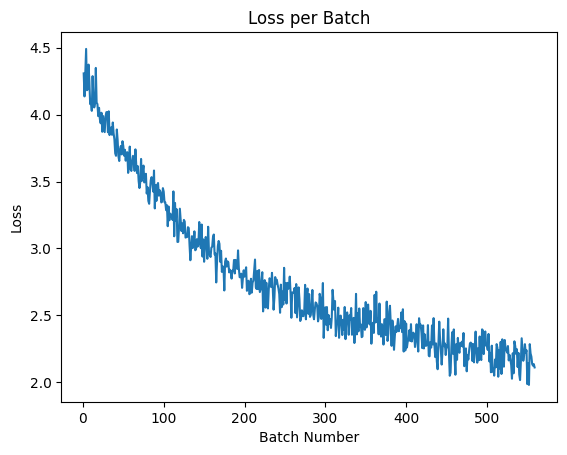

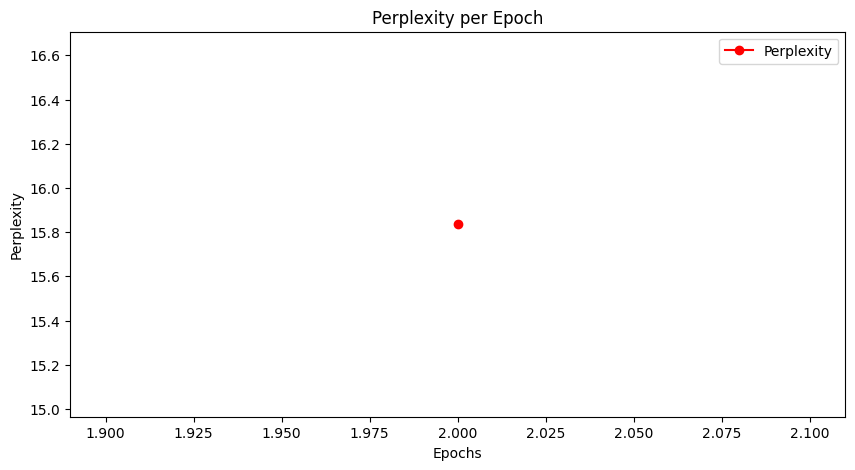

In [ ]:
# Fine tuning model -----------------------------------------------------------

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(),
                        lr=2e-5,
                        weight_decay=0.01  # Adjust learning rate as needed
                        )
lr_scheduler = get_scheduler("cosine",
                             optimizer=optimizer,
                             num_warmup_steps=500,
                             num_training_steps=10000
                            )
loss_fn = nn.CrossEntropyLoss(
                              ignore_index=TOKENIZER.pad_token_id,
                              label_smoothing=0.1
                              )
gradient_accumulation_steps = 4

# Training loop
epochs = 2  # Adjust the number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_time = time.time()

print(next(model.parameters()).device)

for epoch in range(epochs):

    model.train()

    tracker = EmissionsTracker()
    tracker.start()

    #Initializing variables and list for each epoch
    loss_values=[]
    nb_batch=[]
    perplexities=[]
    total_loss = 0
    total_samples = 0
    i=0

    loop = tqdm(train_dataloader, leave=True)

    for step, batch in enumerate(loop):
        i+=1
        nb_batch.append(i)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Forward pass
        with autocast():
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        #Backward pass
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
          optimizer.step()
          lr_scheduler.step()  # If using a scheduler
          optimizer.zero_grad()

        #Loss calculation
        total_loss += loss.item()
        loss_values.append(loss.item())
        total_samples += len(labels)

        print(f"Batch {i}/{len(train_dataloader)} - Loss: {loss.item()}")

    #Keep track
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss}")

    # Perplexity Calculation
    perplexity = torch.exp(torch.tensor(avg_loss, device=device))
    perplexities.append(perplexity.item())
    print(f"Epoch {epoch+1}/{epochs}, Perplexity: {perplexity:.2f}")

    #Evaluate memory usage
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Epoch {epoch+1}/{epochs}, Memory Usage: {memory_info.rss / 1024 / 1024} MB")

    #Evaluate training time per step
    total_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Total Training Time: {total_time / 60:.2f} minutes")

    #Track energy consumption
    tracker.stop()
    print(f"Epoch {epoch+1}/{epochs}, Energy consumption: {tracker.final_emissions}")

#Graph loss and logloss per batch
plt.plot(nb_batch, loss_values)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, perplexities, label="Perplexity", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity per Epoch")
plt.legend()
plt.show()

# Save the trained model (optional)
torch.save(model.state_dict(), "trained_model.pth")



Test and evaluate model

In [ ]:
#Test and evaluate-----------------------------------------------------------

def generate_conversation(persona1, persona2):
    input_text = persona1 + persona2
    input_ids = TOKENIZER(input_text, return_tensors="pt").input_ids

    # Generate response
    output_ids = model.generate(input_ids, max_length=150, num_beams=5, temperature=0.7)
    output_text = TOKENIZER.decode(output_ids[0], skip_special_tokens=True)

    return output_text

### Test on a new critic
persona1 = "I love hiking and nature walks. I also enjoy photography."
persona2 = "I prefer staying indoors and reading books. I love mystery novels."
generated_conversation = generate_conversation(persona1, persona2)

print("Generated Chatbot Conversation:\n", generated_conversation)

### Test on dataset

# Defining needed functions
def calculate_rouge_score(predictions, true_labels):
    rouge = Rouge()
    # Decode predictions and true_labels to strings before passing to Rouge
    predictions_decoded = [TOKENIZER.decode(p, skip_special_tokens=True) for p in predictions]
    true_labels_decoded = [TOKENIZER.decode(l, skip_special_tokens=True) for l in true_labels]

    # Filter out empty hypotheses and corresponding references
    filtered_predictions_decoded = []
    filtered_true_labels_decoded = []
    for pred, label in zip(predictions_decoded, true_labels_decoded):
        if pred.strip(): # Check if the prediction is not empty after stripping whitespace
            filtered_predictions_decoded.append(pred)
            filtered_true_labels_decoded.append(label)

    # Calculate average scores only if there are valid predictions
    if filtered_predictions_decoded:
        scores = rouge.get_scores(filtered_predictions_decoded, filtered_true_labels_decoded, avg=True)
    else:
        scores = {'rouge-1': {'f': 0, 'p': 0, 'r': 0}, 'rouge-2': {'f': 0, 'p': 0, 'r': 0}, 'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
    return scores

def calculate_persona_consistency_score(persona_1_statements, persona_2_statements, predicted_response):
    # Initialize a SentenceTransformer model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')  # You can choose a different pre-trained model if needed

    # Encode persona statements
    persona_1_embedding = sentence_model.encode(persona_1_statements, convert_to_tensor=True)
    persona_2_embedding = sentence_model.encode(persona_2_statements, convert_to_tensor=True)

    # Decode predicted_response to string before encoding
    predicted_response_decoded = TOKENIZER.decode(predicted_response[0], skip_special_tokens=True)  # Assuming predicted_response is a tensor
    response_embedding = sentence_model.encode(predicted_response_decoded, convert_to_tensor=True)

    # Compute cosine similarity
    user_1_score = util.pytorch_cos_sim(response_embedding, persona_1_embedding).mean().item()
    user_2_score = util.pytorch_cos_sim(response_embedding, persona_2_embedding).mean().item()

    # Compute average consistency score
    avg_consistency_score = (user_1_score + user_2_score) / 2

    return avg_consistency_score, user_1_score, user_2_score

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    all_predictions = []  # Store all predictions
    all_labels = []  # Store all labels

    with torch.no_grad():
      for batch in test_dataloader:
            input_ids =  batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Pass labels as decoder_input_ids during evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # Get predictions from the logits
            predictions = torch.argmax(outputs.logits, dim=2)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Compare predictions with shifted labels for accuracy calculation
            shifted_labels = labels[..., 1:]  # Shift labels to the right by one position
            predictions = predictions[..., :-1]  # Remove the last prediction
            # Calculate accuracy for valid predictions (ignoring padding)
            active_positions = shifted_labels != -100  # Ignore padding positions (-100)
            correct_predictions = (predictions == shifted_labels) * active_positions
            correct += correct_predictions.sum().item()
            total += active_positions.sum().item()

            # Rouge score is a recall-based evaluation
            rouge_score= calculate_rouge_score(shifted_labels, predictions)
            # Persona Consistency Score
            average_consistency_score, user_1_score, user_2_score = calculate_persona_consistency_score(persona1, persona2, predictions)
            inference_time=total_time / len(test_dataloader)

            # Create a DataFrame for logging
            evaluation_data = {
              "Metric": ["Rouge Score","Average Consistency Score",
                          "Persona 1 Score", "Persona 2 Score", "Inference Time"
                          ],
              "Value": [rouge_score,
                        average_consistency_score, user_1_score,
                        user_2_score, inference_time]
              }
            df = pd.DataFrame(evaluation_data)
    return df
    # Display in a tab (Colab only)
    from google.colab import data_table
    data_table.DataTable(df)

#calling evaluate function
evaluate(model, test_dataloader)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Chatbot Conversation:
 hiking and nature walks. I enjoy hiking and nature walks.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Metric,Value
0,Rouge Score,"{'rouge-1': {'r': 0.49749948142103684, 'p': 0...."
1,Average Consistency Score,0.078804
2,Persona 1 Score,0.062439
3,Persona 2 Score,0.09517
4,Inference Time,262.952681


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='index', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### Plotting perplexity

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First 10 Loss Values: [1.3505389771969032, 0.9117166996002197, 0.9258358478546143, 1.1227694749832153, 0.9802029728889465, 1.0146678686141968, 1.1090528964996338, 0.968330979347229, 1.1568022966384888, 0.813796877861023]
First 10 Perplexities: [3.8595051765441895, 2.488590955734253, 2.523977041244507, 3.0733540058135986, 2.664997100830078, 2.7584471702575684, 3.0314857959747314, 2.633545398712158, 3.179749011993408, 2.2564592361450195]


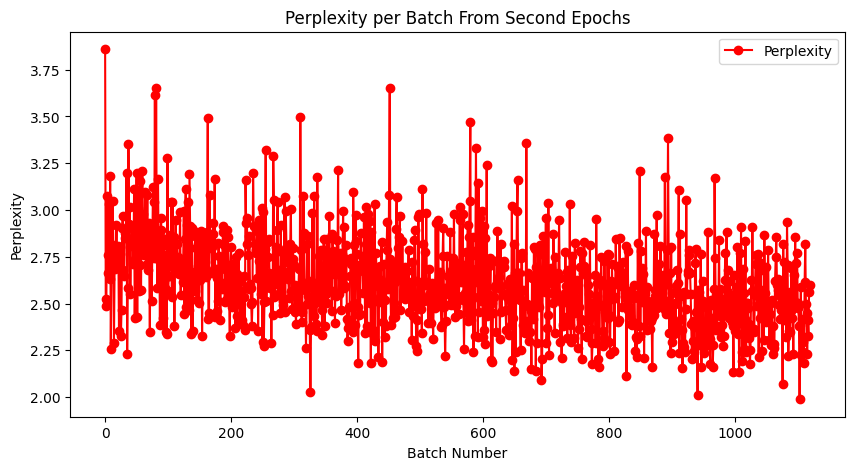

In [ ]:
# Plotting perplexity --------------------------------------------------------

drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/extracted_loss_valuesT5LargeOptimized.txt"

loss_values = []
batch_numbers = []
perplexities = []
# Read the loss values from the file
with open(file_path, 'r') as file:
    for line in file:  # Read line by line to avoid issues
        loss = float(line.strip())  # Ensure correct float conversion
        loss_values.append(loss)

#select only epoch 2 loss values to avoid extreme start
loss_values = loss_values[1118:]
# Compute Perplexities
i = 0
for loss in loss_values:
# Perplexity Calculation
  perplexity = torch.exp(torch.tensor(loss))
  perplexities.append(perplexity.item())
  batch_numbers.append(i)
  i += 1

# Print first 10 values for debugging
print("First 10 Loss Values:", loss_values[:10])
print("First 10 Perplexities:", perplexities[:10])

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(batch_numbers, perplexities, label="Perplexity", marker="o", color="red")
plt.xlabel("Batch Number")
plt.ylabel("Perplexity")
plt.title("Perplexity per Batch From Second Epochs")
plt.legend()
plt.show()
